In [1]:
# package(s) related to time, space and id
import datetime, time
import os
import io
import functools
import logging
import pickle
import random
import math

# package(s) related to the simulation
import enum
import simpy
import scipy as sc
import math
import networkx as nx  
import numpy as np
import pandas as pd
import re
import yaml as yaml
import time
import bisect
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.tri as tri
import xarray as xr

from osgeo import gdal
from scipy import interpolate
from scipy.signal import correlate
from shapely.ops import transform,split,snap
from matplotlib.ticker import MaxNLocator
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

# OpenTNSim
from opentnsim import core
from opentnsim import plot
from opentnsim import model
from opentnsim import import_hydrodynamic_dataset
from opentnsim import vessel_traffic_service
from opentnsim import port
from opentnsim import lock
from opentnsim import vessel
from opentnsim import waterway
from opentnsim import output
from opentnsim import tidal_window_constructor
from opentnsim import rule_constructor
from opentnsim import regulations

# spatial libraries 
import shapely.geometry
from shapely.geometry import Point
import shapely.wkt
import pyproj
import folium
import datetime
import time as timepy

# package(s) for data handling
import requests

logging.basicConfig(level=logging.INFO)
logger = logging.getLogger()

# define the coorinate systemb
geod = pyproj.Geod(ellps="WGS84")

location_vessel_database = "Vessels/richtlijnen-vaarwegen-2017.csv"

In [2]:
wgs = pyproj.CRS('EPSG:4326')
utm = pyproj.CRS('EPSG:28992')
wgs_to_utm = pyproj.Transformer.from_crs(wgs,utm,always_xy=True).transform
utm_to_wgs = pyproj.Transformer.from_crs(utm,wgs,always_xy=True).transform

In [3]:
starting_hour = 1000/(60*60*4)
next_hours = np.arange(0.25,12.25,0.25)
hours = np.append(np.array([starting_hour]),next_hours)

In [4]:
Node = type('Site', (core.Identifiable, core.Log, core.Locatable, core.HasResource), {})
nodes = []
path = []
coords = []

for hour in reversed(hours):
    coords.append(transform(utm_to_wgs,Point(155000-hour*60*60*4,463000)))
for hour in hours:
    coords.append(transform(utm_to_wgs,Point(155000+hour*60*60*4,463000)))

for index,coord in enumerate(coords):
    data_node = {"env": [],
                 "name": "Node_" + str(index+1),
                 "geometry": coord}
    node = Node(**data_node)
    nodes.append(node)
    
for i in range(len(nodes)-1):
    path.append([nodes[i],nodes[i+1]]) 
    path.append([nodes[i+1],nodes[i]])

FG = nx.MultiDiGraph()

positions = {}
for node in nodes:
    positions[node.name] = (node.geometry.x, node.geometry.y)
    FG.add_node(node.name, geometry = node.geometry)

for edge in path:
    geometry = shapely.geometry.LineString([FG.nodes[edge[0].name]['geometry'],FG.nodes[edge[1].name]['geometry']])
    FG.add_edge(edge[0].name, edge[1].name, weight = 1, Info = {},geometry=geometry)
    
for node in FG.nodes:
    FG.nodes[node]['Info'] = {}

In [5]:
for node in FG.nodes:
    FG.nodes[node]['geometry'] = transform(wgs_to_utm,FG.nodes[node]['geometry'])
    
for edge in FG.edges:
    geometry = transform(wgs_to_utm,FG.edges[edge]['geometry'])
    length = int(geometry.length)
    FG.edges[edge]['geometry'] = geometry
    FG.edges[edge]['Info']['geometry'] = geometry
    FG.edges[edge]['Info']['length'] = length

In [6]:
import pytz
simulation_start = datetime.datetime(2019,1,1,0,0,0)
duration = datetime.timedelta(seconds=14*24*60*60) #seconds

In [7]:
water_level = []
salinity = []

for nodes in enumerate(FG.nodes):
    water_level.append([[],[]])
    salinity.append([[],[]])

MBL = [11]*len(FG.nodes)
depth = MBL
times = np.arange(simulation_start,simulation_start+duration,datetime.timedelta(seconds=10*60))
stations = list(FG.nodes)

sea = True
for index,node in enumerate(list(FG.nodes)):
    if sea:
        water_level[index]=[1.0*np.sin(2*np.pi*((t-np.datetime64(0,'s'))/np.timedelta64(1, 's')-simulation_start.timestamp())/45000) for t in times]
        salinity[index]=[25.0 for t in times]
        if node == 'Node_49':
            sea = False
    else:
        water_level[index]=[0.0 for t in times]
        salinity[index]=[0.0 for t in times]

In [8]:
import xarray as xr
station_data = xr.DataArray(data=stations,
                         dims=["STATIONS"])

time_data = xr.DataArray(data=times,
                         dims=["TIME"])

MBL_data = xr.DataArray(data=MBL,
                        dims=["STATIONS"])

depth_data = xr.DataArray(data=depth,
                          dims=["STATIONS"])

water_level_data = xr.DataArray(data=[wlev for wlev in water_level],
                                dims=["STATIONS","TIME"])

salinity_data = xr.DataArray(data=[sal for sal in salinity],
                             dims=["STATIONS","TIME"])

hydrodynamic_data = xr.Dataset({'TIME':times,
                                'Stations':station_data,
                                'MBL':MBL_data,
                                'Depth':depth_data,
                                'Water level': water_level_data,
                                'Salinity':salinity_data})

C:\Users\floorbakker\AppData\Local\Temp\ipykernel_516\3095883058.py:5: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.

C:\Users\floorbakker\AppData\Local\Temp\ipykernel_516\3095883058.py:20: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by convert

In [9]:
sim = model.Simulation(graph=FG,simulation_start=simulation_start,simulation_duration=duration,hydrodynamic_data=hydrodynamic_data)
env = sim.environment

In [10]:
sim.environment.vessel_traffic_service

In [11]:
lock_1 = lock.IsLock(env = sim.environment, 
                     name = 'Lock',
                     distance_doors1_from_first_waiting_area=750,   
                     distance_doors2_from_second_waiting_area=FG.edges['Node_49','Node_50',0]['Info']['length']-1250,
                     node_doors1 = 'Node_49', node_doors2 = 'Node_50',time_step=60,
                     lock_length = 500, lock_width = 40, lock_depth = 10.5, 
                     doors_open = 600, doors_close = 600, disch_coeff = 0.8,
                     opening_area = 4.0, opening_depth = 5.0,node_open='Node_50',
                     detector_nodes=['Node_41','Node_58'], priority_rules = regulations.ConditionalRule('start_node','==','Node_50'))

lineup_area_1 = lock.IsLockLineUpArea(env = sim.environment, name = 'Lock', distance_to_lock_doors = 100,
                                      start_node = 'Node_49',end_node = 'Node_50', lineup_length = 500)

lineup_area_2 = lock.IsLockLineUpArea(env = sim.environment, name = "Lock", distance_to_lock_doors = 100,
                                      start_node = 'Node_50',end_node = 'Node_49', lineup_length = 500)

waiting_area_1 = lock.IsLockWaitingArea(env = sim.environment, name = 'Lock', distance_from_node=0,
                                        node = 'Node_49')
    
waiting_area_2 = lock.IsLockWaitingArea(env = sim.environment, name = "Lock", distance_from_node=0,
                                        node = 'Node_50')

c:\users\floorbakker\opentnsim\opentnsim\lock.py:343: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



In [12]:
lock_1.detector_nodes[0]

'Node_41'

In [13]:
Vessel = type('Vessel', 
              (core.SimpyObject, core.Identifiable, lock.HasWaitingArea, lock.HasLock, lock.HasLineUpArea, core.Movable, vessel.VesselProperties, output.HasOutput, vessel.ExtraMetadata), {})

In [14]:
def create_vessel(name,FG,origin,destination,length,beam,draught,height,v,arrival_time):
    vessel_input = { "name":name,
                     "geometry":FG.nodes[origin]['geometry'],
                     "origin":origin,
                     "destination":destination,
                     #"next_destination":next_destination,
                     "route":nx.dijkstra_path(FG,origin,destination),
                     "env":env,
                     "type":'Tanker',
                     "B":beam,
                     "L":length,
                     "T": draught,
                     "H":height,
                     #"t_berthing":berthing_time.total_seconds(),
                     #"t_(un)loading":[time.total_seconds() for time in unloading_time],
                     #"t_turning":[time.total_seconds() for time in turning_time],
                     #"ukc":ukc,
                     "v":v,
                     #"terminal_of_call": terminal_of_call,
                     #"berth_of_call": berth_of_call,
                     #"(un)loading": delta_draught,
                     #"max_waiting_time":datetime.timedelta(days=10).total_seconds(),
                     #"max_cross_current":max_cross_current,
                     "arrival_time":arrival_time,
                     #"arrival_delay":arrival_time,
                     #"priority": 0,
                     #"additional_waiting_time": additional_waiting_time/np.timedelta64(1, 's'),
                     #"bound":bound,
                     #"priority":False
                   }
    return vessel_input

In [15]:
random.seed(0)
month_reached = False
arrival_time = sim.environment.simulation_start
vessel_index = 0
while not month_reached:
    arrival_time += pd.Timedelta(random.uniform(0,4),'h')
    created_vessel = Vessel(**create_vessel(name = f'inbound_vessel_{vessel_index}',
                                            FG = FG,
                                            origin='Node_1',
                                            destination='Node_98',
                                            length=200,
                                            beam=35,
                                            draught=10,
                                            height=5,
                                            v=4,
                                            arrival_time=arrival_time))
    sim.add_vessels(vessel=created_vessel)
    vessel_index += 1
    if arrival_time > sim.environment.simulation_start + datetime.timedelta(days=14):
        month_reached = True

month_reached = False
arrival_time = sim.environment.simulation_start
vessel_index = 0
while not month_reached:
    arrival_time += pd.Timedelta(random.uniform(0,4),'h')
    created_vessel = Vessel(**create_vessel(name = f'outbound_vessel_{vessel_index}',
                                            FG = FG,
                                            origin='Node_98',
                                            destination='Node_1',
                                            length=200,
                                            beam=35,
                                            draught=10,
                                            height=5,
                                            v=4,
                                            arrival_time=arrival_time))
    sim.add_vessels(vessel=created_vessel)
    vessel_index += 1
    if arrival_time > sim.environment.simulation_start + datetime.timedelta(days=14):
        month_reached = True
    

In [16]:
waiting_area_1.resource.users

[]

In [17]:
t1 = timepy.time()
sim.run()
t2 = timepy.time()
print(t2-t1)

outbound_vessel_0
outbound_vessel_1
inbound_vessel_0
outbound_vessel_2
inbound_vessel_1
inbound_vessel_2
outbound_vessel_3
inbound_vessel_3
hi got outbound_vessel_0 2019-01-01 11:01:33.438305 300
outbound_vessel_4
outbound_vessel_5
haiii outbound_vessel_0
haiii outbound_vessel_0
outbound_vessel_0 start waiting time 2019-01-01 13:00:14.271638 300
claim the lock doors outbound_vessel_0 2019-01-01 13:00:14.271638
formal request 1
lock is empty and not converting hihi haha ho ho ho outbound_vessel_0 2019-01-01 13:00:14.271638 0 1
outbound_vessel_0 0
lock doors claimed outbound_vessel_0 2019-01-01 13:00:14.271638
outbound_vessel_0 sail to assigned lock position
inbound_vessel_4
ho got outbound_vessel_1 2019-01-01 13:06:33.901914 100
left doors1 outbound_vessel_0 2019-01-01 13:11:20.938305 0 [] ['outbound_vessel_0']
print doors outbound_vessel_0 ['outbound_vessel_0'] []
outbound_vessel_0 in lock ['outbound_vessel_0', 'outbound_vessel_1']
hii outbound_vessel_0 2019-01-01 13:11:20.938305
hi go

c:\users\floorbakker\opentnsim\opentnsim\lock.py:535: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precis

ho got outbound_vessel_2 2019-01-01 15:41:21.047553 0
outbound_vessel_1 hap is geconvert 2019-01-01 16:09:39.179692
100
0
0
waiting for others done outbound_vessel_0
yo yo yo outbound_vessel_0 2019-01-01 16:09:39.179692
left lock outbound_vessel_0 2019-01-01 16:09:39.179692
leave lock outbound_vessel_0 0
left lock outbound_vessel_1 2019-01-01 16:14:00.290803
leave lock outbound_vessel_1 0
500 back
left doors2 outbound_vessel_1 2019-01-01 16:22:03.624136 0 [] []
claiming lock: priority doors2 not -1 inbound_vessel_0 2019-01-01 16:22:03.624136
inbound_vessel_0 sail to assigned lock position
left doors1 inbound_vessel_0 2019-01-01 16:33:10.290803 [] 1 ['inbound_vessel_0']
print doors inbound_vessel_0 [] ['inbound_vessel_0']
inbound_vessel_0 in lock ['inbound_vessel_0']
inbound_vessel_0 converting hap 2019-01-01 16:33:10.290803
hi 2019-01-01 16:33:10.290803
2019-01-01 16:33:10.290803 Node_49 Node_50 Lock doors closing start
door open 965 998 2011.2908029556274
len time 34 2019-01-01T16:05:

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



inbound_vessel_5
ho got inbound_vessel_1 2019-01-01 16:56:19.187121 0
inbound_vessel_0 hap is geconvert 2019-01-01 17:18:10.290803
300
500
300
left lock inbound_vessel_0 2019-01-01 17:18:10.290803
leave lock inbound_vessel_0 0
500 back
left doors2 inbound_vessel_0 2019-01-01 17:22:31.401914 1 [] []
outbound_vessel_7
haiii outbound_vessel_2
haiii outbound_vessel_2
outbound_vessel_2 start waiting time 2019-01-01 17:40:01.880886 300
claim the lock doors outbound_vessel_2 2019-01-01 17:40:01.880886
formal request 3
lock is empty and not converting hihi haha outbound_vessel_2 2019-01-01 17:40:01.880886 0 1
lock doors claimed outbound_vessel_2 2019-01-01 17:40:01.880886
outbound_vessel_2 sail to assigned lock position
left doors1 outbound_vessel_2 2019-01-01 17:51:08.547553 0 [] ['outbound_vessel_2']
print doors outbound_vessel_2 ['outbound_vessel_2'] []
outbound_vessel_2 in lock ['outbound_vessel_2']
outbound_vessel_2 converting hap 2019-01-01 17:51:08.547553
hi 2019-01-01 17:51:08.547553
2

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



outbound_vessel_2 hap is geconvert 2019-01-01 18:18:08.547553
300
500
300
left lock outbound_vessel_2 2019-01-01 18:18:08.547553
leave lock outbound_vessel_2 0
500 back
left doors2 outbound_vessel_2 2019-01-01 18:22:29.658664 0 [] []
haiii inbound_vessel_1
haiii inbound_vessel_1
inbound_vessel_1 start waiting time 2019-01-01 18:55:00.020454 100
claim the lock doors inbound_vessel_1 2019-01-01 18:55:00.020454
formal request 3
lock is empty and not converting hihi haha inbound_vessel_1 2019-01-01 18:55:00.020454 0 2
lock doors claimed inbound_vessel_1 2019-01-01 18:55:00.020454
inbound_vessel_1 sail to assigned lock position
left doors1 inbound_vessel_1 2019-01-01 19:06:06.687121 [] 1 ['inbound_vessel_1']
print doors inbound_vessel_1 [] ['inbound_vessel_1']
inbound_vessel_1 in lock ['inbound_vessel_1', 'inbound_vessel_2']
hii inbound_vessel_1 2019-01-01 19:06:06.687121
hi got outbound_vessel_3 2019-01-01 19:10:35.886787 300
inbound_vessel_6
outbound_vessel_8
ho got inbound_vessel_3 2019-

c:\users\floorbakker\opentnsim\opentnsim\lock.py:535: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precis

inbound_vessel_2 hap is geconvert 2019-01-01 21:01:32.866103
100
0
0
waiting for others done inbound_vessel_1
yo yo yo inbound_vessel_1 2019-01-01 21:01:32.866103
left lock inbound_vessel_1 2019-01-01 21:01:32.866103
leave lock inbound_vessel_1 100
left lock inbound_vessel_2 2019-01-01 21:05:53.977214
haiii outbound_vessel_3
haiii outbound_vessel_3
outbound_vessel_3 start waiting time 2019-01-01 21:09:16.720120 300
claim the lock doors outbound_vessel_3 2019-01-01 21:09:16.720120
lock not empty outbound_vessel_3 2019-01-01 21:09:16.720120 ['inbound_vessel_2']
lock is not empty (may be converting) outbound_vessel_3 2019-01-01 21:09:16.720120 True
leave lock inbound_vessel_2 100
500 back
left doors2 inbound_vessel_2 2019-01-01 21:13:57.310547 1 [] []
requested first set of doors outbound_vessel_3 2019-01-01 21:13:57.310547
lock doors claimed outbound_vessel_3 2019-01-01 21:13:57.310547
inbound_vessel_8
outbound_vessel_3 sail to assigned lock position
left doors1 outbound_vessel_3 2019-01

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



inbound_vessel_9
haiii inbound_vessel_3
haiii inbound_vessel_3
inbound_vessel_3 start waiting time 2019-01-01 21:53:45.780488 300
claim the lock doors inbound_vessel_3 2019-01-01 21:53:45.780488
lock not empty inbound_vessel_3 2019-01-01 21:53:45.780488 ['outbound_vessel_3']
lock is not empty (may be converting) inbound_vessel_3 2019-01-01 21:53:45.780488 True
outbound_vessel_3 hap is geconvert 2019-01-01 22:22:03.977214
300
500
300
left lock outbound_vessel_3 2019-01-01 22:22:03.977214
leave lock outbound_vessel_3 0
500 back
left doors2 outbound_vessel_3 2019-01-01 22:26:25.088325 0 [] []
requested first set of doors inbound_vessel_3 2019-01-01 22:26:25.088325
lock doors claimed inbound_vessel_3 2019-01-01 22:26:25.088325
inbound_vessel_3 sail to assigned lock position
hi got outbound_vessel_4 2019-01-01 22:34:53.739164 300
left doors1 inbound_vessel_3 2019-01-01 22:37:31.754992 [] 1 ['inbound_vessel_3']
print doors inbound_vessel_3 [] ['inbound_vessel_3']
inbound_vessel_3 in lock ['i

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



ho got inbound_vessel_4 2019-01-01 23:03:11.646837 0
inbound_vessel_3 hap is geconvert 2019-01-01 23:23:31.754992
300
500
300
left lock inbound_vessel_3 2019-01-01 23:23:31.754992
leave lock inbound_vessel_3 0
500 back
left doors2 inbound_vessel_3 2019-01-01 23:27:52.866103 1 [] []
ho got outbound_vessel_6 2019-01-01 23:46:58.529412 100
outbound_vessel_10
haiii outbound_vessel_4
haiii outbound_vessel_4
outbound_vessel_4 start waiting time 2019-01-02 00:33:34.572497 100
claim the lock doors outbound_vessel_4 2019-01-02 00:33:34.572497
formal request 3
lock is empty and not converting hihi haha outbound_vessel_4 2019-01-02 00:33:34.572497 0 3
lock doors claimed outbound_vessel_4 2019-01-02 00:33:34.572497
outbound_vessel_4 sail to assigned lock position
haiii outbound_vessel_5
haiii outbound_vessel_5
outbound_vessel_5 start waiting time 2019-01-02 00:43:20.123637 100
claim the lock doors outbound_vessel_5 2019-01-02 00:43:20.123637
formal request 1
left doors1 outbound_vessel_4 2019-01-0

c:\users\floorbakker\opentnsim\opentnsim\lock.py:535: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precis

outbound_vessel_5 hap is geconvert 2019-01-02 01:36:05.683609
100
0
0
waiting for others done outbound_vessel_4
yo yo yo outbound_vessel_4 2019-01-02 01:36:05.683609
left lock outbound_vessel_4 2019-01-02 01:36:05.683609
leave lock outbound_vessel_4 100
left lock outbound_vessel_5 2019-01-02 01:40:26.794720
haiii outbound_vessel_6
haiii outbound_vessel_6
outbound_vessel_6 start waiting time 2019-01-02 01:45:39.362745 100
leave lock outbound_vessel_5 100
500 back
claim the lock doors outbound_vessel_6 2019-01-02 01:46:00.128053
approach node != node open 2019-01-02 01:46:00.128053 []
requesting approach: else outbound_vessel_6 2019-01-02 01:46:00.128053 0 [] ['outbound_vessel_5']
left doors2 outbound_vessel_5 2019-01-02 01:48:30.128053 0 [] []
claiming lock: priority doors2 not -1 inbound_vessel_4 2019-01-02 01:48:30.128053
inbound_vessel_4 sail to assigned lock position
left doors1 inbound_vessel_4 2019-01-02 01:59:36.794720 ['outbound_vessel_6'] 1 ['inbound_vessel_4']
print doors inbo

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



outbound_vessel_11
ho got inbound_vessel_5 2019-01-02 02:55:27.966763 0
inbound_vessel_4 hap is geconvert 2019-01-02 02:55:36.794720
300
500
300
left lock inbound_vessel_4 2019-01-02 02:55:36.794720
leave lock inbound_vessel_4 0
500 back
left doors2 inbound_vessel_4 2019-01-02 02:59:57.905831 1 [] []
claiming lock: priority doors2 not -1 outbound_vessel_6 2019-01-02 02:59:57.905831
outbound_vessel_6 sail to assigned lock position
left doors1 outbound_vessel_6 2019-01-02 03:11:04.572498 0 [] ['outbound_vessel_6']
print doors outbound_vessel_6 ['outbound_vessel_6'] []
outbound_vessel_6 in lock ['outbound_vessel_6']
outbound_vessel_6 converting hap 2019-01-02 03:11:04.572498
hi 2019-01-02 03:11:04.572498
2019-01-02 03:11:04.572498 Node_50 Node_49 Lock doors closing start
door open 1611 1636 1528.572497844696
len time 26 2019-01-02T02:51:00.000000000
14.474006430173153
13.978942658553992
13.486046940487373
12.996379638668403
12.510973208732814
12.03082369673363
11.556882889884672
11.090051

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



ho got outbound_vessel_7 2019-01-02 03:34:08.166192 0
inbound_vessel_12
outbound_vessel_6 hap is geconvert 2019-01-02 04:10:04.572498
300
500
300
left lock outbound_vessel_6 2019-01-02 04:10:04.572498
outbound_vessel_0
leave lock outbound_vessel_6 0
500 back
left doors2 outbound_vessel_6 2019-01-02 04:14:25.683609 0 [] []
outbound_vessel_1
inbound_vessel_13
haiii inbound_vessel_5
haiii inbound_vessel_5
inbound_vessel_5 start waiting time 2019-01-02 04:54:08.800096 300
claim the lock doors inbound_vessel_5 2019-01-02 04:54:08.800096
formal request 3
lock is empty and not converting hihi haha inbound_vessel_5 2019-01-02 04:54:08.800096 0 1
lock doors claimed inbound_vessel_5 2019-01-02 04:54:08.800096
inbound_vessel_5 sail to assigned lock position
outbound_vessel_12
left doors1 inbound_vessel_5 2019-01-02 05:05:15.466763 [] 1 ['inbound_vessel_5']
print doors inbound_vessel_5 [] ['inbound_vessel_5']
inbound_vessel_5 in lock ['inbound_vessel_5']
inbound_vessel_5 converting hap 2019-01-02 

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



ho got inbound_vessel_6 2019-01-02 05:15:28.668131 0
inbound_vessel_0
haiii outbound_vessel_7
haiii outbound_vessel_7
outbound_vessel_7 start waiting time 2019-01-02 05:32:48.999525 300
claim the lock doors outbound_vessel_7 2019-01-02 05:32:48.999525
lock not empty outbound_vessel_7 2019-01-02 05:32:48.999525 ['inbound_vessel_5']
lock is not empty (may be converting) outbound_vessel_7 2019-01-02 05:32:48.999525 True
inbound_vessel_5 hap is geconvert 2019-01-02 05:47:15.466763
300
500
300
left lock inbound_vessel_5 2019-01-02 05:47:15.466763
leave lock inbound_vessel_5 0
500 back
ho got outbound_vessel_8 2019-01-02 05:50:19.702413 100
left doors2 inbound_vessel_5 2019-01-02 05:51:36.577874 1 [] []
requested first set of doors outbound_vessel_7 2019-01-02 05:51:36.577874
lock doors claimed outbound_vessel_7 2019-01-02 05:51:36.577874
outbound_vessel_7 sail to assigned lock position
ho got outbound_vessel_9 2019-01-02 06:00:24.567673 100
left doors1 outbound_vessel_7 2019-01-02 06:02:43.

c:\users\floorbakker\opentnsim\opentnsim\lock.py:535: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precis

ho got inbound_vessel_10 2019-01-02 08:38:25.562666 100
outbound_vessel_8 hap is geconvert 2019-01-02 08:50:24.980191
100
0
0
waiting for others done outbound_vessel_7
yo yo yo outbound_vessel_7 2019-01-02 08:50:24.980191
left lock outbound_vessel_7 2019-01-02 08:50:24.980191
leave lock outbound_vessel_7 100
left lock outbound_vessel_8 2019-01-02 08:54:46.091302
leave lock outbound_vessel_8 100
500 back
claim the lock doors outbound_vessel_9 2019-01-02 09:00:19.424635
approach node != node open 2019-01-02 09:00:19.424635 []
requesting approach: else outbound_vessel_9 2019-01-02 09:00:19.424635 0 [] ['outbound_vessel_8']
inbound_vessel_1
left doors2 outbound_vessel_8 2019-01-02 09:02:49.424635 0 [] []
claiming lock: priority doors2 not -1 inbound_vessel_6 2019-01-02 09:02:49.424635
inbound_vessel_6 sail to assigned lock position
inbound_vessel_2
left doors1 inbound_vessel_6 2019-01-02 09:13:56.091302 ['inbound_vessel_7'] 1 ['inbound_vessel_6']
print doors inbound_vessel_6 ['inbound_vess

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



haiii inbound_vessel_9
haiii inbound_vessel_9
inbound_vessel_9 start waiting time 2019-01-02 09:35:52.438018 100
ho got outbound_vessel_10 2019-01-02 09:51:05.889574 100
outbound_vessel_3
inbound_vessel_7 hap is geconvert 2019-01-02 10:24:02.757969
100
0
0
waiting for others done inbound_vessel_6
yo yo yo inbound_vessel_6 2019-01-02 10:24:02.757969
left lock inbound_vessel_6 2019-01-02 10:24:02.757969
leave lock inbound_vessel_6 100
left doors2 inbound_vessel_6 2019-01-02 10:28:23.869080 1 [] []
left lock inbound_vessel_7 2019-01-02 10:28:23.869080
leave lock inbound_vessel_7 100
500 back
claim the lock doors inbound_vessel_8 2019-01-02 10:33:57.202413
approach node != node open 2019-01-02 10:33:57.202413 []
requesting approach: else inbound_vessel_8 2019-01-02 10:33:57.202413 0 [] ['inbound_vessel_7']
claim the lock doors inbound_vessel_9 2019-01-02 10:33:57.202413
approach node != node open 2019-01-02 10:33:57.202413 []
requesting approach: else inbound_vessel_9 2019-01-02 10:33:57.2

c:\users\floorbakker\opentnsim\opentnsim\lock.py:535: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precis

outbound_vessel_10 hap is geconvert 2019-01-02 12:27:11.167352
100
0
0
waiting for others done outbound_vessel_9
yo yo yo outbound_vessel_9 2019-01-02 12:27:11.167352
left lock outbound_vessel_9 2019-01-02 12:27:11.167352
ho got outbound_vessel_11 2019-01-02 12:28:23.100425 0
leave lock outbound_vessel_9 0
left lock outbound_vessel_10 2019-01-02 12:31:32.278463
leave lock outbound_vessel_10 0
500 back
left doors2 outbound_vessel_10 2019-01-02 12:39:35.611796 0 [] []
claiming lock: priority doors2 not -1 inbound_vessel_8 2019-01-02 12:39:35.611796
inbound_vessel_8 sail to assigned lock position
inbound_vessel_16
left doors1 inbound_vessel_8 2019-01-02 12:50:42.278463 ['inbound_vessel_9'] 1 ['inbound_vessel_8']
print doors inbound_vessel_8 ['inbound_vessel_9'] ['inbound_vessel_8']
inbound_vessel_8 in lock ['inbound_vessel_8', 'inbound_vessel_9', 'inbound_vessel_10', 'inbound_vessel_11']
hii inbound_vessel_8 2019-01-02 12:50:42.278463
claiming lock: priority doors2 not -1 inbound_vessel_9

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



outbound_vessel_4
inbound_vessel_9 hap is geconvert 2019-01-02 13:39:48.945130
100
0
0
waiting for others done inbound_vessel_8
yo yo yo inbound_vessel_8 2019-01-02 13:39:48.945130
left lock inbound_vessel_8 2019-01-02 13:39:48.945130
leave lock inbound_vessel_8 100
outbound_vessel_17
left doors2 inbound_vessel_8 2019-01-02 13:44:10.056241 1 [] []
left lock inbound_vessel_9 2019-01-02 13:44:10.056241
outbound_vessel_5
leave lock inbound_vessel_9 100
500 back
claim the lock doors inbound_vessel_10 2019-01-02 13:49:43.389574
approach node != node open 2019-01-02 13:49:43.389574 []
else: claiming lock: priority doors2 = -1 inbound_vessel_10 2019-01-02 13:49:43.389574 -1
claim the lock doors inbound_vessel_11 2019-01-02 13:49:43.389574
approach node != node open 2019-01-02 13:49:43.389574 []
else: claiming lock: priority doors2 = -1 inbound_vessel_11 2019-01-02 13:49:43.389574 -1
requested first set of doors inbound_vessel_10 2019-01-02 13:49:43.389574
lock doors claimed inbound_vessel_10 

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



ho got inbound_vessel_12 2019-01-02 14:00:41.607194 100
inbound_vessel_17
haiii outbound_vessel_11
haiii outbound_vessel_11
outbound_vessel_11 start waiting time 2019-01-02 14:27:03.933758 300
claim the lock doors outbound_vessel_11 2019-01-02 14:27:03.933758
approach node != node open 2019-01-02 14:27:03.933758 []
requesting approach: else outbound_vessel_11 2019-01-02 14:27:03.933758 0 ['inbound_vessel_10'] ['inbound_vessel_10']
ho got inbound_vessel_13 2019-01-02 14:35:57.851364 100
empty conversion done inbound_vessel_10 2019-01-02 14:39:43.389574
inbound_vessel_10 sail to assigned lock position
left doors1 inbound_vessel_10 2019-01-02 14:50:50.056241 ['inbound_vessel_11'] 1 ['inbound_vessel_10']
print doors inbound_vessel_10 ['inbound_vessel_11'] ['inbound_vessel_10']
inbound_vessel_10 in lock ['inbound_vessel_10', 'inbound_vessel_11', 'inbound_vessel_12', 'inbound_vessel_13']
hii inbound_vessel_10 2019-01-02 14:50:50.056241
requested first set of doors inbound_vessel_11 2019-01-0

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



haiii inbound_vessel_12
haiii inbound_vessel_12
inbound_vessel_12 start waiting time 2019-01-02 15:59:22.440527 100
inbound_vessel_11 hap is geconvert 2019-01-02 15:59:56.722908
100
0
0
waiting for others done inbound_vessel_10
yo yo yo inbound_vessel_10 2019-01-02 15:59:56.722908
left lock inbound_vessel_10 2019-01-02 15:59:56.722908
leave lock inbound_vessel_10 100
left lock inbound_vessel_11 2019-01-02 16:04:17.834019
leave lock inbound_vessel_11 100
500 back
claim the lock doors inbound_vessel_12 2019-01-02 16:09:51.167352
approach node != node open 2019-01-02 16:09:51.167352 []
requesting approach: else inbound_vessel_12 2019-01-02 16:09:51.167352 0 [] ['inbound_vessel_11']
outbound_vessel_6
left doors2 inbound_vessel_11 2019-01-02 16:12:21.167352 1 [] []
claiming lock: priority doors2 not -1 outbound_vessel_11 2019-01-02 16:12:21.167352
outbound_vessel_11 sail to assigned lock position
left doors1 outbound_vessel_11 2019-01-02 16:23:27.834019 0 ['inbound_vessel_12'] ['outbound_ve

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



inbound_vessel_19
ho got inbound_vessel_14 2019-01-02 17:31:07.428538 100
ho got outbound_vessel_13 2019-01-02 17:36:36.799439 0
inbound_vessel_5
outbound_vessel_19
outbound_vessel_12 hap is geconvert 2019-01-02 17:58:04.043940
100
0
0
waiting for others done outbound_vessel_11
yo yo yo outbound_vessel_11 2019-01-02 17:58:04.043940
left lock outbound_vessel_11 2019-01-02 17:58:04.043940
leave lock outbound_vessel_11 0
left lock outbound_vessel_12 2019-01-02 18:02:25.155051
leave lock outbound_vessel_12 0
500 back
left doors2 outbound_vessel_12 2019-01-02 18:10:28.488384 0 [] []
claiming lock: priority doors2 not -1 inbound_vessel_12 2019-01-02 18:10:28.488384
inbound_vessel_12 sail to assigned lock position
left doors1 inbound_vessel_12 2019-01-02 18:21:35.155051 ['inbound_vessel_13'] 1 ['inbound_vessel_12']
print doors inbound_vessel_12 ['inbound_vessel_13'] ['inbound_vessel_12']
inbound_vessel_12 in lock ['inbound_vessel_12', 'inbound_vessel_13', 'inbound_vessel_14']
hii inbound_vess

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



inbound_vessel_13 hap is geconvert 2019-01-02 18:53:41.821718
100
0
0
waiting for others done inbound_vessel_12
yo yo yo inbound_vessel_12 2019-01-02 18:53:41.821718
left lock inbound_vessel_12 2019-01-02 18:53:41.821718
leave lock inbound_vessel_12 100
left doors2 inbound_vessel_12 2019-01-02 18:58:02.932829 1 [] []
left lock inbound_vessel_13 2019-01-02 18:58:02.932829
leave lock inbound_vessel_13 100
500 back
left doors2 inbound_vessel_13 2019-01-02 19:06:06.266162 1 [] []
inbound_vessel_20
haiii inbound_vessel_14
haiii inbound_vessel_14
inbound_vessel_14 start waiting time 2019-01-02 19:29:48.261871 300
claim the lock doors inbound_vessel_14 2019-01-02 19:29:48.261871
approach node != node open 2019-01-02 19:29:48.261871 []
else: claiming lock: priority doors2 not -1 inbound_vessel_14 2019-01-02 19:29:48.261871 0
requested first set of doors inbound_vessel_14 2019-01-02 19:29:48.261871
lock doors claimed, empty conversion requested inbound_vessel_14 2019-01-02 19:29:48.261871
empty

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



empty conversion done inbound_vessel_14 2019-01-02 20:11:48.261871
inbound_vessel_14 sail to assigned lock position
left doors1 inbound_vessel_14 2019-01-02 20:22:54.928538 ['outbound_vessel_13'] 1 ['inbound_vessel_14']
print doors inbound_vessel_14 ['outbound_vessel_13'] ['inbound_vessel_14']
inbound_vessel_14 in lock ['inbound_vessel_14']
inbound_vessel_14 converting hap 2019-01-02 20:22:54.928538
hi 2019-01-02 20:22:54.928538
2019-01-02 20:22:54.928538 Node_49 Node_50 Lock doors closing start
outbound_vessel_13 waited for next lockage 2019-01-02 20:22:54.928538
door open 2647 2668 1266.9285380840302
len time 22 2019-01-02T20:07:00.000000000
2.4885826470129295
3.4285563922480646
4.362481405228266
5.287430192502828
6.20058857100634
7.0992886886230755
7.981038253362317
8.843545350043858
9.68473840819532
10.502781077733491
11.296081958805125
12.063299308918983
12.803341006050992
13.515360174830626
14.198746980714278
14.853117163061697
15.478297913185914
16.074311710373944
16.64135871143

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



outbound_vessel_7
ho got inbound_vessel_15 2019-01-02 20:55:14.251636 0
outbound_vessel_8
outbound_vessel_20
ho got outbound_vessel_14 2019-01-02 21:05:45.113972 100
outbound_vessel_21
inbound_vessel_14 hap is geconvert 2019-01-02 21:15:54.928538
300
500
300
left lock inbound_vessel_14 2019-01-02 21:15:54.928538
leave lock inbound_vessel_14 0
500 back
left doors2 inbound_vessel_14 2019-01-02 21:20:16.039649 1 [] []
yo yo
lock doors claimed outbound_vessel_13 2019-01-02 21:20:16.039649
outbound_vessel_13 sail to assigned lock position
inbound_vessel_21
left doors1 outbound_vessel_13 2019-01-02 21:31:22.706316 0 [] ['outbound_vessel_13']
print doors outbound_vessel_13 ['outbound_vessel_13'] []
outbound_vessel_13 in lock ['outbound_vessel_13', 'outbound_vessel_14']
hii outbound_vessel_13 2019-01-02 21:31:22.706316
outbound_vessel_22
ho got outbound_vessel_15 2019-01-02 21:55:38.069065 100
inbound_vessel_6
inbound_vessel_7
ho got inbound_vessel_16 2019-01-02 22:48:33.106738 100
haiii inbou

c:\users\floorbakker\opentnsim\opentnsim\lock.py:535: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precis

ho got outbound_vessel_17 2019-01-02 23:41:43.713799 100
haiii outbound_vessel_15
haiii outbound_vessel_15
outbound_vessel_15 start waiting time 2019-01-02 23:54:18.902398 100
outbound_vessel_14 hap is geconvert 2019-01-03 00:03:50.391750
100
0
0
waiting for others done outbound_vessel_13
yo yo yo outbound_vessel_13 2019-01-03 00:03:50.391750
left lock outbound_vessel_13 2019-01-03 00:03:50.391750
leave lock outbound_vessel_13 100
left lock outbound_vessel_14 2019-01-03 00:08:11.502861
ho got inbound_vessel_17 2019-01-03 00:13:27.701883 100
leave lock outbound_vessel_14 100
500 back
claim the lock doors outbound_vessel_15 2019-01-03 00:13:44.836194
approach node != node open 2019-01-03 00:13:44.836194 []
requesting approach: else outbound_vessel_15 2019-01-03 00:13:44.836194 0 [] ['outbound_vessel_14']
left doors2 outbound_vessel_14 2019-01-03 00:16:14.836194 0 [] []
claiming lock: priority doors2 not -1 inbound_vessel_15 2019-01-03 00:16:14.836194
inbound_vessel_15 sail to assigned lo

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



inbound_vessel_16 hap is geconvert 2019-01-03 01:15:38.384516
100
0
0
waiting for others done inbound_vessel_15
yo yo yo inbound_vessel_15 2019-01-03 01:15:38.384516
left lock inbound_vessel_15 2019-01-03 01:15:38.384516
leave lock inbound_vessel_15 100
left lock inbound_vessel_16 2019-01-03 01:19:59.495627
leave lock inbound_vessel_16 100
500 back
left doors2 inbound_vessel_16 2019-01-03 01:28:02.828960 1 [] []
claiming lock: priority doors2 not -1 outbound_vessel_15 2019-01-03 01:28:02.828960
outbound_vessel_15 sail to assigned lock position
left doors1 outbound_vessel_15 2019-01-03 01:39:09.495627 0 ['outbound_vessel_16'] ['outbound_vessel_15']
print doors outbound_vessel_15 ['outbound_vessel_15'] ['outbound_vessel_16']
outbound_vessel_15 in lock ['outbound_vessel_15', 'outbound_vessel_16', 'outbound_vessel_17', 'outbound_vessel_18']
hii outbound_vessel_15 2019-01-03 01:39:09.495627
claiming lock: priority doors2 not -1 outbound_vessel_16 2019-01-03 01:39:09.495627
inbound_vessel_8


c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



haiii inbound_vessel_17
haiii inbound_vessel_17
inbound_vessel_17 start waiting time 2019-01-03 02:12:08.535216 300
claim the lock doors inbound_vessel_17 2019-01-03 02:12:08.535216
lock not empty inbound_vessel_17 2019-01-03 02:12:08.535216 ['outbound_vessel_15', 'outbound_vessel_16']
lock is not empty (may be converting) inbound_vessel_17 2019-01-03 02:12:08.535216 True
outbound_vessel_16 hap is geconvert 2019-01-03 02:34:16.162294
100
0
0
waiting for others done outbound_vessel_15
yo yo yo outbound_vessel_15 2019-01-03 02:34:16.162294
left lock outbound_vessel_15 2019-01-03 02:34:16.162294
leave lock outbound_vessel_15 100
left doors2 outbound_vessel_15 2019-01-03 02:38:37.273405 0 [] []
left lock outbound_vessel_16 2019-01-03 02:38:37.273405
ho got inbound_vessel_18 2019-01-03 02:40:04.474300 100
leave lock outbound_vessel_16 100
500 back
claim the lock doors outbound_vessel_17 2019-01-03 02:44:10.606738
approach node != node open 2019-01-03 02:44:10.606738 []
requesting approach: 

c:\users\floorbakker\opentnsim\opentnsim\lock.py:535: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precis

ho got inbound_vessel_20 2019-01-03 05:23:37.894675 100
haiii inbound_vessel_19
haiii inbound_vessel_19
inbound_vessel_19 start waiting time 2019-01-03 05:27:49.787226 100
inbound_vessel_18 hap is geconvert 2019-01-03 05:43:09.752078
100
0
0
waiting for others done inbound_vessel_17
yo yo yo inbound_vessel_17 2019-01-03 05:43:09.752078
left lock inbound_vessel_17 2019-01-03 05:43:09.752078
leave lock inbound_vessel_17 100
left lock inbound_vessel_18 2019-01-03 05:47:30.863189
leave lock inbound_vessel_18 100
500 back
claim the lock doors inbound_vessel_19 2019-01-03 05:53:04.196522
approach node != node open 2019-01-03 05:53:04.196522 []
requesting approach: else inbound_vessel_19 2019-01-03 05:53:04.196522 0 [] ['inbound_vessel_18']
left doors2 inbound_vessel_18 2019-01-03 05:55:34.196522 1 [] []
claiming lock: priority doors2 not -1 outbound_vessel_17 2019-01-03 05:55:34.196522
outbound_vessel_17 sail to assigned lock position
outbound_vessel_11
left doors1 outbound_vessel_17 2019-01

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



inbound_vessel_12
outbound_vessel_18 hap is geconvert 2019-01-03 06:56:47.529856
100
0
0
waiting for others done outbound_vessel_17
yo yo yo outbound_vessel_17 2019-01-03 06:56:47.529856
left lock outbound_vessel_17 2019-01-03 06:56:47.529856
leave lock outbound_vessel_17 100
outbound_vessel_26
left doors2 outbound_vessel_17 2019-01-03 07:01:08.640967 0 [] []
left lock outbound_vessel_18 2019-01-03 07:01:08.640967
ho got outbound_vessel_20 2019-01-03 07:02:13.868461 100
inbound_vessel_13
leave lock outbound_vessel_18 100
500 back
claim the lock doors outbound_vessel_19 2019-01-03 07:06:41.974300
approach node != node open 2019-01-03 07:06:41.974300 []
requesting approach: else outbound_vessel_19 2019-01-03 07:06:41.974300 0 [] ['outbound_vessel_18']
left doors2 outbound_vessel_18 2019-01-03 07:09:11.974300 0 [] []
claiming lock: priority doors2 not -1 inbound_vessel_19 2019-01-03 07:09:11.974300
inbound_vessel_19 sail to assigned lock position
ho got outbound_vessel_21 2019-01-03 07:12

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



ho got outbound_vessel_22 2019-01-03 07:47:58.781862 100
inbound_vessel_20 hap is geconvert 2019-01-03 08:01:43.172453
100
0
0
waiting for others done inbound_vessel_19
yo yo yo inbound_vessel_19 2019-01-03 08:01:43.172453
left lock inbound_vessel_19 2019-01-03 08:01:43.172453
leave lock inbound_vessel_19 100
left lock inbound_vessel_20 2019-01-03 08:06:04.283564
leave lock inbound_vessel_20 100
500 back
left doors2 inbound_vessel_20 2019-01-03 08:14:07.616897 1 [] []
claiming lock: priority doors2 not -1 outbound_vessel_19 2019-01-03 08:14:07.616897
outbound_vessel_19 sail to assigned lock position
left doors1 outbound_vessel_19 2019-01-03 08:25:14.283564 0 [] ['outbound_vessel_19']
print doors outbound_vessel_19 ['outbound_vessel_19'] []
outbound_vessel_19 in lock ['outbound_vessel_19', 'outbound_vessel_20', 'outbound_vessel_21', 'outbound_vessel_22']
hii outbound_vessel_19 2019-01-03 08:25:14.283564
ho got outbound_vessel_23 2019-01-03 08:57:28.026154 100
haiii outbound_vessel_20
ha

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



haiii inbound_vessel_21
haiii inbound_vessel_21
inbound_vessel_21 start waiting time 2019-01-03 09:27:26.220339 300
claim the lock doors inbound_vessel_21 2019-01-03 09:27:26.220339
lock not empty inbound_vessel_21 2019-01-03 09:27:26.220339 ['outbound_vessel_19', 'outbound_vessel_20']
lock is not empty (may be converting) inbound_vessel_21 2019-01-03 09:27:26.220339 True
haiii outbound_vessel_22
haiii outbound_vessel_22
outbound_vessel_22 start waiting time 2019-01-03 09:45:32.948529 100
outbound_vessel_20 hap is geconvert 2019-01-03 10:04:19.146239
100
0
0
waiting for others done outbound_vessel_19
yo yo yo outbound_vessel_19 2019-01-03 10:04:19.146239
left lock outbound_vessel_19 2019-01-03 10:04:19.146239
inbound_vessel_25
leave lock outbound_vessel_19 100
left lock outbound_vessel_20 2019-01-03 10:08:40.257350
leave lock outbound_vessel_20 100
500 back
claim the lock doors outbound_vessel_21 2019-01-03 10:14:13.590683
approach node != node open 2019-01-03 10:14:13.590683 []
reques

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



outbound_vessel_28
ho got inbound_vessel_22 2019-01-03 10:41:57.787714 0
outbound_vessel_29
inbound_vessel_21 hap is geconvert 2019-01-03 11:26:50.257350
300
500
300
left lock inbound_vessel_21 2019-01-03 11:26:50.257350
leave lock inbound_vessel_21 0
500 back
left doors2 inbound_vessel_21 2019-01-03 11:31:11.368461 1 [] []
claiming lock: priority doors2 not -1 outbound_vessel_21 2019-01-03 11:31:11.368461
outbound_vessel_21 sail to assigned lock position
left doors1 outbound_vessel_21 2019-01-03 11:42:18.035128 0 ['outbound_vessel_22'] ['outbound_vessel_21']
print doors outbound_vessel_21 ['outbound_vessel_21'] ['outbound_vessel_22']
outbound_vessel_21 in lock ['outbound_vessel_21', 'outbound_vessel_22', 'outbound_vessel_23']
hii outbound_vessel_21 2019-01-03 11:42:18.035128
claiming lock: priority doors2 not -1 outbound_vessel_22 2019-01-03 11:42:18.035128
outbound_vessel_22 sail to assigned lock position
haiii outbound_vessel_23
haiii outbound_vessel_23
outbound_vessel_23 start wait

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



outbound_vessel_13
outbound_vessel_14
haiii inbound_vessel_22
haiii inbound_vessel_22
inbound_vessel_22 start waiting time 2019-01-03 12:40:38.621047 300
claim the lock doors inbound_vessel_22 2019-01-03 12:40:38.621047
lock not empty inbound_vessel_22 2019-01-03 12:40:38.621047 ['outbound_vessel_21', 'outbound_vessel_22']
lock is not empty (may be converting) inbound_vessel_22 2019-01-03 12:40:38.621047 True
outbound_vessel_22 hap is geconvert 2019-01-03 12:43:24.701795
100
0
0
waiting for others done outbound_vessel_21
yo yo yo outbound_vessel_21 2019-01-03 12:43:24.701795
left lock outbound_vessel_21 2019-01-03 12:43:24.701795
leave lock outbound_vessel_21 100
inbound_vessel_26
left doors2 outbound_vessel_21 2019-01-03 12:47:45.812906 0 [] []
left lock outbound_vessel_22 2019-01-03 12:47:45.812906
leave lock outbound_vessel_22 100
500 back
claim the lock doors outbound_vessel_23 2019-01-03 12:53:19.146239
approach node != node open 2019-01-03 12:53:19.146239 []
requesting approach: 

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



inbound_vessel_16
inbound_vessel_22 hap is geconvert 2019-01-03 13:30:55.812906
300
500
300
left lock inbound_vessel_22 2019-01-03 13:30:55.812906
leave lock inbound_vessel_22 0
500 back
left doors2 inbound_vessel_22 2019-01-03 13:35:16.924017 1 [] []
claiming lock: priority doors2 not -1 outbound_vessel_23 2019-01-03 13:35:16.924017
outbound_vessel_23 sail to assigned lock position
left doors1 outbound_vessel_23 2019-01-03 13:46:23.590684 0 [] ['outbound_vessel_23']
print doors outbound_vessel_23 ['outbound_vessel_23'] []
outbound_vessel_23 in lock ['outbound_vessel_23', 'outbound_vessel_24']
hii outbound_vessel_23 2019-01-03 13:46:23.590684
ho got outbound_vessel_25 2019-01-03 14:05:19.050558 100
outbound_vessel_30
hi got inbound_vessel_23 2019-01-03 14:21:48.108231 300
outbound_vessel_15
outbound_vessel_16
haiii outbound_vessel_24
haiii outbound_vessel_24
outbound_vessel_24 start waiting time 2019-01-03 14:53:34.823071 100
claim the lock doors outbound_vessel_24 2019-01-03 14:53:34.

c:\users\floorbakker\opentnsim\opentnsim\lock.py:535: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precis

inbound_vessel_27
outbound_vessel_24 hap is geconvert 2019-01-03 15:52:59.267516
100
0
0
waiting for others done outbound_vessel_23
yo yo yo outbound_vessel_23 2019-01-03 15:52:59.267516
left lock outbound_vessel_23 2019-01-03 15:52:59.267516
leave lock outbound_vessel_23 100
outbound_vessel_31
left lock outbound_vessel_24 2019-01-03 15:57:20.378627
leave lock outbound_vessel_24 100
500 back
haiii outbound_vessel_25
haiii outbound_vessel_25
outbound_vessel_25 start waiting time 2019-01-03 16:03:59.883891 300
claim the lock doors outbound_vessel_25 2019-01-03 16:03:59.883891
approach node != node open 2019-01-03 16:03:59.883891 []
else: claiming lock: priority doors2 = -1 outbound_vessel_25 2019-01-03 16:03:59.883891 -1
requested first set of doors outbound_vessel_25 2019-01-03 16:03:59.883891
lock doors claimed outbound_vessel_25 2019-01-03 16:03:59.883891
empty conversion requested outbound_vessel_25 2019-01-03 16:03:59.883891
hi 2019-01-03 16:03:59.883891
2019-01-03 16:03:59.883891 N

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



haiii inbound_vessel_23
haiii inbound_vessel_23
inbound_vessel_23 start waiting time 2019-01-03 16:20:28.941564 300
claim the lock doors inbound_vessel_23 2019-01-03 16:20:28.941564
approach node != node open 2019-01-03 16:20:28.941564 []
requesting approach: else inbound_vessel_23 2019-01-03 16:20:28.941564 0 ['outbound_vessel_25'] ['outbound_vessel_25']
ho got outbound_vessel_26 2019-01-03 17:00:38.563511 100
empty conversion done outbound_vessel_25 2019-01-03 17:01:59.883891
outbound_vessel_25 sail to assigned lock position
ho got outbound_vessel_27 2019-01-03 17:12:13.455127 100
left doors1 outbound_vessel_25 2019-01-03 17:13:06.550558 0 ['inbound_vessel_23'] ['outbound_vessel_25']
print doors outbound_vessel_25 ['outbound_vessel_25'] ['inbound_vessel_23']
outbound_vessel_25 in lock ['outbound_vessel_25', 'outbound_vessel_26', 'outbound_vessel_27']
hii outbound_vessel_25 2019-01-03 17:13:06.550558
doors request inbound_vessel_23 2019-01-03 17:13:06.550558
ho got inbound_vessel_24 2

c:\users\floorbakker\opentnsim\opentnsim\lock.py:535: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precis

outbound_vessel_26 hap is geconvert 2019-01-03 19:38:43.841289
100
0
0
waiting for others done outbound_vessel_25
yo yo yo outbound_vessel_25 2019-01-03 19:38:43.841289
left lock outbound_vessel_25 2019-01-03 19:38:43.841289
leave lock outbound_vessel_25 100
left lock outbound_vessel_26 2019-01-03 19:43:04.952400
leave lock outbound_vessel_26 100
500 back
claim the lock doors outbound_vessel_27 2019-01-03 19:48:38.285733
approach node != node open 2019-01-03 19:48:38.285733 []
requesting approach: else outbound_vessel_27 2019-01-03 19:48:38.285733 0 [] ['outbound_vessel_26']
left doors2 outbound_vessel_26 2019-01-03 19:51:08.285733 0 [] []
claiming lock: priority doors2 not -1 inbound_vessel_23 2019-01-03 19:51:08.285733
inbound_vessel_23 sail to assigned lock position
left doors1 inbound_vessel_23 2019-01-03 20:02:14.952400 ['inbound_vessel_24'] 1 ['inbound_vessel_23']
print doors inbound_vessel_23 ['inbound_vessel_24'] ['inbound_vessel_23']
inbound_vessel_23 in lock ['inbound_vessel_

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



ho got outbound_vessel_28 2019-01-03 20:37:54.781872 100
inbound_vessel_24 hap is geconvert 2019-01-03 20:49:21.619067
100
0
0
waiting for others done inbound_vessel_23
yo yo yo inbound_vessel_23 2019-01-03 20:49:21.619067
left lock inbound_vessel_23 2019-01-03 20:49:21.619067
leave lock inbound_vessel_23 100
left doors2 inbound_vessel_23 2019-01-03 20:53:42.730178 1 [] []
left lock inbound_vessel_24 2019-01-03 20:53:42.730178
ho got outbound_vessel_29 2019-01-03 20:54:55.207402 100
leave lock inbound_vessel_24 100
500 back
left doors2 inbound_vessel_24 2019-01-03 21:01:46.063511 1 [] []
claiming lock: priority doors2 not -1 outbound_vessel_27 2019-01-03 21:01:46.063511
outbound_vessel_27 sail to assigned lock position
left doors1 outbound_vessel_27 2019-01-03 21:12:52.730178 0 [] ['outbound_vessel_27']
print doors outbound_vessel_27 ['outbound_vessel_27'] []
outbound_vessel_27 in lock ['outbound_vessel_27', 'outbound_vessel_28', 'outbound_vessel_29']
hii outbound_vessel_27 2019-01-03 

c:\users\floorbakker\opentnsim\opentnsim\lock.py:535: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precis

outbound_vessel_34
inbound_vessel_21
outbound_vessel_28 hap is geconvert 2019-01-03 23:43:00.059650
100
0
0
waiting for others done outbound_vessel_27
yo yo yo outbound_vessel_27 2019-01-03 23:43:00.059650
left lock outbound_vessel_27 2019-01-03 23:43:00.059650
leave lock outbound_vessel_27 100
left lock outbound_vessel_28 2019-01-03 23:47:21.170761
leave lock outbound_vessel_28 100
500 back
claim the lock doors outbound_vessel_29 2019-01-03 23:52:54.504094
approach node != node open 2019-01-03 23:52:54.504094 []
requesting approach: else outbound_vessel_29 2019-01-03 23:52:54.504094 0 [] ['outbound_vessel_28']
left doors2 outbound_vessel_28 2019-01-03 23:55:24.504094 0 [] []
claiming lock: priority doors2 not -1 inbound_vessel_25 2019-01-03 23:55:24.504094
inbound_vessel_25 sail to assigned lock position
left doors1 inbound_vessel_25 2019-01-04 00:06:31.170761 ['outbound_vessel_29'] 1 ['inbound_vessel_25']
print doors inbound_vessel_25 ['outbound_vessel_29'] ['inbound_vessel_25']
inbo

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



inbound_vessel_30
outbound_vessel_36
ho got inbound_vessel_27 2019-01-04 01:12:12.229133 0
inbound_vessel_22
inbound_vessel_26 hap is geconvert 2019-01-04 01:35:26.188890
100
0
0
waiting for others done inbound_vessel_25
yo yo yo inbound_vessel_25 2019-01-04 01:35:26.188890
left lock inbound_vessel_25 2019-01-04 01:35:26.188890
leave lock inbound_vessel_25 0
left lock inbound_vessel_26 2019-01-04 01:39:47.300001
leave lock inbound_vessel_26 0
500 back
left doors2 inbound_vessel_26 2019-01-04 01:47:50.633334 1 [] []
claiming lock: priority doors2 not -1 outbound_vessel_29 2019-01-04 01:47:50.633334
outbound_vessel_29 sail to assigned lock position
ho got outbound_vessel_31 2019-01-04 01:54:59.258764 100
left doors1 outbound_vessel_29 2019-01-04 01:58:57.300001 0 [] ['outbound_vessel_29']
print doors outbound_vessel_29 ['outbound_vessel_29'] []
outbound_vessel_29 in lock ['outbound_vessel_29', 'outbound_vessel_30', 'outbound_vessel_31']
hii outbound_vessel_29 2019-01-04 01:58:57.300001
h

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



outbound_vessel_37
outbound_vessel_30 hap is geconvert 2019-01-04 02:55:32.545373
100
0
0
waiting for others done outbound_vessel_29
yo yo yo outbound_vessel_29 2019-01-04 02:55:32.545373
left lock outbound_vessel_29 2019-01-04 02:55:32.545373
leave lock outbound_vessel_29 100
left lock outbound_vessel_30 2019-01-04 02:59:53.656484
leave lock outbound_vessel_30 100
500 back
left doors2 outbound_vessel_30 2019-01-04 03:07:56.989817 0 [] []
haiii inbound_vessel_27
haiii inbound_vessel_27
inbound_vessel_27 start waiting time 2019-01-04 03:10:53.062466 300
claim the lock doors inbound_vessel_27 2019-01-04 03:10:53.062466
formal request 3
lock is empty and not converting hihi haha inbound_vessel_27 2019-01-04 03:10:53.062466 0 1
lock doors claimed inbound_vessel_27 2019-01-04 03:10:53.062466
inbound_vessel_27 sail to assigned lock position
left doors1 inbound_vessel_27 2019-01-04 03:21:59.729133 [] 1 ['inbound_vessel_27']
print doors inbound_vessel_27 [] ['inbound_vessel_27']
inbound_vessel

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



haiii outbound_vessel_31
haiii outbound_vessel_31
outbound_vessel_31 start waiting time 2019-01-04 03:53:40.092097 300
claim the lock doors outbound_vessel_31 2019-01-04 03:53:40.092097
lock not empty outbound_vessel_31 2019-01-04 03:53:40.092097 ['inbound_vessel_27']
lock is not empty (may be converting) outbound_vessel_31 2019-01-04 03:53:40.092097 True
outbound_vessel_23
outbound_vessel_24
outbound_vessel_38
ho got outbound_vessel_32 2019-01-04 04:09:35.210604 100
inbound_vessel_27 hap is geconvert 2019-01-04 04:11:59.729133
300
500
300
left lock inbound_vessel_27 2019-01-04 04:11:59.729133
leave lock inbound_vessel_27 0
500 back
left doors2 inbound_vessel_27 2019-01-04 04:16:20.840244 1 [] []
requested first set of doors outbound_vessel_31 2019-01-04 04:16:20.840244
lock doors claimed outbound_vessel_31 2019-01-04 04:16:20.840244
outbound_vessel_31 sail to assigned lock position
left doors1 outbound_vessel_31 2019-01-04 04:27:27.506911 0 [] ['outbound_vessel_31']
print doors outbou

c:\users\floorbakker\opentnsim\opentnsim\lock.py:535: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precis

haiii inbound_vessel_28
haiii inbound_vessel_28
inbound_vessel_28 start waiting time 2019-01-04 06:39:06.542433 300
claim the lock doors inbound_vessel_28 2019-01-04 06:39:06.542433
lock not empty inbound_vessel_28 2019-01-04 06:39:06.542433 ['outbound_vessel_31', 'outbound_vessel_32']
lock is not empty (may be converting) inbound_vessel_28 2019-01-04 06:39:06.542433 True
outbound_vessel_32 hap is geconvert 2019-01-04 07:08:40.488382
100
0
0
waiting for others done outbound_vessel_31
yo yo yo outbound_vessel_31 2019-01-04 07:08:40.488382
left lock outbound_vessel_31 2019-01-04 07:08:40.488382
leave lock outbound_vessel_31 100
left lock outbound_vessel_32 2019-01-04 07:13:01.599493
leave lock outbound_vessel_32 100
500 back
left doors2 outbound_vessel_32 2019-01-04 07:21:04.932826 0 [] []
requested first set of doors inbound_vessel_28 2019-01-04 07:21:04.932826
lock doors claimed inbound_vessel_28 2019-01-04 07:21:04.932826
inbound_vessel_28 sail to assigned lock position
left doors1 in

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



outbound_vessel_39
outbound_vessel_26
haiii outbound_vessel_33
haiii outbound_vessel_33
outbound_vessel_33 start waiting time 2019-01-04 08:02:01.710913 300
claim the lock doors outbound_vessel_33 2019-01-04 08:02:01.710913
lock not empty outbound_vessel_33 2019-01-04 08:02:01.710913 ['inbound_vessel_28']
lock is not empty (may be converting) outbound_vessel_33 2019-01-04 08:02:01.710913 True
inbound_vessel_34
inbound_vessel_28 hap is geconvert 2019-01-04 08:08:11.599493
300
500
300
left lock inbound_vessel_28 2019-01-04 08:08:11.599493
leave lock inbound_vessel_28 0
500 back
left doors2 inbound_vessel_28 2019-01-04 08:12:32.710604 1 [] []
requested first set of doors outbound_vessel_33 2019-01-04 08:12:32.710604
lock doors claimed outbound_vessel_33 2019-01-04 08:12:32.710604
outbound_vessel_33 sail to assigned lock position
outbound_vessel_40
left doors1 outbound_vessel_33 2019-01-04 08:23:39.377271 0 [] ['outbound_vessel_33']
print doors outbound_vessel_33 ['outbound_vessel_33'] []


c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



inbound_vessel_23
outbound_vessel_33 hap is geconvert 2019-01-04 08:50:39.377271
300
500
300
left lock outbound_vessel_33 2019-01-04 08:50:39.377271
leave lock outbound_vessel_33 0
500 back
left doors2 outbound_vessel_33 2019-01-04 08:55:00.488382 0 [] []
inbound_vessel_24
hi got outbound_vessel_34 2019-01-04 09:14:50.268379 300
haiii inbound_vessel_29
haiii inbound_vessel_29
inbound_vessel_29 start waiting time 2019-01-04 09:34:22.553932 300
claim the lock doors inbound_vessel_29 2019-01-04 09:34:22.553932
formal request 3
lock is empty and not converting hihi haha inbound_vessel_29 2019-01-04 09:34:22.553932 0 1
lock doors claimed inbound_vessel_29 2019-01-04 09:34:22.553932
inbound_vessel_29 sail to assigned lock position
left doors1 inbound_vessel_29 2019-01-04 09:45:29.220599 [] 1 ['inbound_vessel_29']
print doors inbound_vessel_29 [] ['inbound_vessel_29']
inbound_vessel_29 in lock ['inbound_vessel_29']
inbound_vessel_29 converting hap 2019-01-04 09:45:29.220599
hi 2019-01-04 09:4

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



ho got outbound_vessel_35 2019-01-04 10:37:18.851327 100
inbound_vessel_29 hap is geconvert 2019-01-04 10:38:29.220599
300
500
300
left lock inbound_vessel_29 2019-01-04 10:38:29.220599
leave lock inbound_vessel_29 0
500 back
left doors2 inbound_vessel_29 2019-01-04 10:42:50.331710 1 [] []
hi got inbound_vessel_30 2019-01-04 11:04:36.506341 300
ho got outbound_vessel_36 2019-01-04 11:05:09.367439 100
haiii outbound_vessel_34
haiii outbound_vessel_34
outbound_vessel_34 start waiting time 2019-01-04 11:13:31.101712 100
claim the lock doors outbound_vessel_34 2019-01-04 11:13:31.101712
formal request 3
lock is empty and not converting hihi haha outbound_vessel_34 2019-01-04 11:13:31.101712 0 3
lock doors claimed outbound_vessel_34 2019-01-04 11:13:31.101712
outbound_vessel_34 sail to assigned lock position
left doors1 outbound_vessel_34 2019-01-04 11:24:37.768379 0 [] ['outbound_vessel_34']
print doors outbound_vessel_34 ['outbound_vessel_34'] []
outbound_vessel_34 in lock ['outbound_vess

c:\users\floorbakker\opentnsim\opentnsim\lock.py:535: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precis

haiii inbound_vessel_30
haiii inbound_vessel_30
inbound_vessel_30 start waiting time 2019-01-04 13:03:17.339674 300
claim the lock doors inbound_vessel_30 2019-01-04 13:03:17.339674
lock not empty inbound_vessel_30 2019-01-04 13:03:17.339674 ['outbound_vessel_34', 'outbound_vessel_35']
lock is not empty (may be converting) inbound_vessel_30 2019-01-04 13:03:17.339674 True
haiii outbound_vessel_36
haiii outbound_vessel_36
outbound_vessel_36 start waiting time 2019-01-04 13:03:50.200772 100
outbound_vessel_35 hap is geconvert 2019-01-04 13:35:24.129105
100
0
0
waiting for others done outbound_vessel_34
yo yo yo outbound_vessel_34 2019-01-04 13:35:24.129105
left lock outbound_vessel_34 2019-01-04 13:35:24.129105
inbound_vessel_25
leave lock outbound_vessel_34 100
left lock outbound_vessel_35 2019-01-04 13:39:45.240216
inbound_vessel_26
leave lock outbound_vessel_35 100
500 back
claim the lock doors outbound_vessel_36 2019-01-04 13:45:18.573549
approach node != node open 2019-01-04 13:45:1

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



inbound_vessel_30 hap is geconvert 2019-01-04 14:28:55.240216
300
500
300
left lock inbound_vessel_30 2019-01-04 14:28:55.240216
leave lock inbound_vessel_30 0
500 back
left doors2 inbound_vessel_30 2019-01-04 14:33:16.351327 1 [] []
claiming lock: priority doors2 not -1 outbound_vessel_36 2019-01-04 14:33:16.351327
outbound_vessel_36 sail to assigned lock position
left doors1 outbound_vessel_36 2019-01-04 14:44:23.017994 0 [] ['outbound_vessel_36']
print doors outbound_vessel_36 ['outbound_vessel_36'] []
outbound_vessel_36 in lock ['outbound_vessel_36', 'outbound_vessel_37', 'outbound_vessel_38']
hii outbound_vessel_36 2019-01-04 14:44:23.017994
hi got inbound_vessel_31 2019-01-04 14:44:41.579496 300
haiii outbound_vessel_37
haiii outbound_vessel_37
outbound_vessel_37 start waiting time 2019-01-04 14:46:12.309431 100
claim the lock doors outbound_vessel_37 2019-01-04 14:46:12.309431
lock not empty outbound_vessel_37 2019-01-04 14:46:12.309431 ['outbound_vessel_36']
lock is ready to be

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



outbound_vessel_30
outbound_vessel_45
outbound_vessel_37 hap is geconvert 2019-01-04 15:27:36.753876
100
0
0
waiting for others done outbound_vessel_36
yo yo yo outbound_vessel_36 2019-01-04 15:27:36.753876
left lock outbound_vessel_36 2019-01-04 15:27:36.753876
leave lock outbound_vessel_36 100
left lock outbound_vessel_37 2019-01-04 15:31:57.864987
outbound_vessel_46
leave lock outbound_vessel_37 100
500 back
left doors2 outbound_vessel_37 2019-01-04 15:40:01.198320 0 [] []
ho got inbound_vessel_32 2019-01-04 15:41:57.648868 100
inbound_vessel_37
haiii outbound_vessel_38
haiii outbound_vessel_38
outbound_vessel_38 start waiting time 2019-01-04 16:06:37.488943 300
claim the lock doors outbound_vessel_38 2019-01-04 16:06:37.488943
approach node != node open 2019-01-04 16:06:37.488943 []
else: claiming lock: priority doors2 not -1 outbound_vessel_38 2019-01-04 16:06:37.488943 0
requested first set of doors outbound_vessel_38 2019-01-04 16:06:37.488943
lock doors claimed, empty conversio

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



haiii inbound_vessel_31
haiii inbound_vessel_31
inbound_vessel_31 start waiting time 2019-01-04 16:43:22.412829 100
claim the lock doors inbound_vessel_31 2019-01-04 16:43:22.412829
approach node != node open 2019-01-04 16:43:22.412829 []
requesting approach: else inbound_vessel_31 2019-01-04 16:43:22.412829 0 ['outbound_vessel_38'] ['outbound_vessel_38']
empty conversion done outbound_vessel_38 2019-01-04 17:00:37.488943
outbound_vessel_38 sail to assigned lock position
left doors1 outbound_vessel_38 2019-01-04 17:11:44.155610 0 ['inbound_vessel_31'] ['outbound_vessel_38']
print doors outbound_vessel_38 ['outbound_vessel_38'] ['inbound_vessel_31']
outbound_vessel_38 in lock ['outbound_vessel_38']
outbound_vessel_38 converting hap 2019-01-04 17:11:44.155610
hi 2019-01-04 17:11:44.155610
2019-01-04 17:11:44.155610 Node_50 Node_49 Lock doors closing start
doors request inbound_vessel_31 2019-01-04 17:11:44.155610
door open 5336 5357 1267.1556100845337
len time 22 2019-01-04T16:56:00.0000

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



outbound_vessel_47
haiii inbound_vessel_32
haiii inbound_vessel_32
inbound_vessel_32 start waiting time 2019-01-04 17:39:31.815535 100
claim the lock doors inbound_vessel_32 2019-01-04 17:39:31.815535
lock not empty inbound_vessel_32 2019-01-04 17:39:31.815535 ['outbound_vessel_38']
lock is not empty (may be converting) inbound_vessel_32 2019-01-04 17:39:31.815535 True
ho got outbound_vessel_39 2019-01-04 17:42:36.012416 0
ho got inbound_vessel_34 2019-01-04 18:03:40.329968 100
outbound_vessel_38 hap is geconvert 2019-01-04 18:10:44.155610
300
500
300
left lock outbound_vessel_38 2019-01-04 18:10:44.155610
leave lock outbound_vessel_38 0
500 back
inbound_vessel_38
left doors2 outbound_vessel_38 2019-01-04 18:15:05.266721 0 [] []
claiming lock: priority doors2 not -1 inbound_vessel_31 2019-01-04 18:15:05.266721
inbound_vessel_31 sail to assigned lock position
ho got outbound_vessel_40 2019-01-04 18:22:34.421361 100
left doors1 inbound_vessel_31 2019-01-04 18:26:11.933388 ['inbound_vesse

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



outbound_vessel_31
outbound_vessel_32
inbound_vessel_32 hap is geconvert 2019-01-04 19:31:18.600055
100
0
0
waiting for others done inbound_vessel_31
yo yo yo inbound_vessel_31 2019-01-04 19:31:18.600055
left lock inbound_vessel_31 2019-01-04 19:31:18.600055
leave lock inbound_vessel_31 100
left doors2 inbound_vessel_31 2019-01-04 19:35:39.711166 1 [] []
left lock inbound_vessel_32 2019-01-04 19:35:39.711166
leave lock inbound_vessel_32 100
500 back
claim the lock doors inbound_vessel_33 2019-01-04 19:41:13.044499
approach node != node open 2019-01-04 19:41:13.044499 []
else: claiming lock: priority doors2 = -1 inbound_vessel_33 2019-01-04 19:41:13.044499 -1
requested first set of doors inbound_vessel_33 2019-01-04 19:41:13.044499
lock doors claimed inbound_vessel_33 2019-01-04 19:41:13.044499
empty conversion requested inbound_vessel_33 2019-01-04 19:41:13.044499
hi 2019-01-04 19:41:13.044499
2019-01-04 19:41:13.044499 Node_50 Node_49 Lock doors closing start
haiii outbound_vessel_39


c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



ho got outbound_vessel_41 2019-01-04 19:52:42.648748 100
haiii inbound_vessel_34
haiii inbound_vessel_34
inbound_vessel_34 start waiting time 2019-01-04 20:01:14.496635 100
claim the lock doors inbound_vessel_34 2019-01-04 20:01:14.496635
formal request 1
inbound_vessel_28
haiii outbound_vessel_40
haiii outbound_vessel_40
outbound_vessel_40 start waiting time 2019-01-04 20:20:08.588028 100
claim the lock doors outbound_vessel_40 2019-01-04 20:20:08.588028
approach node != node open 2019-01-04 20:20:08.588028 []
requesting approach: else outbound_vessel_40 2019-01-04 20:20:08.588028 0 ['inbound_vessel_33'] ['inbound_vessel_33']
empty conversion done inbound_vessel_33 2019-01-04 20:23:13.044499
inbound_vessel_33 sail to assigned lock position
left doors1 inbound_vessel_33 2019-01-04 20:34:19.711166 ['outbound_vessel_39'] 1 ['inbound_vessel_33']
print doors inbound_vessel_33 ['outbound_vessel_39'] ['inbound_vessel_33']
inbound_vessel_33 in lock ['inbound_vessel_33', 'inbound_vessel_34']
h

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



inbound_vessel_34 hap is geconvert 2019-01-04 21:12:26.377833
100
0
0
waiting for others done inbound_vessel_33
yo yo yo inbound_vessel_33 2019-01-04 21:12:26.377833
left lock inbound_vessel_33 2019-01-04 21:12:26.377833
leave lock inbound_vessel_33 0
left lock inbound_vessel_34 2019-01-04 21:16:47.488944
outbound_vessel_48
leave lock inbound_vessel_34 0
500 back
left doors2 inbound_vessel_34 2019-01-04 21:24:50.822277 1 [] []
yo yo
lock doors claimed outbound_vessel_39 2019-01-04 21:24:50.822277
outbound_vessel_39 sail to assigned lock position
left doors1 outbound_vessel_39 2019-01-04 21:35:57.488944 0 ['outbound_vessel_40'] ['outbound_vessel_39']
print doors outbound_vessel_39 ['outbound_vessel_39'] ['outbound_vessel_40']
outbound_vessel_39 in lock ['outbound_vessel_39', 'outbound_vessel_40', 'outbound_vessel_41']
hii outbound_vessel_39 2019-01-04 21:35:57.488944
claiming lock: priority doors2 not -1 outbound_vessel_40 2019-01-04 21:35:57.488944
outbound_vessel_40 sail to assigned l

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



inbound_vessel_40
hi got inbound_vessel_35 2019-01-04 22:02:02.720339 300
outbound_vessel_40 hap is geconvert 2019-01-04 22:34:04.155611
100
0
0
waiting for others done outbound_vessel_39
yo yo yo outbound_vessel_39 2019-01-04 22:34:04.155611
left lock outbound_vessel_39 2019-01-04 22:34:04.155611
leave lock outbound_vessel_39 100
left doors2 outbound_vessel_39 2019-01-04 22:38:25.266722 0 [] []
left lock outbound_vessel_40 2019-01-04 22:38:25.266722
inbound_vessel_29
leave lock outbound_vessel_40 100
500 back
claim the lock doors outbound_vessel_41 2019-01-04 22:43:58.600055
approach node != node open 2019-01-04 22:43:58.600055 []
else: claiming lock: priority doors2 = -1 outbound_vessel_41 2019-01-04 22:43:58.600055 -1
requested first set of doors outbound_vessel_41 2019-01-04 22:43:58.600055
lock doors claimed outbound_vessel_41 2019-01-04 22:43:58.600055
empty conversion requested outbound_vessel_41 2019-01-04 22:43:58.600055
hi 2019-01-04 22:43:58.600055
2019-01-04 22:43:58.600055

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



outbound_vessel_49
empty conversion done outbound_vessel_41 2019-01-04 23:39:58.600055
outbound_vessel_41 sail to assigned lock position
ho got outbound_vessel_42 2019-01-04 23:50:40.245135 100
left doors1 outbound_vessel_41 2019-01-04 23:51:05.266722 0 [] ['outbound_vessel_41']
print doors outbound_vessel_41 ['outbound_vessel_41'] []
outbound_vessel_41 in lock ['outbound_vessel_41', 'outbound_vessel_42']
hii outbound_vessel_41 2019-01-04 23:51:05.266722
haiii inbound_vessel_35
haiii inbound_vessel_35
inbound_vessel_35 start waiting time 2019-01-05 00:00:43.553672 300
claim the lock doors inbound_vessel_35 2019-01-05 00:00:43.553672
approach node != node open 2019-01-05 00:00:43.553672 [<PriorityRequest() object at 0x2cff6029ac0>]
requesting approach: else inbound_vessel_35 2019-01-05 00:00:43.553672 1 ['outbound_vessel_41'] []
doors request inbound_vessel_35 2019-01-05 00:00:43.553672
ho got inbound_vessel_36 2019-01-05 00:03:57.065591 100
ho got outbound_vessel_43 2019-01-05 00:06:28

c:\users\floorbakker\opentnsim\opentnsim\lock.py:535: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precis

inbound_vessel_43
inbound_vessel_30
outbound_vessel_42 hap is geconvert 2019-01-05 02:37:45.522913
100
0
0
waiting for others done outbound_vessel_41
yo yo yo outbound_vessel_41 2019-01-05 02:37:45.522913
left lock outbound_vessel_41 2019-01-05 02:37:45.522913
leave lock outbound_vessel_41 100
left lock outbound_vessel_42 2019-01-05 02:42:06.634024
leave lock outbound_vessel_42 100
500 back
claim the lock doors outbound_vessel_43 2019-01-05 02:47:39.967357
approach node != node open 2019-01-05 02:47:39.967357 []
requesting approach: else outbound_vessel_43 2019-01-05 02:47:39.967357 0 [] ['outbound_vessel_42']
left doors2 outbound_vessel_42 2019-01-05 02:50:09.967357 0 [] []
claiming lock: priority doors2 not -1 inbound_vessel_35 2019-01-05 02:50:09.967357
haiii outbound_vessel_44
haiii outbound_vessel_44
outbound_vessel_44 start waiting time 2019-01-05 02:51:34.211219 100
claim the lock doors outbound_vessel_44 2019-01-05 02:51:34.211219
approach node != node open 2019-01-05 02:51:34.

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



outbound_vessel_36
outbound_vessel_37
ho got outbound_vessel_47 2019-01-05 03:36:46.648648 100
inbound_vessel_36 hap is geconvert 2019-01-05 03:42:23.300691
100
0
0
waiting for others done inbound_vessel_35
yo yo yo inbound_vessel_35 2019-01-05 03:42:23.300691
left lock inbound_vessel_35 2019-01-05 03:42:23.300691
leave lock inbound_vessel_35 100
left doors2 inbound_vessel_35 2019-01-05 03:46:44.411802 1 [] []
left lock inbound_vessel_36 2019-01-05 03:46:44.411802
leave lock inbound_vessel_36 100
500 back
left doors2 inbound_vessel_36 2019-01-05 03:54:47.745135 1 [] []
claiming lock: priority doors2 not -1 outbound_vessel_43 2019-01-05 03:54:47.745135
outbound_vessel_43 sail to assigned lock position
haiii inbound_vessel_37
haiii inbound_vessel_37
inbound_vessel_37 start waiting time 2019-01-05 04:00:03.628572 300
claim the lock doors inbound_vessel_37 2019-01-05 04:00:03.628572
approach node != node open 2019-01-05 04:00:03.628572 []
requesting approach: else inbound_vessel_37 2019-01

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



ho got inbound_vessel_39 2019-01-05 04:43:38.317872 100
inbound_vessel_44
outbound_vessel_44 hap is geconvert 2019-01-05 05:07:01.078469
100
0
0
waiting for others done outbound_vessel_43
yo yo yo outbound_vessel_43 2019-01-05 05:07:01.078469
left lock outbound_vessel_43 2019-01-05 05:07:01.078469
leave lock outbound_vessel_43 100
left doors2 outbound_vessel_43 2019-01-05 05:11:22.189580 0 [] []
left lock outbound_vessel_44 2019-01-05 05:11:22.189580
leave lock outbound_vessel_44 100
500 back
claim the lock doors outbound_vessel_45 2019-01-05 05:16:55.522913
approach node != node open 2019-01-05 05:16:55.522913 []
requesting approach: else outbound_vessel_45 2019-01-05 05:16:55.522913 0 [] ['outbound_vessel_44']
claim the lock doors outbound_vessel_46 2019-01-05 05:16:55.522913
approach node != node open 2019-01-05 05:16:55.522913 []
requesting approach: else outbound_vessel_46 2019-01-05 05:16:55.522913 0 [] ['outbound_vessel_44']
left doors2 outbound_vessel_44 2019-01-05 05:19:25.522

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



haiii inbound_vessel_39
haiii inbound_vessel_39
inbound_vessel_39 start waiting time 2019-01-05 06:42:19.151205 100
inbound_vessel_46
ho got outbound_vessel_48 2019-01-05 07:17:36.847279 100
inbound_vessel_38 hap is geconvert 2019-01-05 07:18:46.321360
100
0
0
waiting for others done inbound_vessel_37
yo yo yo inbound_vessel_37 2019-01-05 07:18:46.321360
left lock inbound_vessel_37 2019-01-05 07:18:46.321360
leave lock inbound_vessel_37 100
left lock inbound_vessel_38 2019-01-05 07:23:07.432471
leave lock inbound_vessel_38 100
500 back
claim the lock doors inbound_vessel_39 2019-01-05 07:28:40.765804
approach node != node open 2019-01-05 07:28:40.765804 []
requesting approach: else inbound_vessel_39 2019-01-05 07:28:40.765804 0 [] ['inbound_vessel_38']
left doors2 inbound_vessel_38 2019-01-05 07:31:10.765804 1 [] []
claiming lock: priority doors2 not -1 outbound_vessel_45 2019-01-05 07:31:10.765804
inbound_vessel_31
outbound_vessel_45 sail to assigned lock position
inbound_vessel_32
le

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



outbound_vessel_46 hap is geconvert 2019-01-05 08:40:24.099138
100
0
0
waiting for others done outbound_vessel_45
yo yo yo outbound_vessel_45 2019-01-05 08:40:24.099138
left lock outbound_vessel_45 2019-01-05 08:40:24.099138
leave lock outbound_vessel_45 100
left doors2 outbound_vessel_45 2019-01-05 08:44:45.210249 0 [] []
left lock outbound_vessel_46 2019-01-05 08:44:45.210249
ho got inbound_vessel_41 2019-01-05 08:47:52.747378 100
leave lock outbound_vessel_46 100
500 back
claim the lock doors outbound_vessel_47 2019-01-05 08:50:18.543582
approach node != node open 2019-01-05 08:50:18.543582 []
requesting approach: else outbound_vessel_47 2019-01-05 08:50:18.543582 0 [] ['outbound_vessel_46']
left doors2 outbound_vessel_46 2019-01-05 08:52:48.543582 0 [] []
claiming lock: priority doors2 not -1 inbound_vessel_39 2019-01-05 08:52:48.543582
inbound_vessel_39 sail to assigned lock position
left doors1 inbound_vessel_39 2019-01-05 09:03:55.210249 ['outbound_vessel_47'] 1 ['inbound_vessel

c:\users\floorbakker\opentnsim\opentnsim\lock.py:535: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precis

inbound_vessel_47
ho got outbound_vessel_50 2019-01-05 10:30:07.695657 100
outbound_vessel_39
outbound_vessel_40
haiii inbound_vessel_41
haiii inbound_vessel_41
inbound_vessel_41 start waiting time 2019-01-05 10:46:33.580711 100
inbound_vessel_40 hap is geconvert 2019-01-05 10:50:11.918481
100
0
0
waiting for others done inbound_vessel_39
yo yo yo inbound_vessel_39 2019-01-05 10:50:11.918481
left lock inbound_vessel_39 2019-01-05 10:50:11.918481
leave lock inbound_vessel_39 100
left lock inbound_vessel_40 2019-01-05 10:54:33.029592
leave lock inbound_vessel_40 100
500 back
claim the lock doors inbound_vessel_41 2019-01-05 11:00:06.362925
approach node != node open 2019-01-05 11:00:06.362925 []
requesting approach: else inbound_vessel_41 2019-01-05 11:00:06.362925 0 [] ['inbound_vessel_40']
left doors2 inbound_vessel_40 2019-01-05 11:02:36.362925 1 [] []
claiming lock: priority doors2 not -1 outbound_vessel_47 2019-01-05 11:02:36.362925
outbound_vessel_47 sail to assigned lock position


c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



haiii outbound_vessel_49
haiii outbound_vessel_49
outbound_vessel_49 start waiting time 2019-01-05 11:36:40.077920 100
ho got outbound_vessel_51 2019-01-05 11:58:31.668628 100
ho got inbound_vessel_43 2019-01-05 12:21:40.885024 100
outbound_vessel_48 hap is geconvert 2019-01-05 12:21:49.696259
100
0
0
waiting for others done outbound_vessel_47
yo yo yo outbound_vessel_47 2019-01-05 12:21:49.696259
left lock outbound_vessel_47 2019-01-05 12:21:49.696259
leave lock outbound_vessel_47 100
left doors2 outbound_vessel_47 2019-01-05 12:26:10.807370 0 [] []
left lock outbound_vessel_48 2019-01-05 12:26:10.807370
haiii outbound_vessel_50
haiii outbound_vessel_50
outbound_vessel_50 start waiting time 2019-01-05 12:27:41.862324 100
leave lock outbound_vessel_48 100
500 back
claim the lock doors outbound_vessel_49 2019-01-05 12:31:44.140703
approach node != node open 2019-01-05 12:31:44.140703 []
requesting approach: else outbound_vessel_49 2019-01-05 12:31:44.140703 0 [] ['outbound_vessel_48']
c

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



outbound_vessel_56
inbound_vessel_49
inbound_vessel_42 hap is geconvert 2019-01-05 14:13:43.898198
100
0
0
waiting for others done inbound_vessel_41
yo yo yo inbound_vessel_41 2019-01-05 14:13:43.898198
left lock inbound_vessel_41 2019-01-05 14:13:43.898198
leave lock inbound_vessel_41 100
left lock inbound_vessel_42 2019-01-05 14:18:05.009309
inbound_vessel_50
haiii inbound_vessel_43
haiii inbound_vessel_43
inbound_vessel_43 start waiting time 2019-01-05 14:20:21.718357 100
leave lock inbound_vessel_42 100
500 back
claim the lock doors inbound_vessel_43 2019-01-05 14:23:38.342642
approach node != node open 2019-01-05 14:23:38.342642 []
requesting approach: else inbound_vessel_43 2019-01-05 14:23:38.342642 0 [] ['inbound_vessel_42']
left doors2 inbound_vessel_42 2019-01-05 14:26:08.342642 1 [] []
claiming lock: priority doors2 not -1 outbound_vessel_49 2019-01-05 14:26:08.342642
outbound_vessel_49 sail to assigned lock position
left doors1 outbound_vessel_49 2019-01-05 14:37:15.009309 

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



outbound_vessel_50 hap is geconvert 2019-01-05 15:22:21.675976
100
0
0
waiting for others done outbound_vessel_49
yo yo yo outbound_vessel_49 2019-01-05 15:22:21.675976
left lock outbound_vessel_49 2019-01-05 15:22:21.675976
leave lock outbound_vessel_49 100
left doors2 outbound_vessel_49 2019-01-05 15:26:42.787087 0 [] []
left lock outbound_vessel_50 2019-01-05 15:26:42.787087
leave lock outbound_vessel_50 100
500 back
claim the lock doors outbound_vessel_51 2019-01-05 15:32:16.120420
approach node != node open 2019-01-05 15:32:16.120420 []
requesting approach: else outbound_vessel_51 2019-01-05 15:32:16.120420 0 [] ['outbound_vessel_50']
left doors2 outbound_vessel_50 2019-01-05 15:34:46.120420 0 [] []
claiming lock: priority doors2 not -1 inbound_vessel_43 2019-01-05 15:34:46.120420
inbound_vessel_43 sail to assigned lock position
inbound_vessel_35
left doors1 inbound_vessel_43 2019-01-05 15:45:52.787087 ['outbound_vessel_51'] 1 ['inbound_vessel_43']
print doors inbound_vessel_43 ['

c:\users\floorbakker\opentnsim\opentnsim\lock.py:535: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precis

outbound_vessel_57
outbound_vessel_43
ho got inbound_vessel_46 2019-01-05 17:10:33.635271 100
outbound_vessel_44
inbound_vessel_44 hap is geconvert 2019-01-05 17:40:52.693608
100
0
0
waiting for others done inbound_vessel_43
yo yo yo inbound_vessel_43 2019-01-05 17:40:52.693608
left lock inbound_vessel_43 2019-01-05 17:40:52.693608
leave lock inbound_vessel_43 100
left lock inbound_vessel_44 2019-01-05 17:45:13.804719
leave lock inbound_vessel_44 100
500 back
left doors2 inbound_vessel_44 2019-01-05 17:53:17.138052 1 [] []
claiming lock: priority doors2 not -1 outbound_vessel_51 2019-01-05 17:53:17.138052
outbound_vessel_51 sail to assigned lock position
haiii outbound_vessel_52
haiii outbound_vessel_52
outbound_vessel_52 start waiting time 2019-01-05 17:56:59.637470 100
claim the lock doors outbound_vessel_52 2019-01-05 17:56:59.637470
formal request 1
haiii inbound_vessel_45
haiii inbound_vessel_45
inbound_vessel_45 start waiting time 2019-01-05 17:59:33.723770 100
claim the lock doo

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



inbound_vessel_52
inbound_vessel_53
ho got outbound_vessel_53 2019-01-05 19:04:49.046361 0
haiii inbound_vessel_46
haiii inbound_vessel_46
inbound_vessel_46 start waiting time 2019-01-05 19:08:07.801938 100
claim the lock doors inbound_vessel_46 2019-01-05 19:08:07.801938
lock not empty inbound_vessel_46 2019-01-05 19:08:07.801938 ['outbound_vessel_51', 'outbound_vessel_52']
lock is not empty (may be converting) inbound_vessel_46 2019-01-05 19:08:07.801938 True
outbound_vessel_52 hap is geconvert 2019-01-05 19:10:48.249164
100
0
0
waiting for others done outbound_vessel_51
yo yo yo outbound_vessel_51 2019-01-05 19:10:48.249164
left lock outbound_vessel_51 2019-01-05 19:10:48.249164
leave lock outbound_vessel_51 0
left lock outbound_vessel_52 2019-01-05 19:15:09.360275
inbound_vessel_37
leave lock outbound_vessel_52 0
500 back
left doors2 outbound_vessel_52 2019-01-05 19:23:12.693608 0 [] []
claiming lock: priority doors2 not -1 inbound_vessel_45 2019-01-05 19:23:12.693608
inbound_vesse

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



ho got outbound_vessel_55 2019-01-05 20:06:12.608992 100
outbound_vessel_58
ho got inbound_vessel_47 2019-01-05 20:27:42.763163 0
outbound_vessel_59
inbound_vessel_46 hap is geconvert 2019-01-05 20:38:26.026942
100
0
0
waiting for others done inbound_vessel_45
yo yo yo inbound_vessel_45 2019-01-05 20:38:26.026942
left lock inbound_vessel_45 2019-01-05 20:38:26.026942
leave lock inbound_vessel_45 0
outbound_vessel_45
left doors2 inbound_vessel_45 2019-01-05 20:42:47.138053 1 [] []
left lock inbound_vessel_46 2019-01-05 20:42:47.138053
leave lock inbound_vessel_46 0
500 back
outbound_vessel_46
left doors2 inbound_vessel_46 2019-01-05 20:50:50.471386 1 [] []
haiii outbound_vessel_53
haiii outbound_vessel_53
outbound_vessel_53 start waiting time 2019-01-05 21:03:29.879694 100
claim the lock doors outbound_vessel_53 2019-01-05 21:03:29.879694
formal request 3
lock is empty and not converting hihi haha outbound_vessel_53 2019-01-05 21:03:29.879694 0 3
lock doors claimed outbound_vessel_53 20

c:\users\floorbakker\opentnsim\opentnsim\lock.py:535: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precis

haiii inbound_vessel_47
haiii inbound_vessel_47
inbound_vessel_47 start waiting time 2019-01-05 22:26:23.596496 300
claim the lock doors inbound_vessel_47 2019-01-05 22:26:23.596496
lock not empty inbound_vessel_47 2019-01-05 22:26:23.596496 ['outbound_vessel_53', 'outbound_vessel_54']
lock is not empty (may be converting) inbound_vessel_47 2019-01-05 22:26:23.596496 True
outbound_vessel_54 hap is geconvert 2019-01-05 22:28:58.332306
100
0
0
waiting for others done outbound_vessel_53
yo yo yo outbound_vessel_53 2019-01-05 22:28:58.332306
left lock outbound_vessel_53 2019-01-05 22:28:58.332306
leave lock outbound_vessel_53 100
inbound_vessel_54
left lock outbound_vessel_54 2019-01-05 22:33:19.443417
leave lock outbound_vessel_54 100
500 back
claim the lock doors outbound_vessel_55 2019-01-05 22:38:52.776750
approach node != node open 2019-01-05 22:38:52.776750 []
requesting approach: else outbound_vessel_55 2019-01-05 22:38:52.776750 0 [] ['outbound_vessel_54']
left doors2 outbound_vess

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



ho got outbound_vessel_56 2019-01-05 23:30:53.774130 100
inbound_vessel_47 hap is geconvert 2019-01-05 23:39:29.443417
300
500
300
left lock inbound_vessel_47 2019-01-05 23:39:29.443417
leave lock inbound_vessel_47 0
500 back
left doors2 inbound_vessel_47 2019-01-05 23:43:50.554528 1 [] []
claiming lock: priority doors2 not -1 outbound_vessel_55 2019-01-05 23:43:50.554528
outbound_vessel_55 sail to assigned lock position
left doors1 outbound_vessel_55 2019-01-05 23:54:57.221195 0 [] ['outbound_vessel_55']
print doors outbound_vessel_55 ['outbound_vessel_55'] []
outbound_vessel_55 in lock ['outbound_vessel_55', 'outbound_vessel_56']
hii outbound_vessel_55 2019-01-05 23:54:57.221195
ho got inbound_vessel_49 2019-01-05 23:57:11.506357 100
ho got inbound_vessel_50 2019-01-06 00:18:44.977158 100
outbound_vessel_47
outbound_vessel_48
ho got inbound_vessel_51 2019-01-06 00:50:00.209245 100
haiii inbound_vessel_48
haiii inbound_vessel_48
inbound_vessel_48 start waiting time 2019-01-06 00:53:27

c:\users\floorbakker\opentnsim\opentnsim\lock.py:535: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precis

haiii inbound_vessel_49
haiii inbound_vessel_49
inbound_vessel_49 start waiting time 2019-01-06 01:54:45.673024 100
claim the lock doors inbound_vessel_49 2019-01-06 01:54:45.673024
lock not empty inbound_vessel_49 2019-01-06 01:54:45.673024 ['outbound_vessel_55', 'outbound_vessel_56']
lock is not empty (may be converting) inbound_vessel_49 2019-01-06 01:54:45.673024 True
inbound_vessel_41
inbound_vessel_42
outbound_vessel_56 hap is geconvert 2019-01-06 02:32:59.051908
100
0
0
waiting for others done outbound_vessel_55
yo yo yo outbound_vessel_55 2019-01-06 02:32:59.051908
left lock outbound_vessel_55 2019-01-06 02:32:59.051908
leave lock outbound_vessel_55 0
left lock outbound_vessel_56 2019-01-06 02:37:20.163019
leave lock outbound_vessel_56 0
500 back
left doors2 outbound_vessel_56 2019-01-06 02:45:23.496352 0 [] []
claiming lock: priority doors2 not -1 inbound_vessel_48 2019-01-06 02:45:23.496352
inbound_vessel_48 sail to assigned lock position
left doors1 inbound_vessel_48 2019-01

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



outbound_vessel_49
outbound_vessel_64
outbound_vessel_50
inbound_vessel_49 hap is geconvert 2019-01-06 03:45:36.829686
100
0
0
waiting for others done inbound_vessel_48
yo yo yo inbound_vessel_48 2019-01-06 03:45:36.829686
left lock inbound_vessel_48 2019-01-06 03:45:36.829686
leave lock inbound_vessel_48 100
left doors2 inbound_vessel_48 2019-01-06 03:49:57.940797 1 [] []
left lock inbound_vessel_49 2019-01-06 03:49:57.940797
leave lock inbound_vessel_49 100
500 back
claim the lock doors inbound_vessel_50 2019-01-06 03:55:31.274130
approach node != node open 2019-01-06 03:55:31.274130 []
else: claiming lock: priority doors2 = -1 inbound_vessel_50 2019-01-06 03:55:31.274130 -1
claim the lock doors inbound_vessel_51 2019-01-06 03:55:31.274130
approach node != node open 2019-01-06 03:55:31.274130 []
else: claiming lock: priority doors2 = -1 inbound_vessel_51 2019-01-06 03:55:31.274130 -1
requested first set of doors inbound_vessel_50 2019-01-06 03:55:31.274130
lock doors claimed inbound_

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



inbound_vessel_56
empty conversion done inbound_vessel_50 2019-01-06 04:19:31.274130
inbound_vessel_50 sail to assigned lock position
left doors1 inbound_vessel_50 2019-01-06 04:30:37.940797 ['inbound_vessel_51'] 1 ['inbound_vessel_50']
print doors inbound_vessel_50 ['inbound_vessel_51'] ['inbound_vessel_50']
inbound_vessel_50 in lock ['inbound_vessel_50', 'inbound_vessel_51']
hii inbound_vessel_50 2019-01-06 04:30:37.940797
requested first set of doors inbound_vessel_51 2019-01-06 04:30:37.940797
lock doors claimed inbound_vessel_51 2019-01-06 04:30:37.940797
ho got inbound_vessel_52 2019-01-06 04:31:36.895874 100
inbound_vessel_51 sail to assigned lock position
left doors1 inbound_vessel_51 2019-01-06 04:41:44.607464 [] 1 ['inbound_vessel_51']
print doors inbound_vessel_51 [] ['inbound_vessel_51']
inbound_vessel_51 in lock ['inbound_vessel_50', 'inbound_vessel_51', 'inbound_vessel_52']
hoo inbound_vessel_51 2019-01-06 04:41:44.607464
inbound_vessel_51 converting hap 2019-01-06 04:41:

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



haiii outbound_vessel_57
haiii outbound_vessel_57
outbound_vessel_57 start waiting time 2019-01-06 05:06:17.961651 300
claim the lock doors outbound_vessel_57 2019-01-06 05:06:17.961651
lock not empty outbound_vessel_57 2019-01-06 05:06:17.961651 ['inbound_vessel_50', 'inbound_vessel_51']
lock is not empty (may be converting) outbound_vessel_57 2019-01-06 05:06:17.961651 True
inbound_vessel_51 hap is geconvert 2019-01-06 05:22:44.607464
100
0
0
waiting for others done inbound_vessel_50
yo yo yo inbound_vessel_50 2019-01-06 05:22:44.607464
left lock inbound_vessel_50 2019-01-06 05:22:44.607464
leave lock inbound_vessel_50 100
left lock inbound_vessel_51 2019-01-06 05:27:05.718575
leave lock inbound_vessel_51 100
500 back
left doors2 inbound_vessel_51 2019-01-06 05:35:09.051908 1 [] []
requested first set of doors outbound_vessel_57 2019-01-06 05:35:09.051908
lock doors claimed outbound_vessel_57 2019-01-06 05:35:09.051908
outbound_vessel_65
outbound_vessel_57 sail to assigned lock posit

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



outbound_vessel_66
ho got outbound_vessel_58 2019-01-06 06:08:12.241296 0
inbound_vessel_57
haiii inbound_vessel_52
haiii inbound_vessel_52
inbound_vessel_52 start waiting time 2019-01-06 06:30:17.729207 100
claim the lock doors inbound_vessel_52 2019-01-06 06:30:17.729207
lock not empty inbound_vessel_52 2019-01-06 06:30:17.729207 ['outbound_vessel_57']
lock is not empty (may be converting) inbound_vessel_52 2019-01-06 06:30:17.729207 True
ho got outbound_vessel_59 2019-01-06 06:36:44.549422 0
outbound_vessel_57 hap is geconvert 2019-01-06 06:41:15.718575
300
500
300
left lock outbound_vessel_57 2019-01-06 06:41:15.718575
leave lock outbound_vessel_57 0
500 back
left doors2 outbound_vessel_57 2019-01-06 06:45:36.829686 0 [] []
requested first set of doors inbound_vessel_52 2019-01-06 06:45:36.829686
lock doors claimed inbound_vessel_52 2019-01-06 06:45:36.829686
inbound_vessel_52 sail to assigned lock position
haiii inbound_vessel_53
haiii inbound_vessel_53
inbound_vessel_53 start wai

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



outbound_vessel_52
ho got outbound_vessel_60 2019-01-06 07:38:17.856736 100
ho got outbound_vessel_61 2019-01-06 07:48:24.117297 100
inbound_vessel_53 hap is geconvert 2019-01-06 08:03:07.940798
100
0
0
waiting for others done inbound_vessel_52
yo yo yo inbound_vessel_52 2019-01-06 08:03:07.940798
left lock inbound_vessel_52 2019-01-06 08:03:07.940798
leave lock inbound_vessel_52 0
haiii outbound_vessel_58
haiii outbound_vessel_58
outbound_vessel_58 start waiting time 2019-01-06 08:06:53.074629 100
claim the lock doors outbound_vessel_58 2019-01-06 08:06:53.074629
lock not empty outbound_vessel_58 2019-01-06 08:06:53.074629 ['inbound_vessel_53']
lock is not empty (may be converting) outbound_vessel_58 2019-01-06 08:06:53.074629 True
left lock inbound_vessel_53 2019-01-06 08:07:29.051909
leave lock inbound_vessel_53 0
500 back
left doors2 inbound_vessel_53 2019-01-06 08:15:32.385242 1 [] []
requested first set of doors outbound_vessel_58 2019-01-06 08:15:32.385242
lock doors claimed out

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



outbound_vessel_59 hap is geconvert 2019-01-06 09:31:49.827200
100
0
0
waiting for others done outbound_vessel_58
yo yo yo outbound_vessel_58 2019-01-06 09:31:49.827200
left lock outbound_vessel_58 2019-01-06 09:31:49.827200
leave lock outbound_vessel_58 100
inbound_vessel_58
left lock outbound_vessel_59 2019-01-06 09:36:10.938311
haiii outbound_vessel_60
haiii outbound_vessel_60
outbound_vessel_60 start waiting time 2019-01-06 09:36:58.690069 100
leave lock outbound_vessel_59 100
500 back
claim the lock doors outbound_vessel_60 2019-01-06 09:41:44.271644
approach node != node open 2019-01-06 09:41:44.271644 []
else: claiming lock: priority doors2 = -1 outbound_vessel_60 2019-01-06 09:41:44.271644 -1
requested first set of doors outbound_vessel_60 2019-01-06 09:41:44.271644
lock doors claimed outbound_vessel_60 2019-01-06 09:41:44.271644
empty conversion requested outbound_vessel_60 2019-01-06 09:41:44.271644
hi 2019-01-06 09:41:44.271644
2019-01-06 09:41:44.271644 Node_49 Node_50 Lock

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



outbound_vessel_67
empty conversion done outbound_vessel_60 2019-01-06 10:13:44.271644
outbound_vessel_60 sail to assigned lock position
left doors1 outbound_vessel_60 2019-01-06 10:24:50.938311 0 ['outbound_vessel_61'] ['outbound_vessel_60']
print doors outbound_vessel_60 ['outbound_vessel_60'] ['outbound_vessel_61']
outbound_vessel_60 in lock ['outbound_vessel_60', 'outbound_vessel_61']
hii outbound_vessel_60 2019-01-06 10:24:50.938311
requested first set of doors outbound_vessel_61 2019-01-06 10:24:50.938311
lock doors claimed outbound_vessel_61 2019-01-06 10:24:50.938311
outbound_vessel_53
outbound_vessel_61 sail to assigned lock position
haiii inbound_vessel_54
haiii inbound_vessel_54
inbound_vessel_54 start waiting time 2019-01-06 10:31:05.692117 300
claim the lock doors inbound_vessel_54 2019-01-06 10:31:05.692117
approach node != node open 2019-01-06 10:31:05.692117 [<PriorityRequest() object at 0x2cff3244a30>]
requesting approach: else inbound_vessel_54 2019-01-06 10:31:05.692

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



ho got outbound_vessel_62 2019-01-06 10:59:47.155578 0
outbound_vessel_61 hap is geconvert 2019-01-06 11:11:57.604978
100
0
0
waiting for others done outbound_vessel_60
yo yo yo outbound_vessel_60 2019-01-06 11:11:57.604978
left lock outbound_vessel_60 2019-01-06 11:11:57.604978
leave lock outbound_vessel_60 0
left lock outbound_vessel_61 2019-01-06 11:16:18.716089
ho got inbound_vessel_55 2019-01-06 11:16:27.235534 100
leave lock outbound_vessel_61 0
500 back
left doors2 outbound_vessel_61 2019-01-06 11:24:22.049422 0 [] []
claiming lock: priority doors2 not -1 inbound_vessel_54 2019-01-06 11:24:22.049422
inbound_vessel_54 sail to assigned lock position
ho got outbound_vessel_63 2019-01-06 11:34:54.660231 100
left doors1 inbound_vessel_54 2019-01-06 11:35:28.716089 [] 1 ['inbound_vessel_54']
print doors inbound_vessel_54 [] ['inbound_vessel_54']
inbound_vessel_54 in lock ['inbound_vessel_54', 'inbound_vessel_55']
hii inbound_vessel_54 2019-01-06 11:35:28.716089
inbound_vessel_47
outbo

c:\users\floorbakker\opentnsim\opentnsim\lock.py:535: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precis

ho got inbound_vessel_56 2019-01-06 14:05:43.316491 0
inbound_vessel_55 hap is geconvert 2019-01-06 14:21:32.513312
100
0
0
waiting for others done inbound_vessel_54
yo yo yo inbound_vessel_54 2019-01-06 14:21:32.513312
left lock inbound_vessel_54 2019-01-06 14:21:32.513312
leave lock inbound_vessel_54 0
left lock inbound_vessel_55 2019-01-06 14:25:53.624423
leave lock inbound_vessel_55 0
500 back
outbound_vessel_55
left doors2 inbound_vessel_55 2019-01-06 14:33:56.957756 1 [] []
claiming lock: priority doors2 not -1 outbound_vessel_62 2019-01-06 14:33:56.957756
outbound_vessel_62 sail to assigned lock position
outbound_vessel_56
left doors1 outbound_vessel_62 2019-01-06 14:45:03.624423 0 ['outbound_vessel_63'] ['outbound_vessel_62']
print doors outbound_vessel_62 ['outbound_vessel_62'] ['outbound_vessel_63']
outbound_vessel_62 in lock ['outbound_vessel_62', 'outbound_vessel_63', 'outbound_vessel_64']
hii outbound_vessel_62 2019-01-06 14:45:03.624423
claiming lock: priority doors2 not 

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



haiii outbound_vessel_64
haiii outbound_vessel_64
outbound_vessel_64 start waiting time 2019-01-06 15:23:36.569420 100
ho got outbound_vessel_65 2019-01-06 15:36:03.770264 100
outbound_vessel_63 hap is geconvert 2019-01-06 15:44:10.291090
100
0
0
waiting for others done outbound_vessel_62
yo yo yo outbound_vessel_62 2019-01-06 15:44:10.291090
left lock outbound_vessel_62 2019-01-06 15:44:10.291090
leave lock outbound_vessel_62 100
inbound_vessel_48
left doors2 outbound_vessel_62 2019-01-06 15:48:31.402201 0 [] []
left lock outbound_vessel_63 2019-01-06 15:48:31.402201
leave lock outbound_vessel_63 100
500 back
claim the lock doors outbound_vessel_64 2019-01-06 15:54:04.735534
approach node != node open 2019-01-06 15:54:04.735534 []
else: claiming lock: priority doors2 = -1 outbound_vessel_64 2019-01-06 15:54:04.735534 -1
requested first set of doors outbound_vessel_64 2019-01-06 15:54:04.735534
lock doors claimed outbound_vessel_64 2019-01-06 15:54:04.735534
empty conversion requested 

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



haiii inbound_vessel_56
haiii inbound_vessel_56
inbound_vessel_56 start waiting time 2019-01-06 16:04:24.149824 300
claim the lock doors inbound_vessel_56 2019-01-06 16:04:24.149824
approach node != node open 2019-01-06 16:04:24.149824 []
requesting approach: else inbound_vessel_56 2019-01-06 16:04:24.149824 0 ['outbound_vessel_64'] ['outbound_vessel_64']
inbound_vessel_60
ho got inbound_vessel_57 2019-01-06 16:10:57.093941 100
empty conversion done outbound_vessel_64 2019-01-06 16:28:04.735534
outbound_vessel_64 sail to assigned lock position
left doors1 outbound_vessel_64 2019-01-06 16:39:11.402201 0 ['inbound_vessel_56'] ['outbound_vessel_64']
print doors outbound_vessel_64 ['outbound_vessel_64'] ['inbound_vessel_56']
outbound_vessel_64 in lock ['outbound_vessel_64', 'outbound_vessel_65', 'outbound_vessel_66']
hii outbound_vessel_64 2019-01-06 16:39:11.402201
doors request inbound_vessel_56 2019-01-06 16:39:11.402201
outbound_vessel_70
inbound_vessel_61
inbound_vessel_50
inbound_ves

c:\users\floorbakker\opentnsim\opentnsim\lock.py:535: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precis

haiii outbound_vessel_66
haiii outbound_vessel_66
outbound_vessel_66 start waiting time 2019-01-06 17:59:52.950058 100
haiii inbound_vessel_57
haiii inbound_vessel_57
inbound_vessel_57 start waiting time 2019-01-06 18:08:31.260608 100
claim the lock doors inbound_vessel_57 2019-01-06 18:08:31.260608
lock not empty inbound_vessel_57 2019-01-06 18:08:31.260608 ['outbound_vessel_64', 'outbound_vessel_65']
lock is not empty (may be converting) inbound_vessel_57 2019-01-06 18:08:31.260608 True
outbound_vessel_65 hap is geconvert 2019-01-06 18:30:09.048042
100
0
0
waiting for others done outbound_vessel_64
yo yo yo outbound_vessel_64 2019-01-06 18:30:09.048042
left lock outbound_vessel_64 2019-01-06 18:30:09.048042
leave lock outbound_vessel_64 100
left lock outbound_vessel_65 2019-01-06 18:34:30.159153
leave lock outbound_vessel_65 100
500 back
claim the lock doors outbound_vessel_66 2019-01-06 18:40:03.492486
approach node != node open 2019-01-06 18:40:03.492486 []
requesting approach: els

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



ho got inbound_vessel_58 2019-01-06 19:34:49.691839 0
inbound_vessel_62
ho got outbound_vessel_67 2019-01-06 19:57:07.161356 100
inbound_vessel_57 hap is geconvert 2019-01-06 20:02:46.825820
100
0
0
waiting for others done inbound_vessel_56
yo yo yo inbound_vessel_56 2019-01-06 20:02:46.825820
left lock inbound_vessel_56 2019-01-06 20:02:46.825820
inbound_vessel_52
leave lock inbound_vessel_56 0
left doors2 inbound_vessel_56 2019-01-06 20:07:07.936931 1 [] []
left lock inbound_vessel_57 2019-01-06 20:07:07.936931
inbound_vessel_53
leave lock inbound_vessel_57 0
500 back
left doors2 inbound_vessel_57 2019-01-06 20:15:11.270264 1 [] []
claiming lock: priority doors2 not -1 outbound_vessel_66 2019-01-06 20:15:11.270264
outbound_vessel_66 sail to assigned lock position
left doors1 outbound_vessel_66 2019-01-06 20:26:17.936931 0 [] ['outbound_vessel_66']
print doors outbound_vessel_66 ['outbound_vessel_66'] []
outbound_vessel_66 in lock ['outbound_vessel_66', 'outbound_vessel_67']
hii outbo

c:\users\floorbakker\opentnsim\opentnsim\lock.py:535: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precis

ho got inbound_vessel_59 2019-01-06 22:17:54.122596 100
inbound_vessel_63
outbound_vessel_67 hap is geconvert 2019-01-06 22:39:12.439134
100
0
0
waiting for others done outbound_vessel_66
yo yo yo outbound_vessel_66 2019-01-06 22:39:12.439134
left lock outbound_vessel_66 2019-01-06 22:39:12.439134
leave lock outbound_vessel_66 0
left lock outbound_vessel_67 2019-01-06 22:43:33.550245
leave lock outbound_vessel_67 0
500 back
left doors2 outbound_vessel_67 2019-01-06 22:51:36.883578 0 [] []
claiming lock: priority doors2 not -1 inbound_vessel_58 2019-01-06 22:51:36.883578
inbound_vessel_58 sail to assigned lock position
left doors1 inbound_vessel_58 2019-01-06 23:02:43.550245 [] 1 ['inbound_vessel_58']
print doors inbound_vessel_58 [] ['inbound_vessel_58']
inbound_vessel_58 in lock ['inbound_vessel_58', 'inbound_vessel_59']
hii inbound_vessel_58 2019-01-06 23:02:43.550245
outbound_vessel_60
outbound_vessel_61
outbound_vessel_72
haiii outbound_vessel_68
haiii outbound_vessel_68
outbound_v

c:\users\floorbakker\opentnsim\opentnsim\lock.py:535: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precis

ho got outbound_vessel_69 2019-01-07 00:55:38.365198 100
inbound_vessel_59 hap is geconvert 2019-01-07 01:16:59.400374
100
0
0
waiting for others done inbound_vessel_58
yo yo yo inbound_vessel_58 2019-01-07 01:16:59.400374
left lock inbound_vessel_58 2019-01-07 01:16:59.400374
leave lock inbound_vessel_58 0
left lock inbound_vessel_59 2019-01-07 01:21:20.511485
leave lock inbound_vessel_59 0
500 back
left doors2 inbound_vessel_59 2019-01-07 01:29:23.844818 1 [] []
claiming lock: priority doors2 not -1 outbound_vessel_68 2019-01-07 01:29:23.844818
outbound_vessel_68 sail to assigned lock position
left doors1 outbound_vessel_68 2019-01-07 01:40:30.511485 0 [] ['outbound_vessel_68']
print doors outbound_vessel_68 ['outbound_vessel_68'] []
outbound_vessel_68 in lock ['outbound_vessel_68', 'outbound_vessel_69']
hii outbound_vessel_68 2019-01-07 01:40:30.511485
inbound_vessel_64
outbound_vessel_73
hi got inbound_vessel_60 2019-01-07 02:05:50.736770 300
inbound_vessel_54
inbound_vessel_55
hai

c:\users\floorbakker\opentnsim\opentnsim\lock.py:535: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precis

ho got inbound_vessel_61 2019-01-07 03:11:53.772521 100
outbound_vessel_62
outbound_vessel_63
outbound_vessel_69 hap is geconvert 2019-01-07 03:55:43.642976
100
0
0
waiting for others done outbound_vessel_68
yo yo yo outbound_vessel_68 2019-01-07 03:55:43.642976
left lock outbound_vessel_68 2019-01-07 03:55:43.642976
leave lock outbound_vessel_68 100
left lock outbound_vessel_69 2019-01-07 04:00:04.754087
haiii inbound_vessel_60
haiii inbound_vessel_60
inbound_vessel_60 start waiting time 2019-01-07 04:04:31.570103 100
claim the lock doors inbound_vessel_60 2019-01-07 04:04:31.570103
lock not empty inbound_vessel_60 2019-01-07 04:04:31.570103 ['outbound_vessel_69']
lock is not empty (may be converting) inbound_vessel_60 2019-01-07 04:04:31.570103 True
leave lock outbound_vessel_69 100
500 back
left doors2 outbound_vessel_69 2019-01-07 04:08:08.087420 0 [] []
requested first set of doors inbound_vessel_60 2019-01-07 04:08:08.087420
lock doors claimed inbound_vessel_60 2019-01-07 04:08:0

c:\users\floorbakker\opentnsim\opentnsim\lock.py:535: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precis

outbound_vessel_74
ho got inbound_vessel_62 2019-01-07 05:50:21.305973 0
inbound_vessel_61 hap is geconvert 2019-01-07 05:51:59.050299
100
0
0
waiting for others done inbound_vessel_60
yo yo yo inbound_vessel_60 2019-01-07 05:51:59.050299
left lock inbound_vessel_60 2019-01-07 05:51:59.050299
leave lock inbound_vessel_60 0
left lock inbound_vessel_61 2019-01-07 05:56:20.161410
leave lock inbound_vessel_61 0
500 back
left doors2 inbound_vessel_61 2019-01-07 06:04:23.494743 1 [] []
claiming lock: priority doors2 not -1 outbound_vessel_70 2019-01-07 06:04:23.494743
outbound_vessel_70 sail to assigned lock position
left doors1 outbound_vessel_70 2019-01-07 06:15:30.161410 0 [] ['outbound_vessel_70']
print doors outbound_vessel_70 ['outbound_vessel_70'] []
outbound_vessel_70 in lock ['outbound_vessel_70']
outbound_vessel_70 converting hap 2019-01-07 06:15:30.161410
hi 2019-01-07 06:15:30.161410
2019-01-07 06:15:30.161410 Node_50 Node_49 Lock doors closing start
inbound_vessel_67
door open 8

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



outbound_vessel_64
outbound_vessel_65
ho got outbound_vessel_71 2019-01-07 06:40:49.529772 0
outbound_vessel_70 hap is geconvert 2019-01-07 07:05:30.161410
300
500
300
left lock outbound_vessel_70 2019-01-07 07:05:30.161410
leave lock outbound_vessel_70 0
500 back
left doors2 outbound_vessel_70 2019-01-07 07:09:51.272521 0 [] []
inbound_vessel_68
haiii inbound_vessel_62
haiii inbound_vessel_62
inbound_vessel_62 start waiting time 2019-01-07 07:49:02.139306 300
claim the lock doors inbound_vessel_62 2019-01-07 07:49:02.139306
formal request 3
lock is empty and not converting hihi haha inbound_vessel_62 2019-01-07 07:49:02.139306 0 1
lock doors claimed inbound_vessel_62 2019-01-07 07:49:02.139306
inbound_vessel_62 sail to assigned lock position
outbound_vessel_75
outbound_vessel_76
left doors1 inbound_vessel_62 2019-01-07 08:00:08.805973 [] 1 ['inbound_vessel_62']
print doors inbound_vessel_62 [] ['inbound_vessel_62']
inbound_vessel_62 in lock ['inbound_vessel_62']
inbound_vessel_62 conv

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



inbound_vessel_57
inbound_vessel_69
ho got inbound_vessel_63 2019-01-07 08:38:24.553518 0
haiii outbound_vessel_71
haiii outbound_vessel_71
outbound_vessel_71 start waiting time 2019-01-07 08:39:30.363105 300
claim the lock doors outbound_vessel_71 2019-01-07 08:39:30.363105
lock not empty outbound_vessel_71 2019-01-07 08:39:30.363105 ['inbound_vessel_62']
lock is not empty (may be converting) outbound_vessel_71 2019-01-07 08:39:30.363105 True
inbound_vessel_62 hap is geconvert 2019-01-07 08:59:08.805973
300
500
300
left lock inbound_vessel_62 2019-01-07 08:59:08.805973
leave lock inbound_vessel_62 0
500 back
left doors2 inbound_vessel_62 2019-01-07 09:03:29.917084 1 [] []
requested first set of doors outbound_vessel_71 2019-01-07 09:03:29.917084
lock doors claimed outbound_vessel_71 2019-01-07 09:03:29.917084
outbound_vessel_71 sail to assigned lock position
left doors1 outbound_vessel_71 2019-01-07 09:14:36.583751 0 [] ['outbound_vessel_71']
print doors outbound_vessel_71 ['outbound_

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



ho got outbound_vessel_72 2019-01-07 10:00:52.412163 0
inbound_vessel_71
outbound_vessel_71 hap is geconvert 2019-01-07 10:08:36.583751
300
500
300
left lock outbound_vessel_71 2019-01-07 10:08:36.583751
leave lock outbound_vessel_71 0
500 back
left doors2 outbound_vessel_71 2019-01-07 10:12:57.694862 0 [] []
haiii inbound_vessel_63
haiii inbound_vessel_63
inbound_vessel_63 start waiting time 2019-01-07 10:37:05.386851 300
claim the lock doors inbound_vessel_63 2019-01-07 10:37:05.386851
formal request 3
lock is empty and not converting hihi haha inbound_vessel_63 2019-01-07 10:37:05.386851 0 1
lock doors claimed inbound_vessel_63 2019-01-07 10:37:05.386851
inbound_vessel_63 sail to assigned lock position
outbound_vessel_66
outbound_vessel_67
left doors1 inbound_vessel_63 2019-01-07 10:48:12.053518 [] 1 ['inbound_vessel_63']
print doors inbound_vessel_63 [] ['inbound_vessel_63']
inbound_vessel_63 in lock ['inbound_vessel_63']
inbound_vessel_63 converting hap 2019-01-07 10:48:12.053518


c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



inbound_vessel_63 hap is geconvert 2019-01-07 11:15:12.053518
300
500
300
left lock inbound_vessel_63 2019-01-07 11:15:12.053518
leave lock inbound_vessel_63 0
500 back
left doors2 inbound_vessel_63 2019-01-07 11:19:33.164629 1 [] []
hi got inbound_vessel_64 2019-01-07 11:48:48.434729 300
outbound_vessel_77
haiii outbound_vessel_72
haiii outbound_vessel_72
outbound_vessel_72 start waiting time 2019-01-07 11:59:33.245496 300
claim the lock doors outbound_vessel_72 2019-01-07 11:59:33.245496
formal request 3
lock is empty and not converting hihi haha outbound_vessel_72 2019-01-07 11:59:33.245496 0 1
lock doors claimed outbound_vessel_72 2019-01-07 11:59:33.245496
ho got outbound_vessel_73 2019-01-07 12:00:32.923085 100
outbound_vessel_72 sail to assigned lock position
left doors1 outbound_vessel_72 2019-01-07 12:10:39.912163 0 [] ['outbound_vessel_72']
print doors outbound_vessel_72 ['outbound_vessel_72'] []
outbound_vessel_72 in lock ['outbound_vessel_72', 'outbound_vessel_73']
hii outb

c:\users\floorbakker\opentnsim\opentnsim\lock.py:535: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precis

ho got inbound_vessel_66 2019-01-07 15:03:23.508981 100
haiii inbound_vessel_65
haiii inbound_vessel_65
inbound_vessel_65 start waiting time 2019-01-07 15:04:12.879140 100
claim the lock doors inbound_vessel_65 2019-01-07 15:04:12.879140
lock not empty inbound_vessel_65 2019-01-07 15:04:12.879140 ['outbound_vessel_72', 'outbound_vessel_73']
lock is not empty (may be converting) inbound_vessel_65 2019-01-07 15:04:12.879140 True
outbound_vessel_73 hap is geconvert 2019-01-07 15:05:38.200863
100
0
0
waiting for others done outbound_vessel_72
yo yo yo outbound_vessel_72 2019-01-07 15:05:38.200863
left lock outbound_vessel_72 2019-01-07 15:05:38.200863
leave lock outbound_vessel_72 0
left lock outbound_vessel_73 2019-01-07 15:09:59.311974
leave lock outbound_vessel_73 0
500 back
left doors2 outbound_vessel_73 2019-01-07 15:18:02.645307 0 [] []
claiming lock: priority doors2 not -1 inbound_vessel_64 2019-01-07 15:18:02.645307
inbound_vessel_64 sail to assigned lock position
left doors1 inbou

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



outbound_vessel_68
outbound_vessel_69
ho got inbound_vessel_67 2019-01-07 16:23:51.403866 100
inbound_vessel_73
inbound_vessel_65 hap is geconvert 2019-01-07 16:32:15.978641
100
0
0
waiting for others done inbound_vessel_64
yo yo yo inbound_vessel_64 2019-01-07 16:32:15.978641
left lock inbound_vessel_64 2019-01-07 16:32:15.978641
leave lock inbound_vessel_64 100
left doors2 inbound_vessel_64 2019-01-07 16:36:37.089752 1 [] []
left lock inbound_vessel_65 2019-01-07 16:36:37.089752
leave lock inbound_vessel_65 100
500 back
left doors2 inbound_vessel_65 2019-01-07 16:44:40.423085 1 [] []
outbound_vessel_80
haiii inbound_vessel_66
haiii inbound_vessel_66
inbound_vessel_66 start waiting time 2019-01-07 17:02:04.342314 100
claim the lock doors inbound_vessel_66 2019-01-07 17:02:04.342314
approach node != node open 2019-01-07 17:02:04.342314 []
else: claiming lock: priority doors2 not -1 inbound_vessel_66 2019-01-07 17:02:04.342314 0
requested first set of doors inbound_vessel_66 2019-01-07 

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



ho got inbound_vessel_68 2019-01-07 17:22:11.116823 100
haiii outbound_vessel_74
haiii outbound_vessel_74
outbound_vessel_74 start waiting time 2019-01-07 17:29:09.422097 300
claim the lock doors outbound_vessel_74 2019-01-07 17:29:09.422097
approach node != node open 2019-01-07 17:29:09.422097 []
requesting approach: else outbound_vessel_74 2019-01-07 17:29:09.422097 0 ['inbound_vessel_66'] ['inbound_vessel_66']
empty conversion done inbound_vessel_66 2019-01-07 17:32:04.342314
inbound_vessel_66 sail to assigned lock position
left doors1 inbound_vessel_66 2019-01-07 17:43:11.008981 ['outbound_vessel_74'] 1 ['inbound_vessel_66']
print doors inbound_vessel_66 ['outbound_vessel_74'] ['inbound_vessel_66']
inbound_vessel_66 in lock ['inbound_vessel_66', 'inbound_vessel_67', 'inbound_vessel_68']
hii inbound_vessel_66 2019-01-07 17:43:11.008981
doors request outbound_vessel_74 2019-01-07 17:43:11.008981
inbound_vessel_60
ho got outbound_vessel_75 2019-01-07 17:56:49.285554 100
ho got outboun

c:\users\floorbakker\opentnsim\opentnsim\lock.py:535: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precis

outbound_vessel_70
inbound_vessel_74
inbound_vessel_67 hap is geconvert 2019-01-07 19:15:56.681644
100
0
0
waiting for others done inbound_vessel_66
yo yo yo inbound_vessel_66 2019-01-07 19:15:56.681644
left lock inbound_vessel_66 2019-01-07 19:15:56.681644
leave lock inbound_vessel_66 100
ho got inbound_vessel_70 2019-01-07 19:20:08.695168 100
left lock inbound_vessel_67 2019-01-07 19:20:17.792755
haiii inbound_vessel_68
haiii inbound_vessel_68
inbound_vessel_68 start waiting time 2019-01-07 19:20:51.950156 100
leave lock inbound_vessel_67 100
500 back
claim the lock doors inbound_vessel_68 2019-01-07 19:25:51.126088
approach node != node open 2019-01-07 19:25:51.126088 []
requesting approach: else inbound_vessel_68 2019-01-07 19:25:51.126088 0 [] ['inbound_vessel_67']
left doors2 inbound_vessel_67 2019-01-07 19:28:21.126088 1 [] []
claiming lock: priority doors2 not -1 outbound_vessel_74 2019-01-07 19:28:21.126088
outbound_vessel_74 sail to assigned lock position
left doors1 outbound

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



haiii inbound_vessel_69
haiii inbound_vessel_69
inbound_vessel_69 start waiting time 2019-01-07 20:24:48.230105 100
claim the lock doors inbound_vessel_69 2019-01-07 20:24:48.230105
lock not empty inbound_vessel_69 2019-01-07 20:24:48.230105 ['outbound_vessel_74', 'outbound_vessel_75']
lock is not empty (may be converting) inbound_vessel_69 2019-01-07 20:24:48.230105 True
inbound_vessel_62
outbound_vessel_75 hap is geconvert 2019-01-07 21:00:54.563332
100
0
0
waiting for others done outbound_vessel_74
yo yo yo outbound_vessel_74 2019-01-07 21:00:54.563332
left lock outbound_vessel_74 2019-01-07 21:00:54.563332
leave lock outbound_vessel_74 100
left lock outbound_vessel_75 2019-01-07 21:05:15.674443
leave lock outbound_vessel_75 100
500 back
claim the lock doors outbound_vessel_76 2019-01-07 21:10:49.007776
approach node != node open 2019-01-07 21:10:49.007776 []
requesting approach: else outbound_vessel_76 2019-01-07 21:10:49.007776 0 [] ['outbound_vessel_75']
left doors2 outbound_vess

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



ho got outbound_vessel_77 2019-01-07 21:50:09.989719 100
haiii inbound_vessel_71
haiii inbound_vessel_71
inbound_vessel_71 start waiting time 2019-01-07 21:58:37.799376 100
outbound_vessel_71
inbound_vessel_75
inbound_vessel_69 hap is geconvert 2019-01-07 22:29:32.341110
100
0
0
waiting for others done inbound_vessel_68
yo yo yo inbound_vessel_68 2019-01-07 22:29:32.341110
left lock inbound_vessel_68 2019-01-07 22:29:32.341110
leave lock inbound_vessel_68 100
left doors2 inbound_vessel_68 2019-01-07 22:33:53.452221 1 [] []
left lock inbound_vessel_69 2019-01-07 22:33:53.452221
leave lock inbound_vessel_69 100
500 back
claim the lock doors inbound_vessel_70 2019-01-07 22:39:26.785554
approach node != node open 2019-01-07 22:39:26.785554 []
requesting approach: else inbound_vessel_70 2019-01-07 22:39:26.785554 0 [] ['inbound_vessel_69']
claim the lock doors inbound_vessel_71 2019-01-07 22:39:26.785554
approach node != node open 2019-01-07 22:39:26.785554 []
requesting approach: else inbo

c:\users\floorbakker\opentnsim\opentnsim\lock.py:535: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precis

outbound_vessel_83
outbound_vessel_77 hap is geconvert 2019-01-08 00:28:15.267497
100
0
0
waiting for others done outbound_vessel_76
yo yo yo outbound_vessel_76 2019-01-08 00:28:15.267497
left lock outbound_vessel_76 2019-01-08 00:28:15.267497
leave lock outbound_vessel_76 100
left lock outbound_vessel_77 2019-01-08 00:32:36.378608
leave lock outbound_vessel_77 100
500 back
left doors2 outbound_vessel_77 2019-01-08 00:40:39.711941 0 [] []
claiming lock: priority doors2 not -1 inbound_vessel_70 2019-01-08 00:40:39.711941
inbound_vessel_70 sail to assigned lock position
left doors1 inbound_vessel_70 2019-01-08 00:51:46.378608 ['inbound_vessel_71'] 1 ['inbound_vessel_70']
print doors inbound_vessel_70 ['inbound_vessel_71'] ['inbound_vessel_70']
inbound_vessel_70 in lock ['inbound_vessel_70', 'inbound_vessel_71', 'inbound_vessel_72']
hii inbound_vessel_70 2019-01-08 00:51:46.378608
claiming lock: priority doors2 not -1 inbound_vessel_71 2019-01-08 00:51:46.378608
inbound_vessel_71 sail to 

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



haiii inbound_vessel_72
haiii inbound_vessel_72
inbound_vessel_72 start waiting time 2019-01-08 01:15:33.614632 100
inbound_vessel_71 hap is geconvert 2019-01-08 01:51:53.045275
100
0
0
waiting for others done inbound_vessel_70
yo yo yo inbound_vessel_70 2019-01-08 01:51:53.045275
left lock inbound_vessel_70 2019-01-08 01:51:53.045275
leave lock inbound_vessel_70 100
left doors2 inbound_vessel_70 2019-01-08 01:56:14.156386 1 [] []
left lock inbound_vessel_71 2019-01-08 01:56:14.156386
leave lock inbound_vessel_71 100
500 back
claim the lock doors inbound_vessel_72 2019-01-08 02:01:47.489719
approach node != node open 2019-01-08 02:01:47.489719 []
requesting approach: else inbound_vessel_72 2019-01-08 02:01:47.489719 0 [] ['inbound_vessel_71']
left doors2 inbound_vessel_71 2019-01-08 02:04:17.489719 1 [] []
claiming lock: priority doors2 not -1 outbound_vessel_78 2019-01-08 02:04:17.489719
outbound_vessel_78 sail to assigned lock position
inbound_vessel_76
outbound_vessel_84
left doors1

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



ho got outbound_vessel_80 2019-01-08 02:44:56.227547 0
outbound_vessel_72
outbound_vessel_73
outbound_vessel_79 hap is geconvert 2019-01-08 03:25:30.823053
100
0
0
waiting for others done outbound_vessel_78
yo yo yo outbound_vessel_78 2019-01-08 03:25:30.823053
left lock outbound_vessel_78 2019-01-08 03:25:30.823053
leave lock outbound_vessel_78 0
left doors2 outbound_vessel_78 2019-01-08 03:29:51.934164 0 [] []
left lock outbound_vessel_79 2019-01-08 03:29:51.934164
leave lock outbound_vessel_79 0
500 back
left doors2 outbound_vessel_79 2019-01-08 03:37:55.267497 0 [] []
claiming lock: priority doors2 not -1 inbound_vessel_72 2019-01-08 03:37:55.267497
inbound_vessel_72 sail to assigned lock position
left doors1 inbound_vessel_72 2019-01-08 03:49:01.934164 [] 1 ['inbound_vessel_72']
print doors inbound_vessel_72 [] ['inbound_vessel_72']
inbound_vessel_72 in lock ['inbound_vessel_72', 'inbound_vessel_73']
hii inbound_vessel_72 2019-01-08 03:49:01.934164
haiii inbound_vessel_73
haiii in

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



inbound_vessel_65
haiii outbound_vessel_80
haiii outbound_vessel_80
outbound_vessel_80 start waiting time 2019-01-08 04:43:37.060880 300
claim the lock doors outbound_vessel_80 2019-01-08 04:43:37.060880
lock not empty outbound_vessel_80 2019-01-08 04:43:37.060880 ['inbound_vessel_72', 'inbound_vessel_73']
lock is not empty (may be converting) outbound_vessel_80 2019-01-08 04:43:37.060880 True
ho got inbound_vessel_74 2019-01-08 05:12:16.145058 0
inbound_vessel_73 hap is geconvert 2019-01-08 05:18:54.965618
100
0
0
waiting for others done inbound_vessel_72
yo yo yo inbound_vessel_72 2019-01-08 05:18:54.965618
left lock inbound_vessel_72 2019-01-08 05:18:54.965618
leave lock inbound_vessel_72 0
inbound_vessel_79
left lock inbound_vessel_73 2019-01-08 05:23:16.076729
leave lock inbound_vessel_73 0
500 back
left doors2 inbound_vessel_73 2019-01-08 05:31:19.410062 1 [] []
requested first set of doors outbound_vessel_80 2019-01-08 05:31:19.410062
lock doors claimed outbound_vessel_80 2019-0

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



outbound_vessel_80 hap is geconvert 2019-01-08 06:06:26.076729
300
500
300
left lock outbound_vessel_80 2019-01-08 06:06:26.076729
leave lock outbound_vessel_80 0
500 back
outbound_vessel_86
left doors2 outbound_vessel_80 2019-01-08 06:10:47.187840 0 [] []
outbound_vessel_87
haiii inbound_vessel_74
haiii inbound_vessel_74
inbound_vessel_74 start waiting time 2019-01-08 07:10:56.978391 300
claim the lock doors inbound_vessel_74 2019-01-08 07:10:56.978391
formal request 3
lock is empty and not converting hihi haha inbound_vessel_74 2019-01-08 07:10:56.978391 0 1
lock doors claimed inbound_vessel_74 2019-01-08 07:10:56.978391
inbound_vessel_74 sail to assigned lock position
inbound_vessel_66
left doors1 inbound_vessel_74 2019-01-08 07:22:03.645058 [] 1 ['inbound_vessel_74']
print doors inbound_vessel_74 [] ['inbound_vessel_74']
inbound_vessel_74 in lock ['inbound_vessel_74']
inbound_vessel_74 converting hap 2019-01-08 07:22:03.645058
hi 2019-01-08 07:22:03.645058
2019-01-08 07:22:03.64505

c:\users\floorbakker\opentnsim\opentnsim\lock.py:535: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precis

inbound_vessel_80
haiii outbound_vessel_81
haiii outbound_vessel_81
outbound_vessel_81 start waiting time 2019-01-08 07:51:49.059461 100
claim the lock doors outbound_vessel_81 2019-01-08 07:51:49.059461
lock not empty outbound_vessel_81 2019-01-08 07:51:49.059461 ['inbound_vessel_74']
lock is not empty (may be converting) outbound_vessel_81 2019-01-08 07:51:49.059461 True
inbound_vessel_81
inbound_vessel_74 hap is geconvert 2019-01-08 08:12:03.645058
300
500
300
left lock inbound_vessel_74 2019-01-08 08:12:03.645058
leave lock inbound_vessel_74 0
500 back
outbound_vessel_88
left doors2 inbound_vessel_74 2019-01-08 08:16:24.756169 1 [] []
requested first set of doors outbound_vessel_81 2019-01-08 08:16:24.756169
lock doors claimed outbound_vessel_81 2019-01-08 08:16:24.756169
outbound_vessel_81 sail to assigned lock position
left doors1 outbound_vessel_81 2019-01-08 08:27:31.422836 0 [] ['outbound_vessel_81']
print doors outbound_vessel_81 ['outbound_vessel_81'] []
outbound_vessel_81 i

c:\users\floorbakker\opentnsim\opentnsim\lock.py:535: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precis

ho got outbound_vessel_83 2019-01-08 10:16:26.995477 0
haiii inbound_vessel_75
haiii inbound_vessel_75
inbound_vessel_75 start waiting time 2019-01-08 10:27:03.510754 300
claim the lock doors inbound_vessel_75 2019-01-08 10:27:03.510754
lock not empty inbound_vessel_75 2019-01-08 10:27:03.510754 ['outbound_vessel_81', 'outbound_vessel_82']
lock is not empty (may be converting) inbound_vessel_75 2019-01-08 10:27:03.510754 True
outbound_vessel_82 hap is geconvert 2019-01-08 10:28:11.177470
100
0
0
waiting for others done outbound_vessel_81
yo yo yo outbound_vessel_81 2019-01-08 10:28:11.177470
left lock outbound_vessel_81 2019-01-08 10:28:11.177470
leave lock outbound_vessel_81 0
inbound_vessel_68
left lock outbound_vessel_82 2019-01-08 10:32:32.288581
leave lock outbound_vessel_82 0
500 back
inbound_vessel_69
left doors2 outbound_vessel_82 2019-01-08 10:40:35.621914 0 [] []
requested first set of doors inbound_vessel_75 2019-01-08 10:40:35.621914
lock doors claimed inbound_vessel_75 201

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



outbound_vessel_89
inbound_vessel_75 hap is geconvert 2019-01-08 11:38:42.288581
300
500
300
left lock inbound_vessel_75 2019-01-08 11:38:42.288581
leave lock inbound_vessel_75 0
500 back
left doors2 inbound_vessel_75 2019-01-08 11:43:03.399692 1 [] []
inbound_vessel_82
hi got inbound_vessel_76 2019-01-08 12:06:46.908032 300
ho got outbound_vessel_84 2019-01-08 12:09:21.207355 100
haiii outbound_vessel_83
haiii outbound_vessel_83
outbound_vessel_83 start waiting time 2019-01-08 12:15:07.828810 100
claim the lock doors outbound_vessel_83 2019-01-08 12:15:07.828810
formal request 3
lock is empty and not converting hihi haha outbound_vessel_83 2019-01-08 12:15:07.828810 0 2
lock doors claimed outbound_vessel_83 2019-01-08 12:15:07.828810
outbound_vessel_83 sail to assigned lock position
left doors1 outbound_vessel_83 2019-01-08 12:26:14.495477 0 [] ['outbound_vessel_83']
print doors outbound_vessel_83 ['outbound_vessel_83'] []
outbound_vessel_83 in lock ['outbound_vessel_83', 'outbound_ve

c:\users\floorbakker\opentnsim\opentnsim\lock.py:535: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precis

haiii outbound_vessel_85
haiii outbound_vessel_85
outbound_vessel_85 start waiting time 2019-01-08 14:28:20.901858 100
ho got inbound_vessel_77 2019-01-08 14:31:18.163049 100
ho got inbound_vessel_78 2019-01-08 14:37:42.596892 100
outbound_vessel_90
outbound_vessel_84 hap is geconvert 2019-01-08 15:12:26.485133
100
0
0
waiting for others done outbound_vessel_83
yo yo yo outbound_vessel_83 2019-01-08 15:12:26.485133
left lock outbound_vessel_83 2019-01-08 15:12:26.485133
leave lock outbound_vessel_83 100
left lock outbound_vessel_84 2019-01-08 15:16:47.596244
leave lock outbound_vessel_84 100
500 back
claim the lock doors outbound_vessel_85 2019-01-08 15:22:20.929577
approach node != node open 2019-01-08 15:22:20.929577 []
requesting approach: else outbound_vessel_85 2019-01-08 15:22:20.929577 0 [] ['outbound_vessel_84']
ho got inbound_vessel_79 2019-01-08 15:22:57.293853 100
left doors2 outbound_vessel_84 2019-01-08 15:24:50.929577 0 [] []
claiming lock: priority doors2 not -1 inbound_

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



ho got outbound_vessel_87 2019-01-08 17:03:24.779400 100
inbound_vessel_72
haiii inbound_vessel_79
haiii inbound_vessel_79
inbound_vessel_79 start waiting time 2019-01-08 17:20:31.460520 100
inbound_vessel_73
inbound_vessel_77 hap is geconvert 2019-01-08 17:29:23.440827
100
0
0
waiting for others done inbound_vessel_76
yo yo yo inbound_vessel_76 2019-01-08 17:29:23.440827
left lock inbound_vessel_76 2019-01-08 17:29:23.440827
outbound_vessel_92
leave lock inbound_vessel_76 100
left lock inbound_vessel_77 2019-01-08 17:33:44.551938
leave lock inbound_vessel_77 100
500 back
claim the lock doors inbound_vessel_78 2019-01-08 17:39:17.885271
approach node != node open 2019-01-08 17:39:17.885271 []
requesting approach: else inbound_vessel_78 2019-01-08 17:39:17.885271 0 [] ['inbound_vessel_77']
claim the lock doors inbound_vessel_79 2019-01-08 17:39:17.885271
approach node != node open 2019-01-08 17:39:17.885271 []
requesting approach: else inbound_vessel_79 2019-01-08 17:39:17.885271 0 [] [

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



outbound_vessel_86 hap is geconvert 2019-01-08 18:36:28.751766
100
0
0
waiting for others done outbound_vessel_85
yo yo yo outbound_vessel_85 2019-01-08 18:36:28.751766
left lock outbound_vessel_85 2019-01-08 18:36:28.751766
leave lock outbound_vessel_85 100
left lock outbound_vessel_86 2019-01-08 18:40:49.862877
leave lock outbound_vessel_86 100
500 back
left doors2 outbound_vessel_86 2019-01-08 18:48:53.196210 0 [] []
claiming lock: priority doors2 not -1 inbound_vessel_78 2019-01-08 18:48:53.196210
inbound_vessel_78 sail to assigned lock position
left doors1 inbound_vessel_78 2019-01-08 18:59:59.862877 ['inbound_vessel_79'] 1 ['inbound_vessel_78']
print doors inbound_vessel_78 ['inbound_vessel_79'] ['inbound_vessel_78']
inbound_vessel_78 in lock ['inbound_vessel_78', 'inbound_vessel_79', 'inbound_vessel_80', 'inbound_vessel_81']
hii inbound_vessel_78 2019-01-08 18:59:59.862877
claiming lock: priority doors2 not -1 inbound_vessel_79 2019-01-08 18:59:59.862877
haiii outbound_vessel_87

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



outbound_vessel_93
haiii inbound_vessel_80
haiii inbound_vessel_80
inbound_vessel_80 start waiting time 2019-01-08 19:39:51.849637 100
inbound_vessel_79 hap is geconvert 2019-01-08 19:52:06.529544
100
0
0
waiting for others done inbound_vessel_78
yo yo yo inbound_vessel_78 2019-01-08 19:52:06.529544
left lock inbound_vessel_78 2019-01-08 19:52:06.529544
leave lock inbound_vessel_78 100
left doors2 inbound_vessel_78 2019-01-08 19:56:27.640655 1 [] []
left lock inbound_vessel_79 2019-01-08 19:56:27.640655
haiii inbound_vessel_81
haiii inbound_vessel_81
inbound_vessel_81 start waiting time 2019-01-08 20:00:43.241656 100
leave lock inbound_vessel_79 100
500 back
claim the lock doors inbound_vessel_80 2019-01-08 20:02:00.973988
approach node != node open 2019-01-08 20:02:00.973988 []
requesting approach: else inbound_vessel_80 2019-01-08 20:02:00.973988 0 [] ['inbound_vessel_79']
claim the lock doors inbound_vessel_81 2019-01-08 20:02:00.973988
approach node != node open 2019-01-08 20:02:00

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



inbound_vessel_85
outbound_vessel_88 hap is geconvert 2019-01-08 21:18:02.085100
100
0
0
waiting for others done outbound_vessel_87
yo yo yo outbound_vessel_87 2019-01-08 21:18:02.085100
left lock outbound_vessel_87 2019-01-08 21:18:02.085100
leave lock outbound_vessel_87 0
left lock outbound_vessel_88 2019-01-08 21:22:23.196211
leave lock outbound_vessel_88 0
500 back
left doors2 outbound_vessel_88 2019-01-08 21:30:26.529544 0 [] []
claiming lock: priority doors2 not -1 inbound_vessel_80 2019-01-08 21:30:26.529544
inbound_vessel_80 sail to assigned lock position
hi got outbound_vessel_89 2019-01-08 21:38:04.182265 300
outbound_vessel_94
left doors1 inbound_vessel_80 2019-01-08 21:41:33.196211 ['inbound_vessel_81'] 1 ['inbound_vessel_80']
print doors inbound_vessel_80 ['inbound_vessel_81'] ['inbound_vessel_80']
inbound_vessel_80 in lock ['inbound_vessel_80', 'inbound_vessel_81']
hii inbound_vessel_80 2019-01-08 21:41:33.196211
claiming lock: priority doors2 not -1 inbound_vessel_81 201

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



inbound_vessel_87
inbound_vessel_88
outbound_vessel_81
outbound_vessel_82
inbound_vessel_81 hap is geconvert 2019-01-08 22:51:39.862878
100
0
0
waiting for others done inbound_vessel_80
yo yo yo inbound_vessel_80 2019-01-08 22:51:39.862878
left lock inbound_vessel_80 2019-01-08 22:51:39.862878
leave lock inbound_vessel_80 0
left doors2 inbound_vessel_80 2019-01-08 22:56:00.973989 1 [] []
left lock inbound_vessel_81 2019-01-08 22:56:00.973989
leave lock inbound_vessel_81 0
500 back
left doors2 inbound_vessel_81 2019-01-08 23:04:04.307322 1 [] []
haiii outbound_vessel_89
haiii outbound_vessel_89
outbound_vessel_89 start waiting time 2019-01-08 23:36:45.015598 300
claim the lock doors outbound_vessel_89 2019-01-08 23:36:45.015598
formal request 3
lock is empty and not converting hihi haha outbound_vessel_89 2019-01-08 23:36:45.015598 0 1
lock doors claimed outbound_vessel_89 2019-01-08 23:36:45.015598
outbound_vessel_89 sail to assigned lock position
inbound_vessel_75
left doors1 outbound

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



ho got inbound_vessel_83 2019-01-09 00:23:47.774809 100
outbound_vessel_89 hap is geconvert 2019-01-09 00:26:51.682265
300
500
300
left lock outbound_vessel_89 2019-01-09 00:26:51.682265
leave lock outbound_vessel_89 0
500 back
left doors2 outbound_vessel_89 2019-01-09 00:31:12.793376 0 [] []
claiming lock: priority doors2 not -1 inbound_vessel_82 2019-01-09 00:31:12.793376
inbound_vessel_82 sail to assigned lock position
left doors1 inbound_vessel_82 2019-01-09 00:42:19.460043 [] 1 ['inbound_vessel_82']
print doors inbound_vessel_82 [] ['inbound_vessel_82']
inbound_vessel_82 in lock ['inbound_vessel_82', 'inbound_vessel_83']
hii inbound_vessel_82 2019-01-09 00:42:19.460043
inbound_vessel_89
hi got outbound_vessel_90 2019-01-09 01:04:55.591016 300
ho got outbound_vessel_91 2019-01-09 01:40:38.591676 100
inbound_vessel_90
inbound_vessel_91
haiii inbound_vessel_83
haiii inbound_vessel_83
inbound_vessel_83 start waiting time 2019-01-09 02:22:28.608142 100
claim the lock doors inbound_vess

c:\users\floorbakker\opentnsim\opentnsim\lock.py:535: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precis

haiii outbound_vessel_90
haiii outbound_vessel_90
outbound_vessel_90 start waiting time 2019-01-09 03:03:36.424349 100
claim the lock doors outbound_vessel_90 2019-01-09 03:03:36.424349
lock not empty outbound_vessel_90 2019-01-09 03:03:36.424349 ['inbound_vessel_82', 'inbound_vessel_83']
lock is not empty (may be converting) outbound_vessel_90 2019-01-09 03:03:36.424349 True
outbound_vessel_96
outbound_vessel_83
outbound_vessel_84
inbound_vessel_83 hap is geconvert 2019-01-09 03:23:53.052587
100
0
0
waiting for others done inbound_vessel_82
yo yo yo inbound_vessel_82 2019-01-09 03:23:53.052587
left lock inbound_vessel_82 2019-01-09 03:23:53.052587
leave lock inbound_vessel_82 0
left lock inbound_vessel_83 2019-01-09 03:28:14.163698
inbound_vessel_92
ho got outbound_vessel_92 2019-01-09 03:31:13.177077 100
leave lock inbound_vessel_83 0
500 back
left doors2 inbound_vessel_83 2019-01-09 03:36:17.497031 1 [] []
requested first set of doors outbound_vessel_90 2019-01-09 03:36:17.497031
lo

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



hi got inbound_vessel_84 2019-01-09 04:14:26.625244 300
outbound_vessel_91 hap is geconvert 2019-01-09 04:53:48.608143
100
0
0
waiting for others done outbound_vessel_90
yo yo yo outbound_vessel_90 2019-01-09 04:53:48.608143
left lock outbound_vessel_90 2019-01-09 04:53:48.608143
leave lock outbound_vessel_90 100
left lock outbound_vessel_91 2019-01-09 04:58:09.719254
leave lock outbound_vessel_91 100
500 back
left doors2 outbound_vessel_91 2019-01-09 05:06:13.052587 0 [] []
haiii outbound_vessel_92
haiii outbound_vessel_92
outbound_vessel_92 start waiting time 2019-01-09 05:29:54.010410 300
claim the lock doors outbound_vessel_92 2019-01-09 05:29:54.010410
approach node != node open 2019-01-09 05:29:54.010410 []
else: claiming lock: priority doors2 not -1 outbound_vessel_92 2019-01-09 05:29:54.010410 0
requested first set of doors outbound_vessel_92 2019-01-09 05:29:54.010410
lock doors claimed, empty conversion requested outbound_vessel_92 2019-01-09 05:29:54.010410
empty conversion 

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



outbound_vessel_97
haiii inbound_vessel_84
haiii inbound_vessel_84
inbound_vessel_84 start waiting time 2019-01-09 06:13:07.458577 300
claim the lock doors inbound_vessel_84 2019-01-09 06:13:07.458577
approach node != node open 2019-01-09 06:13:07.458577 []
requesting approach: else inbound_vessel_84 2019-01-09 06:13:07.458577 0 ['outbound_vessel_92'] ['outbound_vessel_92']
empty conversion done outbound_vessel_92 2019-01-09 06:17:54.010410
outbound_vessel_92 sail to assigned lock position
outbound_vessel_98
left doors1 outbound_vessel_92 2019-01-09 06:29:00.677077 0 ['inbound_vessel_84'] ['outbound_vessel_92']
print doors outbound_vessel_92 ['outbound_vessel_92'] ['inbound_vessel_84']
outbound_vessel_92 in lock ['outbound_vessel_92', 'outbound_vessel_93']
hii outbound_vessel_92 2019-01-09 06:29:00.677077
doors request inbound_vessel_84 2019-01-09 06:29:00.677077
outbound_vessel_85
inbound_vessel_95
outbound_vessel_86
ho got inbound_vessel_85 2019-01-09 07:06:47.457145 100
inbound_vess

c:\users\floorbakker\opentnsim\opentnsim\lock.py:535: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precis

inbound_vessel_78
ho got inbound_vessel_86 2019-01-09 07:57:19.758887 100
inbound_vessel_79
ho got inbound_vessel_87 2019-01-09 08:11:59.381387 100
ho got inbound_vessel_88 2019-01-09 08:17:27.450476 100
outbound_vessel_93 hap is geconvert 2019-01-09 08:19:30.450428
100
0
0
waiting for others done outbound_vessel_92
yo yo yo outbound_vessel_92 2019-01-09 08:19:30.450428
left lock outbound_vessel_92 2019-01-09 08:19:30.450428
leave lock outbound_vessel_92 0
left lock outbound_vessel_93 2019-01-09 08:23:51.561539
leave lock outbound_vessel_93 0
500 back
left doors2 outbound_vessel_93 2019-01-09 08:31:54.894872 0 [] []
claiming lock: priority doors2 not -1 inbound_vessel_84 2019-01-09 08:31:54.894872
inbound_vessel_84 sail to assigned lock position
left doors1 inbound_vessel_84 2019-01-09 08:43:01.561539 [] 1 ['inbound_vessel_84']
print doors inbound_vessel_84 [] ['inbound_vessel_84']
inbound_vessel_84 in lock ['inbound_vessel_84', 'inbound_vessel_85', 'inbound_vessel_86', 'inbound_vessel

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



outbound_vessel_88
haiii outbound_vessel_94
haiii outbound_vessel_94
outbound_vessel_94 start waiting time 2019-01-09 09:38:15.236297 300
claim the lock doors outbound_vessel_94 2019-01-09 09:38:15.236297
lock not empty outbound_vessel_94 2019-01-09 09:38:15.236297 ['inbound_vessel_84', 'inbound_vessel_85']
lock is not empty (may be converting) outbound_vessel_94 2019-01-09 09:38:15.236297 True
haiii inbound_vessel_86
haiii inbound_vessel_86
inbound_vessel_86 start waiting time 2019-01-09 09:56:00.592220 100
ho got outbound_vessel_95 2019-01-09 09:57:18.166639 100
outbound_vessel_99
haiii inbound_vessel_87
haiii inbound_vessel_87
inbound_vessel_87 start waiting time 2019-01-09 10:09:33.548054 100
inbound_vessel_85 hap is geconvert 2019-01-09 10:09:52.734923
100
0
0
waiting for others done inbound_vessel_84
yo yo yo inbound_vessel_84 2019-01-09 10:09:52.734923
left lock inbound_vessel_84 2019-01-09 10:09:52.734923
leave lock inbound_vessel_84 100
left lock inbound_vessel_85 2019-01-09 1

c:\users\floorbakker\opentnsim\opentnsim\lock.py:535: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precis

outbound_vessel_89
outbound_vessel_95 hap is geconvert 2019-01-09 12:48:23.444417
100
0
0
waiting for others done outbound_vessel_94
yo yo yo outbound_vessel_94 2019-01-09 12:48:23.444417
left lock outbound_vessel_94 2019-01-09 12:48:23.444417
leave lock outbound_vessel_94 0
left lock outbound_vessel_95 2019-01-09 12:52:44.555528
leave lock outbound_vessel_95 0
500 back
left doors2 outbound_vessel_95 2019-01-09 13:00:47.888861 0 [] []
claiming lock: priority doors2 not -1 inbound_vessel_86 2019-01-09 13:00:47.888861
inbound_vessel_86 sail to assigned lock position
hi got outbound_vessel_96 2019-01-09 13:07:53.856913 300
left doors1 inbound_vessel_86 2019-01-09 13:11:54.555528 ['inbound_vessel_87'] 1 ['inbound_vessel_86']
print doors inbound_vessel_86 ['inbound_vessel_87'] ['inbound_vessel_86']
inbound_vessel_86 in lock ['inbound_vessel_86', 'inbound_vessel_87', 'inbound_vessel_88', 'inbound_vessel_89', 'inbound_vessel_90', 'inbound_vessel_91']
hii inbound_vessel_86 2019-01-09 13:11:54.

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



outbound_vessel_101
ho got inbound_vessel_93 2019-01-09 13:44:46.573054 100
inbound_vessel_87 hap is geconvert 2019-01-09 13:50:01.222195
100
0
0
waiting for others done inbound_vessel_86
yo yo yo inbound_vessel_86 2019-01-09 13:50:01.222195
left lock inbound_vessel_86 2019-01-09 13:50:01.222195
leave lock inbound_vessel_86 100
ho got inbound_vessel_94 2019-01-09 13:54:13.626436 100
left doors2 inbound_vessel_86 2019-01-09 13:54:22.333306 1 [] []
left lock inbound_vessel_87 2019-01-09 13:54:22.333306
leave lock inbound_vessel_87 100
500 back
claim the lock doors inbound_vessel_88 2019-01-09 13:59:55.666639
approach node != node open 2019-01-09 13:59:55.666639 []
else: claiming lock: priority doors2 = -1 inbound_vessel_88 2019-01-09 13:59:55.666639 -1
claim the lock doors inbound_vessel_89 2019-01-09 13:59:55.666639
approach node != node open 2019-01-09 13:59:55.666639 []
else: claiming lock: priority doors2 = -1 inbound_vessel_89 2019-01-09 13:59:55.666639 -1
requested first set of doo

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



inbound_vessel_98
empty conversion done inbound_vessel_88 2019-01-09 14:41:55.666639
inbound_vessel_88 sail to assigned lock position
left doors1 inbound_vessel_88 2019-01-09 14:53:02.333306 ['inbound_vessel_89'] 1 ['inbound_vessel_88']
print doors inbound_vessel_88 ['inbound_vessel_89'] ['inbound_vessel_88']
inbound_vessel_88 in lock ['inbound_vessel_88', 'inbound_vessel_89', 'inbound_vessel_90', 'inbound_vessel_91', 'inbound_vessel_92', 'inbound_vessel_93', 'inbound_vessel_94']
hii inbound_vessel_88 2019-01-09 14:53:02.333306
requested first set of doors inbound_vessel_89 2019-01-09 14:53:02.333306
lock doors claimed inbound_vessel_89 2019-01-09 14:53:02.333306
inbound_vessel_89 sail to assigned lock position
haiii inbound_vessel_90
haiii inbound_vessel_90
inbound_vessel_90 start waiting time 2019-01-09 15:03:13.444417 100
left doors1 inbound_vessel_89 2019-01-09 15:04:08.999973 [] 1 ['inbound_vessel_89']
print doors inbound_vessel_89 [] ['inbound_vessel_89']
inbound_vessel_89 in loc

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



inbound_vessel_82
inbound_vessel_83
inbound_vessel_89 hap is geconvert 2019-01-09 15:58:08.999973
100
0
0
waiting for others done inbound_vessel_88
yo yo yo inbound_vessel_88 2019-01-09 15:58:08.999973
left lock inbound_vessel_88 2019-01-09 15:58:08.999973
leave lock inbound_vessel_88 100
left lock inbound_vessel_89 2019-01-09 16:02:30.111084
leave lock inbound_vessel_89 100
500 back
claim the lock doors inbound_vessel_90 2019-01-09 16:08:03.444417
approach node != node open 2019-01-09 16:08:03.444417 []
requesting approach: else inbound_vessel_90 2019-01-09 16:08:03.444417 0 [] ['inbound_vessel_89']
claim the lock doors inbound_vessel_91 2019-01-09 16:08:03.444417
approach node != node open 2019-01-09 16:08:03.444417 []
requesting approach: else inbound_vessel_91 2019-01-09 16:08:03.444417 0 [] ['inbound_vessel_89']
ho got outbound_vessel_97 2019-01-09 16:09:46.844817 100
left doors2 inbound_vessel_89 2019-01-09 16:10:33.444417 1 [] []
claiming lock: priority doors2 not -1 outbound_ve

c:\users\floorbakker\opentnsim\opentnsim\lock.py:535: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precis

haiii outbound_vessel_98
haiii outbound_vessel_98
outbound_vessel_98 start waiting time 2019-01-09 18:26:47.234902 100
outbound_vessel_97 hap is geconvert 2019-01-09 18:59:52.122595
100
0
0
waiting for others done outbound_vessel_96
yo yo yo outbound_vessel_96 2019-01-09 18:59:52.122595
left lock outbound_vessel_96 2019-01-09 18:59:52.122595
leave lock outbound_vessel_96 100
left lock outbound_vessel_97 2019-01-09 19:04:13.233706
leave lock outbound_vessel_97 100
500 back
claim the lock doors outbound_vessel_98 2019-01-09 19:09:46.567039
approach node != node open 2019-01-09 19:09:46.567039 []
requesting approach: else outbound_vessel_98 2019-01-09 19:09:46.567039 0 [] ['outbound_vessel_97']
left doors2 outbound_vessel_97 2019-01-09 19:12:16.567039 0 [] []
claiming lock: priority doors2 not -1 inbound_vessel_90 2019-01-09 19:12:16.567039
inbound_vessel_90 sail to assigned lock position
left doors1 inbound_vessel_90 2019-01-09 19:23:23.233706 ['inbound_vessel_91'] 1 ['inbound_vessel_90'

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



inbound_vessel_91 hap is geconvert 2019-01-09 19:58:29.900373
100
0
0
waiting for others done inbound_vessel_90
yo yo yo inbound_vessel_90 2019-01-09 19:58:29.900373
left lock inbound_vessel_90 2019-01-09 19:58:29.900373
leave lock inbound_vessel_90 100
left doors2 inbound_vessel_90 2019-01-09 20:02:51.011484 1 [] []
left lock inbound_vessel_91 2019-01-09 20:02:51.011484
ho got outbound_vessel_99 2019-01-09 20:05:29.643985 100
leave lock inbound_vessel_91 100
500 back
claim the lock doors inbound_vessel_92 2019-01-09 20:08:24.344817
approach node != node open 2019-01-09 20:08:24.344817 []
requesting approach: else inbound_vessel_92 2019-01-09 20:08:24.344817 0 [] ['inbound_vessel_91']
claim the lock doors inbound_vessel_93 2019-01-09 20:08:24.344817
approach node != node open 2019-01-09 20:08:24.344817 []
requesting approach: else inbound_vessel_93 2019-01-09 20:08:24.344817 0 [] ['inbound_vessel_91']
left doors2 inbound_vessel_91 2019-01-09 20:10:54.344817 1 [] []
claiming lock: prior

c:\users\floorbakker\opentnsim\opentnsim\lock.py:535: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precis

inbound_vessel_101
outbound_vessel_104
outbound_vessel_99 hap is geconvert 2019-01-09 23:10:34.921763
100
0
0
waiting for others done outbound_vessel_98
yo yo yo outbound_vessel_98 2019-01-09 23:10:34.921763
left lock outbound_vessel_98 2019-01-09 23:10:34.921763
leave lock outbound_vessel_98 100
haiii outbound_vessel_100
haiii outbound_vessel_100
outbound_vessel_100 start waiting time 2019-01-09 23:13:41.640910 100
left lock outbound_vessel_99 2019-01-09 23:14:56.032874
leave lock outbound_vessel_99 100
500 back
claim the lock doors outbound_vessel_100 2019-01-09 23:20:29.366207
approach node != node open 2019-01-09 23:20:29.366207 []
requesting approach: else outbound_vessel_100 2019-01-09 23:20:29.366207 0 [] ['outbound_vessel_99']
left doors2 outbound_vessel_99 2019-01-09 23:22:59.366207 0 [] []
claiming lock: priority doors2 not -1 inbound_vessel_92 2019-01-09 23:22:59.366207
inbound_vessel_92 sail to assigned lock position
left doors1 inbound_vessel_92 2019-01-09 23:34:06.032874 

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



ho got inbound_vessel_98 2019-01-10 00:28:09.845672 100
inbound_vessel_93 hap is geconvert 2019-01-10 00:38:12.699541
100
0
0
waiting for others done inbound_vessel_92
yo yo yo inbound_vessel_92 2019-01-10 00:38:12.699541
left lock inbound_vessel_92 2019-01-10 00:38:12.699541
leave lock inbound_vessel_92 100
left doors2 inbound_vessel_92 2019-01-10 00:42:33.810652 1 [] []
left lock inbound_vessel_93 2019-01-10 00:42:33.810652
leave lock inbound_vessel_93 100
500 back
claim the lock doors inbound_vessel_94 2019-01-10 00:48:07.143985
approach node != node open 2019-01-10 00:48:07.143985 []
requesting approach: else inbound_vessel_94 2019-01-10 00:48:07.143985 0 [] ['inbound_vessel_93']
outbound_vessel_94
left doors2 inbound_vessel_93 2019-01-10 00:50:37.143985 1 [] []
claiming lock: priority doors2 not -1 outbound_vessel_100 2019-01-10 00:50:37.143985
outbound_vessel_100 sail to assigned lock position
outbound_vessel_95
left doors1 outbound_vessel_100 2019-01-10 01:01:43.810652 0 ['inbou

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



inbound_vessel_87
outbound_vessel_101 hap is geconvert 2019-01-10 02:05:46.130751
100
0
0
waiting for others done outbound_vessel_100
yo yo yo outbound_vessel_100 2019-01-10 02:05:46.130751
left lock outbound_vessel_100 2019-01-10 02:05:46.130751
leave lock outbound_vessel_100 0
left lock outbound_vessel_101 2019-01-10 02:10:07.241862
leave lock outbound_vessel_101 0
500 back
left doors2 outbound_vessel_101 2019-01-10 02:18:10.575195 0 [] []
claiming lock: priority doors2 not -1 inbound_vessel_94 2019-01-10 02:18:10.575195
inbound_vessel_94 sail to assigned lock position
haiii inbound_vessel_95
haiii inbound_vessel_95
inbound_vessel_95 start waiting time 2019-01-10 02:28:21.686306 100
claim the lock doors inbound_vessel_95 2019-01-10 02:28:21.686306
formal request 1
left doors1 inbound_vessel_94 2019-01-10 02:29:17.241862 ['inbound_vessel_95'] 1 ['inbound_vessel_94']
print doors inbound_vessel_94 ['inbound_vessel_95'] ['inbound_vessel_94']
inbound_vessel_94 in lock ['inbound_vessel_94'

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



inbound_vessel_104
inbound_vessel_95 hap is geconvert 2019-01-10 03:21:41.686307
100
0
0
waiting for others done inbound_vessel_94
yo yo yo inbound_vessel_94 2019-01-10 03:21:41.686307
left lock inbound_vessel_94 2019-01-10 03:21:41.686307
leave lock inbound_vessel_94 100
left lock inbound_vessel_95 2019-01-10 03:26:02.797418
leave lock inbound_vessel_95 100
500 back
claim the lock doors inbound_vessel_96 2019-01-10 03:31:36.130751
approach node != node open 2019-01-10 03:31:36.130751 []
else: claiming lock: priority doors2 = -1 inbound_vessel_96 2019-01-10 03:31:36.130751 -1
requested first set of doors inbound_vessel_96 2019-01-10 03:31:36.130751
lock doors claimed inbound_vessel_96 2019-01-10 03:31:36.130751
empty conversion requested inbound_vessel_96 2019-01-10 03:31:36.130751
hi 2019-01-10 03:31:36.130751
2019-01-10 03:31:36.130751 Node_50 Node_49 Lock doors closing start
hi got outbound_vessel_102 2019-01-10 03:32:05.551527 300
door open 13157 13177 1195.130751132965
len time 20

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



outbound_vessel_108
inbound_vessel_88
inbound_vessel_89
empty conversion done inbound_vessel_96 2019-01-10 04:25:36.130751
inbound_vessel_96 sail to assigned lock position
haiii inbound_vessel_97
haiii inbound_vessel_97
inbound_vessel_97 start waiting time 2019-01-10 04:35:47.241862 100
claim the lock doors inbound_vessel_97 2019-01-10 04:35:47.241862
formal request 1
left doors1 inbound_vessel_96 2019-01-10 04:36:42.797418 ['inbound_vessel_97'] 1 ['inbound_vessel_96']
print doors inbound_vessel_96 ['inbound_vessel_97'] ['inbound_vessel_96']
inbound_vessel_96 in lock ['inbound_vessel_96', 'inbound_vessel_97', 'inbound_vessel_98', 'inbound_vessel_99']
hii inbound_vessel_96 2019-01-10 04:36:42.797418
lock is empty and not converting hihi haha ho ho ho inbound_vessel_97 2019-01-10 04:36:42.797418 1 4
inbound_vessel_97 0
lock doors claimed inbound_vessel_97 2019-01-10 04:36:42.797418
inbound_vessel_97 sail to assigned lock position
left doors1 inbound_vessel_97 2019-01-10 04:44:07.241863 [

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



ho got inbound_vessel_100 2019-01-10 05:26:20.536789 100
haiii outbound_vessel_102
haiii outbound_vessel_102
outbound_vessel_102 start waiting time 2019-01-10 05:30:46.384860 300
claim the lock doors outbound_vessel_102 2019-01-10 05:30:46.384860
lock not empty outbound_vessel_102 2019-01-10 05:30:46.384860 ['inbound_vessel_96', 'inbound_vessel_97']
lock is not empty (may be converting) outbound_vessel_102 2019-01-10 05:30:46.384860 True
inbound_vessel_97 hap is geconvert 2019-01-10 05:43:07.241863
100
0
0
waiting for others done inbound_vessel_96
yo yo yo inbound_vessel_96 2019-01-10 05:43:07.241863
left lock inbound_vessel_96 2019-01-10 05:43:07.241863
leave lock inbound_vessel_96 100
left lock inbound_vessel_97 2019-01-10 05:47:28.352974
leave lock inbound_vessel_97 100
500 back
claim the lock doors inbound_vessel_98 2019-01-10 05:53:01.686307
approach node != node open 2019-01-10 05:53:01.686307 []
requesting approach: else inbound_vessel_98 2019-01-10 05:53:01.686307 0 [] ['inboun

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



inbound_vessel_105
ho got outbound_vessel_103 2019-01-10 06:41:56.530575 0
outbound_vessel_110
outbound_vessel_102 hap is geconvert 2019-01-10 06:58:38.352974
300
500
300
left lock outbound_vessel_102 2019-01-10 06:58:38.352974
leave lock outbound_vessel_102 0
500 back
outbound_vessel_96
left doors2 outbound_vessel_102 2019-01-10 07:02:59.464085 0 [] []
claiming lock: priority doors2 not -1 inbound_vessel_98 2019-01-10 07:02:59.464085
inbound_vessel_98 sail to assigned lock position
outbound_vessel_97
left doors1 inbound_vessel_98 2019-01-10 07:14:06.130752 ['inbound_vessel_99'] 1 ['inbound_vessel_98']
print doors inbound_vessel_98 ['inbound_vessel_99'] ['inbound_vessel_98']
inbound_vessel_98 in lock ['inbound_vessel_98', 'inbound_vessel_99', 'inbound_vessel_100']
hii inbound_vessel_98 2019-01-10 07:14:06.130752
claiming lock: priority doors2 not -1 inbound_vessel_99 2019-01-10 07:14:06.130752
inbound_vessel_106
inbound_vessel_99 sail to assigned lock position
haiii inbound_vessel_100


c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



inbound_vessel_99 hap is geconvert 2019-01-10 07:55:12.797418
100
0
0
waiting for others done inbound_vessel_98
yo yo yo inbound_vessel_98 2019-01-10 07:55:12.797418
left lock inbound_vessel_98 2019-01-10 07:55:12.797418
leave lock inbound_vessel_98 100
inbound_vessel_90
left doors2 inbound_vessel_98 2019-01-10 07:59:33.908530 1 [] []
left lock inbound_vessel_99 2019-01-10 07:59:33.908530
leave lock inbound_vessel_99 100
500 back
claim the lock doors inbound_vessel_100 2019-01-10 08:05:07.241863
approach node != node open 2019-01-10 08:05:07.241863 []
else: claiming lock: priority doors2 = -1 inbound_vessel_100 2019-01-10 08:05:07.241863 -1
requested first set of doors inbound_vessel_100 2019-01-10 08:05:07.241863
lock doors claimed inbound_vessel_100 2019-01-10 08:05:07.241863
empty conversion requested inbound_vessel_100 2019-01-10 08:05:07.241863
hi 2019-01-10 08:05:07.241863
2019-01-10 08:05:07.241863 Node_50 Node_49 Lock doors closing start
inbound_vessel_91
door open 13430 13450 

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



ho got inbound_vessel_101 2019-01-10 08:30:30.352914 100
empty conversion done inbound_vessel_100 2019-01-10 08:35:07.241863
inbound_vessel_100 sail to assigned lock position
haiii outbound_vessel_103
haiii outbound_vessel_103
outbound_vessel_103 start waiting time 2019-01-10 08:40:37.363908 300
claim the lock doors outbound_vessel_103 2019-01-10 08:40:37.363908
approach node != node open 2019-01-10 08:40:37.363908 []
requesting approach: else outbound_vessel_103 2019-01-10 08:40:37.363908 0 ['inbound_vessel_100'] ['inbound_vessel_100']
left doors1 inbound_vessel_100 2019-01-10 08:46:13.908530 ['outbound_vessel_103'] 1 ['inbound_vessel_100']
print doors inbound_vessel_100 ['outbound_vessel_103'] ['inbound_vessel_100']
inbound_vessel_100 in lock ['inbound_vessel_100', 'inbound_vessel_101']
hii inbound_vessel_100 2019-01-10 08:46:13.908530
doors request outbound_vessel_103 2019-01-10 08:46:13.908530
ho got outbound_vessel_104 2019-01-10 09:07:43.521294 100
inbound_vessel_107
haiii inboun

c:\users\floorbakker\opentnsim\opentnsim\lock.py:535: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precis

haiii outbound_vessel_104
haiii outbound_vessel_104
outbound_vessel_104 start waiting time 2019-01-10 11:05:17.687961 100
claim the lock doors outbound_vessel_104 2019-01-10 11:05:17.687961
lock not empty outbound_vessel_104 2019-01-10 11:05:17.687961 ['inbound_vessel_100', 'inbound_vessel_101']
lock is not empty (may be converting) outbound_vessel_104 2019-01-10 11:05:17.687961 True
outbound_vessel_98
ho got inbound_vessel_102 2019-01-10 11:12:47.658607 0
outbound_vessel_99
inbound_vessel_101 hap is geconvert 2019-01-10 11:35:35.630692
100
0
0
waiting for others done inbound_vessel_100
yo yo yo inbound_vessel_100 2019-01-10 11:35:35.630692
left lock inbound_vessel_100 2019-01-10 11:35:35.630692
leave lock inbound_vessel_100 0
left lock inbound_vessel_101 2019-01-10 11:39:56.741803
leave lock inbound_vessel_101 0
500 back
left doors2 inbound_vessel_101 2019-01-10 11:48:00.075136 1 [] []
claiming lock: priority doors2 not -1 outbound_vessel_103 2019-01-10 11:48:00.075136
outbound_vessel

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



ho got outbound_vessel_105 2019-01-10 12:32:02.480441 0
ho got outbound_vessel_106 2019-01-10 12:36:57.418145 0
ho got outbound_vessel_107 2019-01-10 12:37:00.884174 0
inbound_vessel_92
inbound_vessel_93
ho got inbound_vessel_104 2019-01-10 12:51:49.694902 100
outbound_vessel_104 hap is geconvert 2019-01-10 13:04:13.408470
100
0
0
waiting for others done outbound_vessel_103
yo yo yo outbound_vessel_103 2019-01-10 13:04:13.408470
left lock outbound_vessel_103 2019-01-10 13:04:13.408470
leave lock outbound_vessel_103 0
left doors2 outbound_vessel_103 2019-01-10 13:08:34.519581 0 [] []
left lock outbound_vessel_104 2019-01-10 13:08:34.519581
haiii inbound_vessel_102
haiii inbound_vessel_102
inbound_vessel_102 start waiting time 2019-01-10 13:11:28.491940 100
claim the lock doors inbound_vessel_102 2019-01-10 13:11:28.491940
lock not empty inbound_vessel_102 2019-01-10 13:11:28.491940 ['outbound_vessel_104']
lock is not empty (may be converting) inbound_vessel_102 2019-01-10 13:11:28.49194

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



outbound_vessel_101
inbound_vessel_103 hap is geconvert 2019-01-10 14:18:45.074995
100
0
0
waiting for others done inbound_vessel_102
yo yo yo inbound_vessel_102 2019-01-10 14:18:45.074995
left lock inbound_vessel_102 2019-01-10 14:18:45.074995
leave lock inbound_vessel_102 100
left lock inbound_vessel_103 2019-01-10 14:23:06.186106
leave lock inbound_vessel_103 100
500 back
haiii outbound_vessel_105
haiii outbound_vessel_105
outbound_vessel_105 start waiting time 2019-01-10 14:30:43.313774 100
claim the lock doors outbound_vessel_105 2019-01-10 14:30:43.313774
formal request 2
outbound_vessel_105 waited for next lockage 2019-01-10 14:30:43.313774
left doors2 inbound_vessel_103 2019-01-10 14:31:09.519439 1 [] []
yo yo
lock doors claimed outbound_vessel_105 2019-01-10 14:31:09.519439
outbound_vessel_105 sail to assigned lock position
haiii outbound_vessel_106
haiii outbound_vessel_106
outbound_vessel_106 start waiting time 2019-01-10 14:35:38.251478 100
claim the lock doors outbound_ves

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



inbound_vessel_94
outbound_vessel_106 hap is geconvert 2019-01-10 15:28:40.630551
100
0
0
waiting for others done outbound_vessel_105
yo yo yo outbound_vessel_105 2019-01-10 15:28:40.630551
left lock outbound_vessel_105 2019-01-10 15:28:40.630551
leave lock outbound_vessel_105 100
inbound_vessel_95
left lock outbound_vessel_106 2019-01-10 15:33:01.741662
leave lock outbound_vessel_106 100
500 back
claim the lock doors outbound_vessel_107 2019-01-10 15:38:35.074995
approach node != node open 2019-01-10 15:38:35.074995 []
requesting approach: else outbound_vessel_107 2019-01-10 15:38:35.074995 0 [] ['outbound_vessel_106']
left doors2 outbound_vessel_106 2019-01-10 15:41:05.074995 0 [] []
claiming lock: priority doors2 not -1 inbound_vessel_104 2019-01-10 15:41:05.074995
inbound_vessel_104 sail to assigned lock position
left doors1 inbound_vessel_104 2019-01-10 15:52:11.741662 ['outbound_vessel_107'] 1 ['inbound_vessel_104']
print doors inbound_vessel_104 ['outbound_vessel_107'] ['inbound

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



ho got inbound_vessel_105 2019-01-10 16:32:58.119782 0
inbound_vessel_104 hap is geconvert 2019-01-10 16:45:11.741662
300
500
300
left lock inbound_vessel_104 2019-01-10 16:45:11.741662
leave lock inbound_vessel_104 0
500 back
ho got outbound_vessel_110 2019-01-10 16:49:06.809312 100
left doors2 inbound_vessel_104 2019-01-10 16:49:32.852773 1 [] []
claiming lock: priority doors2 not -1 outbound_vessel_107 2019-01-10 16:49:32.852773
outbound_vessel_107 sail to assigned lock position
outbound_vessel_113
haiii outbound_vessel_108
haiii outbound_vessel_108
outbound_vessel_108 start waiting time 2019-01-10 16:59:43.963884 100
claim the lock doors outbound_vessel_108 2019-01-10 16:59:43.963884
formal request 1
left doors1 outbound_vessel_107 2019-01-10 17:04:21.741662 0 ['outbound_vessel_108'] ['outbound_vessel_107']
print doors outbound_vessel_107 ['outbound_vessel_107'] ['outbound_vessel_108']
outbound_vessel_107 in lock ['outbound_vessel_107', 'outbound_vessel_108', 'outbound_vessel_109',

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



outbound_vessel_114
inbound_vessel_96
inbound_vessel_97
outbound_vessel_115
outbound_vessel_108 hap is geconvert 2019-01-10 18:10:46.186106
100
0
0
waiting for others done outbound_vessel_107
yo yo yo outbound_vessel_107 2019-01-10 18:10:46.186106
left lock outbound_vessel_107 2019-01-10 18:10:46.186106
leave lock outbound_vessel_107 100
left lock outbound_vessel_108 2019-01-10 18:15:07.297218
leave lock outbound_vessel_108 100
500 back
claim the lock doors outbound_vessel_109 2019-01-10 18:20:40.630551
approach node != node open 2019-01-10 18:20:40.630551 []
else: claiming lock: priority doors2 = -1 outbound_vessel_109 2019-01-10 18:20:40.630551 -1
requested first set of doors outbound_vessel_109 2019-01-10 18:20:40.630551
lock doors claimed outbound_vessel_109 2019-01-10 18:20:40.630551
empty conversion requested outbound_vessel_109 2019-01-10 18:20:40.630551
hi 2019-01-10 18:20:40.630551
2019-01-10 18:20:40.630551 Node_49 Node_50 Lock doors closing start
door open 14046 14066 1194.6

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



haiii inbound_vessel_105
haiii inbound_vessel_105
inbound_vessel_105 start waiting time 2019-01-10 18:31:38.953115 100
claim the lock doors inbound_vessel_105 2019-01-10 18:31:38.953115
approach node != node open 2019-01-10 18:31:38.953115 []
requesting approach: else inbound_vessel_105 2019-01-10 18:31:38.953115 0 ['outbound_vessel_109'] ['outbound_vessel_109']
outbound_vessel_102
haiii inbound_vessel_106
haiii inbound_vessel_106
inbound_vessel_106 start waiting time 2019-01-10 19:12:29.687025 100
claim the lock doors inbound_vessel_106 2019-01-10 19:12:29.687025
approach node != node open 2019-01-10 19:12:29.687025 []
requesting approach: else inbound_vessel_106 2019-01-10 19:12:29.687025 0 ['outbound_vessel_109'] ['outbound_vessel_109']
empty conversion done outbound_vessel_109 2019-01-10 19:15:40.630551
outbound_vessel_109 sail to assigned lock position
haiii outbound_vessel_110
haiii outbound_vessel_110
outbound_vessel_110 start waiting time 2019-01-10 19:25:51.741662 100
claim th

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



inbound_vessel_98
ho got inbound_vessel_107 2019-01-10 19:58:25.962086 100
inbound_vessel_111
inbound_vessel_99
outbound_vessel_110 hap is geconvert 2019-01-10 20:15:53.963884
100
0
0
waiting for others done outbound_vessel_109
yo yo yo outbound_vessel_109 2019-01-10 20:15:53.963884
left lock outbound_vessel_109 2019-01-10 20:15:53.963884
leave lock outbound_vessel_109 0
left lock outbound_vessel_110 2019-01-10 20:20:15.074996
leave lock outbound_vessel_110 0
500 back
left doors2 outbound_vessel_110 2019-01-10 20:28:18.408329 0 [] []
claiming lock: priority doors2 not -1 inbound_vessel_105 2019-01-10 20:28:18.408329
inbound_vessel_105 sail to assigned lock position
hi got outbound_vessel_111 2019-01-10 20:35:25.246418 300
left doors1 inbound_vessel_105 2019-01-10 20:39:25.074996 ['inbound_vessel_106'] 1 ['inbound_vessel_105']
print doors inbound_vessel_105 ['inbound_vessel_106'] ['inbound_vessel_105']
inbound_vessel_105 in lock ['inbound_vessel_105', 'inbound_vessel_106', 'inbound_vess

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



outbound_vessel_117
inbound_vessel_106 hap is geconvert 2019-01-10 21:24:31.741662
100
0
0
waiting for others done inbound_vessel_105
yo yo yo inbound_vessel_105 2019-01-10 21:24:31.741662
left lock inbound_vessel_105 2019-01-10 21:24:31.741662
leave lock inbound_vessel_105 100
left doors2 inbound_vessel_105 2019-01-10 21:28:52.852773 1 [] []
left lock inbound_vessel_106 2019-01-10 21:28:52.852773
leave lock inbound_vessel_106 100
500 back
left doors2 inbound_vessel_106 2019-01-10 21:36:56.186107 1 [] []
haiii inbound_vessel_107
haiii inbound_vessel_107
inbound_vessel_107 start waiting time 2019-01-10 21:57:06.795419 300
claim the lock doors inbound_vessel_107 2019-01-10 21:57:06.795419
approach node != node open 2019-01-10 21:57:06.795419 []
else: claiming lock: priority doors2 not -1 inbound_vessel_107 2019-01-10 21:57:06.795419 0
requested first set of doors inbound_vessel_107 2019-01-10 21:57:06.795419
lock doors claimed, empty conversion requested inbound_vessel_107 2019-01-10 21:

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



inbound_vessel_112
ho got inbound_vessel_108 2019-01-10 22:15:01.185535 100
haiii outbound_vessel_111
haiii outbound_vessel_111
outbound_vessel_111 start waiting time 2019-01-10 22:34:06.079751 300
claim the lock doors outbound_vessel_111 2019-01-10 22:34:06.079751
approach node != node open 2019-01-10 22:34:06.079751 []
requesting approach: else outbound_vessel_111 2019-01-10 22:34:06.079751 0 ['inbound_vessel_107'] ['inbound_vessel_107']
empty conversion done inbound_vessel_107 2019-01-10 22:49:06.795419
inbound_vessel_107 sail to assigned lock position
left doors1 inbound_vessel_107 2019-01-10 23:00:13.462086 ['outbound_vessel_111'] 1 ['inbound_vessel_107']
print doors inbound_vessel_107 ['outbound_vessel_111'] ['inbound_vessel_107']
inbound_vessel_107 in lock ['inbound_vessel_107', 'inbound_vessel_108']
hii inbound_vessel_107 2019-01-10 23:00:13.462086
doors request outbound_vessel_111 2019-01-10 23:00:13.462086
outbound_vessel_118
inbound_vessel_100
ho got outbound_vessel_112 2019

c:\users\floorbakker\opentnsim\opentnsim\lock.py:535: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precis

outbound_vessel_103
outbound_vessel_119
outbound_vessel_104
inbound_vessel_108 hap is geconvert 2019-01-11 01:18:06.463313
100
0
0
waiting for others done inbound_vessel_107
yo yo yo inbound_vessel_107 2019-01-11 01:18:06.463313
left lock inbound_vessel_107 2019-01-11 01:18:06.463313
leave lock inbound_vessel_107 0
left lock inbound_vessel_108 2019-01-11 01:22:27.574424
inbound_vessel_114
leave lock inbound_vessel_108 0
500 back
left doors2 inbound_vessel_108 2019-01-11 01:30:30.907757 1 [] []
claiming lock: priority doors2 not -1 outbound_vessel_111 2019-01-11 01:30:30.907757
outbound_vessel_111 sail to assigned lock position
haiii outbound_vessel_112
haiii outbound_vessel_112
outbound_vessel_112 start waiting time 2019-01-11 01:39:29.793991 100
claim the lock doors outbound_vessel_112 2019-01-11 01:39:29.793991
formal request 1
left doors1 outbound_vessel_111 2019-01-11 01:41:37.574424 0 ['outbound_vessel_112'] ['outbound_vessel_111']
print doors outbound_vessel_111 ['outbound_vessel

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



inbound_vessel_102
inbound_vessel_103
outbound_vessel_112 hap is geconvert 2019-01-11 02:28:02.018869
100
0
0
waiting for others done outbound_vessel_111
yo yo yo outbound_vessel_111 2019-01-11 02:28:02.018869
left lock outbound_vessel_111 2019-01-11 02:28:02.018869
leave lock outbound_vessel_111 0
left lock outbound_vessel_112 2019-01-11 02:32:23.129980
leave lock outbound_vessel_112 0
500 back
left doors2 outbound_vessel_112 2019-01-11 02:40:26.463313 0 [] []
hi got outbound_vessel_113 2019-01-11 02:55:13.501144 300
ho got inbound_vessel_110 2019-01-11 03:20:56.329931 100
outbound_vessel_105
outbound_vessel_120
inbound_vessel_115
ho got outbound_vessel_114 2019-01-11 03:34:32.155246 100
outbound_vessel_106
haiii inbound_vessel_109
haiii inbound_vessel_109
inbound_vessel_109 start waiting time 2019-01-11 03:53:54.179035 100
claim the lock doors inbound_vessel_109 2019-01-11 03:53:54.179035
formal request 3
lock is empty and not converting hihi haha inbound_vessel_109 2019-01-11 03:53:

c:\users\floorbakker\opentnsim\opentnsim\lock.py:535: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precis

ho got inbound_vessel_111 2019-01-11 05:58:46.003210 0
outbound_vessel_107
outbound_vessel_121
outbound_vessel_108
inbound_vessel_110 hap is geconvert 2019-01-11 06:26:01.607709
100
0
0
waiting for others done inbound_vessel_109
yo yo yo inbound_vessel_109 2019-01-11 06:26:01.607709
left lock inbound_vessel_109 2019-01-11 06:26:01.607709
inbound_vessel_117
leave lock inbound_vessel_109 0
left lock inbound_vessel_110 2019-01-11 06:30:22.718820
leave lock inbound_vessel_110 0
500 back
left doors2 inbound_vessel_110 2019-01-11 06:38:26.052153 1 [] []
claiming lock: priority doors2 not -1 outbound_vessel_113 2019-01-11 06:38:26.052153
outbound_vessel_113 sail to assigned lock position
left doors1 outbound_vessel_113 2019-01-11 06:49:32.718820 0 ['outbound_vessel_114'] ['outbound_vessel_113']
print doors outbound_vessel_113 ['outbound_vessel_113'] ['outbound_vessel_114']
outbound_vessel_113 in lock ['outbound_vessel_113', 'outbound_vessel_114', 'outbound_vessel_115']
hii outbound_vessel_113

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



ho got outbound_vessel_117 2019-01-11 07:13:29.253975 100
inbound_vessel_118
outbound_vessel_114 hap is geconvert 2019-01-11 07:54:39.385487
100
0
0
waiting for others done outbound_vessel_113
yo yo yo outbound_vessel_113 2019-01-11 07:54:39.385487
left lock outbound_vessel_113 2019-01-11 07:54:39.385487
leave lock outbound_vessel_113 100
haiii inbound_vessel_111
haiii inbound_vessel_111
inbound_vessel_111 start waiting time 2019-01-11 07:57:26.836543 300
claim the lock doors inbound_vessel_111 2019-01-11 07:57:26.836543
lock not empty inbound_vessel_111 2019-01-11 07:57:26.836543 ['outbound_vessel_114']
lock is not empty (may be converting) inbound_vessel_111 2019-01-11 07:57:26.836543 True
left doors2 outbound_vessel_113 2019-01-11 07:59:00.496598 0 [] []
left lock outbound_vessel_114 2019-01-11 07:59:00.496598
leave lock outbound_vessel_114 100
500 back
claim the lock doors outbound_vessel_115 2019-01-11 08:04:33.829931
approach node != node open 2019-01-11 08:04:33.829931 []
reques

c:\users\floorbakker\opentnsim\opentnsim\lock.py:535: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precis

outbound_vessel_123
ho got outbound_vessel_119 2019-01-11 11:07:02.777728 100
inbound_vessel_112 hap is geconvert 2019-01-11 11:09:23.924139
100
0
0
waiting for others done inbound_vessel_111
yo yo yo inbound_vessel_111 2019-01-11 11:09:23.924139
left lock inbound_vessel_111 2019-01-11 11:09:23.924139
leave lock inbound_vessel_111 100
left lock inbound_vessel_112 2019-01-11 11:13:45.035250
leave lock inbound_vessel_112 100
500 back
left doors2 inbound_vessel_112 2019-01-11 11:21:48.368583 1 [] []
claiming lock: priority doors2 not -1 outbound_vessel_115 2019-01-11 11:21:48.368583
outbound_vessel_115 sail to assigned lock position
ho got inbound_vessel_114 2019-01-11 11:23:50.385277 100
left doors1 outbound_vessel_115 2019-01-11 11:32:55.035250 0 ['outbound_vessel_116'] ['outbound_vessel_115']
print doors outbound_vessel_115 ['outbound_vessel_115'] ['outbound_vessel_116']
outbound_vessel_115 in lock ['outbound_vessel_115', 'outbound_vessel_116', 'outbound_vessel_117', 'outbound_vessel_1

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



haiii inbound_vessel_113
haiii inbound_vessel_113
inbound_vessel_113 start waiting time 2019-01-11 12:01:54.020226 100
claim the lock doors inbound_vessel_113 2019-01-11 12:01:54.020226
lock not empty inbound_vessel_113 2019-01-11 12:01:54.020226 ['outbound_vessel_115', 'outbound_vessel_116']
lock is not empty (may be converting) inbound_vessel_113 2019-01-11 12:01:54.020226 True
inbound_vessel_120
outbound_vessel_116 hap is geconvert 2019-01-11 12:43:01.701917
100
0
0
waiting for others done outbound_vessel_115
yo yo yo outbound_vessel_115 2019-01-11 12:43:01.701917
left lock outbound_vessel_115 2019-01-11 12:43:01.701917
leave lock outbound_vessel_115 100
left doors2 outbound_vessel_115 2019-01-11 12:47:22.813028 0 [] []
left lock outbound_vessel_116 2019-01-11 12:47:22.813028
leave lock outbound_vessel_116 100
500 back
claim the lock doors outbound_vessel_117 2019-01-11 12:52:56.146361
approach node != node open 2019-01-11 12:52:56.146361 []
requesting approach: else outbound_vessel

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



inbound_vessel_114 hap is geconvert 2019-01-11 14:20:55.663055
100
0
0
waiting for others done inbound_vessel_113
yo yo yo inbound_vessel_113 2019-01-11 14:20:55.663055
left lock inbound_vessel_113 2019-01-11 14:20:55.663055
leave lock inbound_vessel_113 0
left lock inbound_vessel_114 2019-01-11 14:25:16.774166
outbound_vessel_111
leave lock inbound_vessel_114 0
500 back
ho got inbound_vessel_116 2019-01-11 14:32:06.463915 100
left doors2 inbound_vessel_114 2019-01-11 14:33:20.107499 1 [] []
claiming lock: priority doors2 not -1 outbound_vessel_117 2019-01-11 14:33:20.107499
outbound_vessel_117 sail to assigned lock position
inbound_vessel_122
outbound_vessel_112
left doors1 outbound_vessel_117 2019-01-11 14:44:26.774166 0 ['outbound_vessel_118'] ['outbound_vessel_117']
print doors outbound_vessel_117 ['outbound_vessel_117'] ['outbound_vessel_118']
outbound_vessel_117 in lock ['outbound_vessel_117', 'outbound_vessel_118', 'outbound_vessel_119', 'outbound_vessel_120']
hii outbound_vesse

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



outbound_vessel_118 hap is geconvert 2019-01-11 15:16:33.440833
100
0
0
waiting for others done outbound_vessel_117
yo yo yo outbound_vessel_117 2019-01-11 15:16:33.440833
left lock outbound_vessel_117 2019-01-11 15:16:33.440833
leave lock outbound_vessel_117 100
left doors2 outbound_vessel_117 2019-01-11 15:20:54.551944 0 [] []
left lock outbound_vessel_118 2019-01-11 15:20:54.551944
leave lock outbound_vessel_118 100
500 back
claim the lock doors outbound_vessel_119 2019-01-11 15:26:27.885277
approach node != node open 2019-01-11 15:26:27.885277 []
else: claiming lock: priority doors2 = -1 outbound_vessel_119 2019-01-11 15:26:27.885277 -1
requested first set of doors outbound_vessel_119 2019-01-11 15:26:27.885277
lock doors claimed outbound_vessel_119 2019-01-11 15:26:27.885277
empty conversion requested outbound_vessel_119 2019-01-11 15:26:27.885277
hi 2019-01-11 15:26:27.885277
2019-01-11 15:26:27.885277 Node_49 Node_50 Lock doors closing start
haiii outbound_vessel_120
haiii outbo

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



empty conversion done outbound_vessel_119 2019-01-11 15:58:27.885277
outbound_vessel_119 sail to assigned lock position
left doors1 outbound_vessel_119 2019-01-11 16:09:34.551944 0 ['outbound_vessel_120'] ['outbound_vessel_119']
print doors outbound_vessel_119 ['outbound_vessel_119'] ['outbound_vessel_120']
outbound_vessel_119 in lock ['outbound_vessel_119', 'outbound_vessel_120']
hii outbound_vessel_119 2019-01-11 16:09:34.551944
requested first set of doors outbound_vessel_120 2019-01-11 16:09:34.551944
lock doors claimed outbound_vessel_120 2019-01-11 16:09:34.551944
ho got outbound_vessel_121 2019-01-11 16:13:10.129148 100
outbound_vessel_120 sail to assigned lock position
outbound_vessel_126
left doors1 outbound_vessel_120 2019-01-11 16:20:41.218611 0 ['inbound_vessel_115'] ['outbound_vessel_120']
print doors outbound_vessel_120 ['outbound_vessel_120'] ['inbound_vessel_115']
outbound_vessel_120 in lock ['outbound_vessel_119', 'outbound_vessel_120', 'outbound_vessel_121']
hoo outbo

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



outbound_vessel_128
outbound_vessel_120 hap is geconvert 2019-01-11 17:07:41.218611
100
0
0
waiting for others done outbound_vessel_119
yo yo yo outbound_vessel_119 2019-01-11 17:07:41.218611
left lock outbound_vessel_119 2019-01-11 17:07:41.218611
leave lock outbound_vessel_119 100
left lock outbound_vessel_120 2019-01-11 17:12:02.329722
leave lock outbound_vessel_120 100
500 back
left doors2 outbound_vessel_120 2019-01-11 17:20:05.663055 0 [] []
yo yo
lock doors claimed inbound_vessel_115 2019-01-11 17:20:05.663055
outbound_vessel_129
inbound_vessel_115 sail to assigned lock position
left doors1 inbound_vessel_115 2019-01-11 17:31:12.329722 ['inbound_vessel_116'] 1 ['inbound_vessel_115']
print doors inbound_vessel_115 ['inbound_vessel_116'] ['inbound_vessel_115']
inbound_vessel_115 in lock ['inbound_vessel_115', 'inbound_vessel_116', 'inbound_vessel_117']
hii inbound_vessel_115 2019-01-11 17:31:12.329722
claiming lock: priority doors2 not -1 inbound_vessel_116 2019-01-11 17:31:12.329

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



inbound_vessel_123
inbound_vessel_124
haiii outbound_vessel_121
haiii outbound_vessel_121
outbound_vessel_121 start waiting time 2019-01-11 18:11:50.962481 300
claim the lock doors outbound_vessel_121 2019-01-11 18:11:50.962481
lock not empty outbound_vessel_121 2019-01-11 18:11:50.962481 ['inbound_vessel_115', 'inbound_vessel_116']
lock is not empty (may be converting) outbound_vessel_121 2019-01-11 18:11:50.962481 True
haiii inbound_vessel_117
haiii inbound_vessel_117
inbound_vessel_117 start waiting time 2019-01-11 18:26:25.607241 100
inbound_vessel_109
inbound_vessel_110
inbound_vessel_116 hap is geconvert 2019-01-11 18:40:18.996389
100
0
0
waiting for others done inbound_vessel_115
yo yo yo inbound_vessel_115 2019-01-11 18:40:18.996389
left lock inbound_vessel_115 2019-01-11 18:40:18.996389
leave lock inbound_vessel_115 100
left doors2 inbound_vessel_115 2019-01-11 18:44:40.107500 1 [] []
left lock inbound_vessel_116 2019-01-11 18:44:40.107500
leave lock inbound_vessel_116 100
500

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



ho got outbound_vessel_122 2019-01-11 19:27:38.283493 0
haiii inbound_vessel_118
haiii inbound_vessel_118
inbound_vessel_118 start waiting time 2019-01-11 19:34:24.382548 100
claim the lock doors inbound_vessel_118 2019-01-11 19:34:24.382548
lock not empty inbound_vessel_118 2019-01-11 19:34:24.382548 ['outbound_vessel_121']
lock is not empty (may be converting) inbound_vessel_118 2019-01-11 19:34:24.382548 True
outbound_vessel_113
outbound_vessel_130
ho got inbound_vessel_119 2019-01-11 19:58:30.214564 100
outbound_vessel_121 hap is geconvert 2019-01-11 20:00:50.107500
300
500
300
left lock outbound_vessel_121 2019-01-11 20:00:50.107500
leave lock outbound_vessel_121 0
500 back
outbound_vessel_114
left doors2 outbound_vessel_121 2019-01-11 20:05:11.218611 0 [] []
claiming lock: priority doors2 not -1 inbound_vessel_117 2019-01-11 20:05:11.218611
inbound_vessel_117 sail to assigned lock position
left doors1 inbound_vessel_117 2019-01-11 20:16:17.885278 ['inbound_vessel_118'] 1 ['inboun

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



inbound_vessel_125
ho got outbound_vessel_123 2019-01-11 21:06:18.702319 100
inbound_vessel_118 hap is geconvert 2019-01-11 21:08:24.551944
100
0
0
waiting for others done inbound_vessel_117
yo yo yo inbound_vessel_117 2019-01-11 21:08:24.551944
left lock inbound_vessel_117 2019-01-11 21:08:24.551944
leave lock inbound_vessel_117 100
left doors2 inbound_vessel_117 2019-01-11 21:12:45.663056 1 [] []
left lock inbound_vessel_118 2019-01-11 21:12:45.663056
leave lock inbound_vessel_118 100
500 back
left doors2 inbound_vessel_118 2019-01-11 21:20:48.996389 1 [] []
haiii outbound_vessel_122
haiii outbound_vessel_122
outbound_vessel_122 start waiting time 2019-01-11 21:26:19.116826 100
claim the lock doors outbound_vessel_122 2019-01-11 21:26:19.116826
formal request 3
lock is empty and not converting hihi haha outbound_vessel_122 2019-01-11 21:26:19.116826 0 2
lock doors claimed outbound_vessel_122 2019-01-11 21:26:19.116826
outbound_vessel_122 sail to assigned lock position
outbound_vessel

c:\users\floorbakker\opentnsim\opentnsim\lock.py:535: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precis

inbound_vessel_127
outbound_vessel_123 hap is geconvert 2019-01-12 00:06:23.980097
100
0
0
waiting for others done outbound_vessel_122
yo yo yo outbound_vessel_122 2019-01-12 00:06:23.980097
left lock outbound_vessel_122 2019-01-12 00:06:23.980097
leave lock outbound_vessel_122 100
left lock outbound_vessel_123 2019-01-12 00:10:45.091208
leave lock outbound_vessel_123 100
500 back
left doors2 outbound_vessel_123 2019-01-12 00:18:48.424541 0 [] []
claiming lock: priority doors2 not -1 inbound_vessel_119 2019-01-12 00:18:48.424541
inbound_vessel_119 sail to assigned lock position
haiii inbound_vessel_120
haiii inbound_vessel_120
inbound_vessel_120 start waiting time 2019-01-12 00:29:17.016969 100
claim the lock doors inbound_vessel_120 2019-01-12 00:29:17.016969
formal request 1
left doors1 inbound_vessel_119 2019-01-12 00:29:55.091208 ['inbound_vessel_120'] 1 ['inbound_vessel_119']
print doors inbound_vessel_119 ['inbound_vessel_120'] ['inbound_vessel_119']
inbound_vessel_119 in lock ['

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



outbound_vessel_116
haiii outbound_vessel_124
haiii outbound_vessel_124
outbound_vessel_124 start waiting time 2019-01-12 00:56:53.952650 100
claim the lock doors outbound_vessel_124 2019-01-12 00:56:53.952650
lock not empty outbound_vessel_124 2019-01-12 00:56:53.952650 ['inbound_vessel_119', 'inbound_vessel_120']
lock is not empty (may be converting) outbound_vessel_124 2019-01-12 00:56:53.952650 True
haiii inbound_vessel_121
haiii inbound_vessel_121
inbound_vessel_121 start waiting time 2019-01-12 01:01:02.774616 100
haiii outbound_vessel_125
haiii outbound_vessel_125
outbound_vessel_125 start waiting time 2019-01-12 01:07:04.559971 100
claim the lock doors outbound_vessel_125 2019-01-12 01:07:04.559971
lock not empty outbound_vessel_125 2019-01-12 01:07:04.559971 ['inbound_vessel_119', 'inbound_vessel_120']
lock is not empty (may be converting) outbound_vessel_125 2019-01-12 01:07:04.559971 True
inbound_vessel_120 hap is geconvert 2019-01-12 01:36:19.535653
100
0
0
waiting for othe

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



inbound_vessel_113
ho got outbound_vessel_127 2019-01-12 02:24:03.232262 0
inbound_vessel_114
haiii inbound_vessel_122
haiii inbound_vessel_122
inbound_vessel_122 start waiting time 2019-01-12 02:33:03.556138 100
claim the lock doors inbound_vessel_122 2019-01-12 02:33:03.556138
lock not empty inbound_vessel_122 2019-01-12 02:33:03.556138 ['outbound_vessel_124', 'outbound_vessel_125']
lock is not empty (may be converting) inbound_vessel_122 2019-01-12 02:33:03.556138 True
ho got outbound_vessel_128 2019-01-12 02:55:54.140384 0
inbound_vessel_128
outbound_vessel_125 hap is geconvert 2019-01-12 02:59:57.313431
100
0
0
waiting for others done outbound_vessel_124
yo yo yo outbound_vessel_124 2019-01-12 02:59:57.313431
left lock outbound_vessel_124 2019-01-12 02:59:57.313431
leave lock outbound_vessel_124 0
left doors2 outbound_vessel_124 2019-01-12 03:04:18.424542 0 [] []
left lock outbound_vessel_125 2019-01-12 03:04:18.424542
leave lock outbound_vessel_125 0
500 back
left doors2 outbound

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



ho got inbound_vessel_123 2019-01-12 03:54:25.589372 0
ho got inbound_vessel_124 2019-01-12 03:54:47.538166 0
inbound_vessel_122 hap is geconvert 2019-01-12 03:55:35.091208
100
0
0
waiting for others done inbound_vessel_121
yo yo yo inbound_vessel_121 2019-01-12 03:55:35.091208
left lock inbound_vessel_121 2019-01-12 03:55:35.091208
leave lock inbound_vessel_121 0
left doors2 inbound_vessel_121 2019-01-12 03:59:56.202320 1 [] []
left lock inbound_vessel_122 2019-01-12 03:59:56.202320
leave lock inbound_vessel_122 0
500 back
outbound_vessel_133
left doors2 inbound_vessel_122 2019-01-12 04:07:59.535653 1 [] []
haiii outbound_vessel_126
haiii outbound_vessel_126
outbound_vessel_126 start waiting time 2019-01-12 04:14:56.562937 100
claim the lock doors outbound_vessel_126 2019-01-12 04:14:56.562937
formal request 3
lock is empty and not converting hihi haha outbound_vessel_126 2019-01-12 04:14:56.562937 0 4
lock doors claimed outbound_vessel_126 2019-01-12 04:14:56.562937
outbound_vessel_1

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



haiii outbound_vessel_128
haiii outbound_vessel_128
outbound_vessel_128 start waiting time 2019-01-12 04:54:34.973717 100
outbound_vessel_119
outbound_vessel_127 hap is geconvert 2019-01-12 05:15:27.674049
100
0
0
waiting for others done outbound_vessel_126
yo yo yo outbound_vessel_126 2019-01-12 05:15:27.674049
left lock outbound_vessel_126 2019-01-12 05:15:27.674049
outbound_vessel_120
leave lock outbound_vessel_126 100
haiii outbound_vessel_129
haiii outbound_vessel_129
outbound_vessel_129 start waiting time 2019-01-12 05:18:44.523726 100
left lock outbound_vessel_127 2019-01-12 05:19:48.785160
leave lock outbound_vessel_127 100
500 back
claim the lock doors outbound_vessel_128 2019-01-12 05:25:22.118493
approach node != node open 2019-01-12 05:25:22.118493 []
else: claiming lock: priority doors2 = -1 outbound_vessel_128 2019-01-12 05:25:22.118493 -1
claim the lock doors outbound_vessel_129 2019-01-12 05:25:22.118493
approach node != node open 2019-01-12 05:25:22.118493 []
else: cla

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



haiii inbound_vessel_123
haiii inbound_vessel_123
inbound_vessel_123 start waiting time 2019-01-12 05:53:06.422705 100
claim the lock doors inbound_vessel_123 2019-01-12 05:53:06.422705
approach node != node open 2019-01-12 05:53:06.422705 []
requesting approach: else inbound_vessel_123 2019-01-12 05:53:06.422705 0 ['outbound_vessel_128'] ['outbound_vessel_128']
ho got outbound_vessel_130 2019-01-12 05:56:55.845572 100
haiii inbound_vessel_124
haiii inbound_vessel_124
inbound_vessel_124 start waiting time 2019-01-12 05:59:35.311594 100
claim the lock doors inbound_vessel_124 2019-01-12 05:59:35.311594
approach node != node open 2019-01-12 05:59:35.311594 []
requesting approach: else inbound_vessel_124 2019-01-12 05:59:35.311594 0 ['outbound_vessel_128'] ['outbound_vessel_128']
empty conversion done outbound_vessel_128 2019-01-12 06:19:22.118493
outbound_vessel_128 sail to assigned lock position
inbound_vessel_129
left doors1 outbound_vessel_128 2019-01-12 06:30:28.785160 0 ['outbound_v

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



outbound_vessel_134
ho got outbound_vessel_131 2019-01-12 07:28:57.008225 100
ho got inbound_vessel_126 2019-01-12 07:39:54.718713 100
outbound_vessel_129 hap is geconvert 2019-01-12 07:40:35.451827
100
0
0
waiting for others done outbound_vessel_128
yo yo yo outbound_vessel_128 2019-01-12 07:40:35.451827
left lock outbound_vessel_128 2019-01-12 07:40:35.451827
leave lock outbound_vessel_128 100
left lock outbound_vessel_129 2019-01-12 07:44:56.562938
leave lock outbound_vessel_129 100
500 back
left doors2 outbound_vessel_129 2019-01-12 07:52:59.896271 0 [] []
claiming lock: priority doors2 not -1 inbound_vessel_123 2019-01-12 07:52:59.896271
inbound_vessel_123 sail to assigned lock position
haiii outbound_vessel_130
haiii outbound_vessel_130
outbound_vessel_130 start waiting time 2019-01-12 07:55:36.678905 100
claim the lock doors outbound_vessel_130 2019-01-12 07:55:36.678905
approach node != node open 2019-01-12 07:55:36.678905 []
requesting approach: else outbound_vessel_130 2019-0

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



haiii inbound_vessel_125
haiii inbound_vessel_125
inbound_vessel_125 start waiting time 2019-01-12 08:41:07.962220 100
inbound_vessel_124 hap is geconvert 2019-01-12 09:05:13.229604
100
0
0
waiting for others done inbound_vessel_123
yo yo yo inbound_vessel_123 2019-01-12 09:05:13.229604
left lock inbound_vessel_123 2019-01-12 09:05:13.229604
leave lock inbound_vessel_123 100
inbound_vessel_117
left doors2 inbound_vessel_123 2019-01-12 09:09:34.340716 1 [] []
left lock inbound_vessel_124 2019-01-12 09:09:34.340716
leave lock inbound_vessel_124 100
500 back
claim the lock doors inbound_vessel_125 2019-01-12 09:15:07.674049
approach node != node open 2019-01-12 09:15:07.674049 []
requesting approach: else inbound_vessel_125 2019-01-12 09:15:07.674049 0 [] ['inbound_vessel_124']
inbound_vessel_118
left doors2 inbound_vessel_124 2019-01-12 09:17:37.674049 1 [] []
claiming lock: priority doors2 not -1 outbound_vessel_130 2019-01-12 09:17:37.674049
outbound_vessel_130 sail to assigned lock po

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



outbound_vessel_131 hap is geconvert 2019-01-12 10:00:08.785160
100
0
0
waiting for others done outbound_vessel_130
yo yo yo outbound_vessel_130 2019-01-12 10:00:08.785160
left lock outbound_vessel_130 2019-01-12 10:00:08.785160
leave lock outbound_vessel_130 0
left lock outbound_vessel_131 2019-01-12 10:04:29.896271
leave lock outbound_vessel_131 0
500 back
left doors2 outbound_vessel_131 2019-01-12 10:12:33.229605 0 [] []
claiming lock: priority doors2 not -1 inbound_vessel_125 2019-01-12 10:12:33.229605
inbound_vessel_125 sail to assigned lock position
inbound_vessel_131
left doors1 inbound_vessel_125 2019-01-12 10:23:39.896271 ['inbound_vessel_126'] 1 ['inbound_vessel_125']
print doors inbound_vessel_125 ['inbound_vessel_126'] ['inbound_vessel_125']
inbound_vessel_125 in lock ['inbound_vessel_125', 'inbound_vessel_126', 'inbound_vessel_127']
hii inbound_vessel_125 2019-01-12 10:23:39.896271
claiming lock: priority doors2 not -1 inbound_vessel_126 2019-01-12 10:23:39.896271
inbound_

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



inbound_vessel_126 hap is geconvert 2019-01-12 11:12:46.562938
100
0
0
waiting for others done inbound_vessel_125
yo yo yo inbound_vessel_125 2019-01-12 11:12:46.562938
left lock inbound_vessel_125 2019-01-12 11:12:46.562938
leave lock inbound_vessel_125 100
left doors2 inbound_vessel_125 2019-01-12 11:17:07.674049 1 [] []
left lock inbound_vessel_126 2019-01-12 11:17:07.674049
leave lock inbound_vessel_126 100
500 back
left doors2 inbound_vessel_126 2019-01-12 11:25:11.007383 1 [] []
haiii inbound_vessel_127
haiii inbound_vessel_127
inbound_vessel_127 start waiting time 2019-01-12 11:26:08.700749 300
claim the lock doors inbound_vessel_127 2019-01-12 11:26:08.700749
approach node != node open 2019-01-12 11:26:08.700749 []
else: claiming lock: priority doors2 not -1 inbound_vessel_127 2019-01-12 11:26:08.700749 0
requested first set of doors inbound_vessel_127 2019-01-12 11:26:08.700749
lock doors claimed, empty conversion requested inbound_vessel_127 2019-01-12 11:26:08.700749
empty c

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



outbound_vessel_136
outbound_vessel_122
outbound_vessel_123
empty conversion done inbound_vessel_127 2019-01-12 12:18:08.700749
inbound_vessel_127 sail to assigned lock position
left doors1 inbound_vessel_127 2019-01-12 12:29:15.367416 [] 1 ['inbound_vessel_127']
print doors inbound_vessel_127 [] ['inbound_vessel_127']
inbound_vessel_127 in lock ['inbound_vessel_127']
inbound_vessel_127 converting hap 2019-01-12 12:29:15.367416
hi 2019-01-12 12:29:15.367416
2019-01-12 12:29:15.367416 Node_49 Node_50 Lock doors closing start
haiii outbound_vessel_132
haiii outbound_vessel_132
outbound_vessel_132 start waiting time 2019-01-12 12:34:13.279792 300
claim the lock doors outbound_vessel_132 2019-01-12 12:34:13.279792
approach node != node open 2019-01-12 12:34:13.279792 [<PriorityRequest() object at 0x2cffa9c3430>]
requesting approach: else outbound_vessel_132 2019-01-12 12:34:13.279792 1 ['inbound_vessel_127'] []
doors request outbound_vessel_132 2019-01-12 12:34:13.279792
door open 16573 16

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



ho got inbound_vessel_128 2019-01-12 12:57:33.964256 0
inbound_vessel_132
inbound_vessel_127 hap is geconvert 2019-01-12 13:27:15.367416
300
500
300
left lock inbound_vessel_127 2019-01-12 13:27:15.367416
leave lock inbound_vessel_127 0
500 back
left doors2 inbound_vessel_127 2019-01-12 13:31:36.478527 1 [] []
claiming lock: priority doors2 not -1 outbound_vessel_132 2019-01-12 13:31:36.478527
outbound_vessel_132 sail to assigned lock position
inbound_vessel_119
inbound_vessel_133
left doors1 outbound_vessel_132 2019-01-12 13:42:43.145194 0 [] ['outbound_vessel_132']
print doors outbound_vessel_132 ['outbound_vessel_132'] []
outbound_vessel_132 in lock ['outbound_vessel_132']
outbound_vessel_132 converting hap 2019-01-12 13:42:43.145194
hi 2019-01-12 13:42:43.145194
2019-01-12 13:42:43.145194 Node_50 Node_49 Lock doors closing start
inbound_vessel_120
door open 16642 16668 1528.1451938152313
len time 26 2019-01-12T13:22:00.000000000
12.129401300898179
11.751128129198323
11.374240039536

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



ho got outbound_vessel_133 2019-01-12 14:07:02.829720 0
outbound_vessel_132 hap is geconvert 2019-01-12 14:39:43.145194
300
500
300
left lock outbound_vessel_132 2019-01-12 14:39:43.145194
inbound_vessel_134
leave lock outbound_vessel_132 0
500 back
left doors2 outbound_vessel_132 2019-01-12 14:44:04.256305 0 [] []
outbound_vessel_137
haiii inbound_vessel_128
haiii inbound_vessel_128
inbound_vessel_128 start waiting time 2019-01-12 14:56:14.797589 300
claim the lock doors inbound_vessel_128 2019-01-12 14:56:14.797589
formal request 3
lock is empty and not converting hihi haha inbound_vessel_128 2019-01-12 14:56:14.797589 0 1
lock doors claimed inbound_vessel_128 2019-01-12 14:56:14.797589
inbound_vessel_128 sail to assigned lock position
outbound_vessel_124
left doors1 inbound_vessel_128 2019-01-12 15:07:21.464256 [] 1 ['inbound_vessel_128']
print doors inbound_vessel_128 [] ['inbound_vessel_128']
inbound_vessel_128 in lock ['inbound_vessel_128']
inbound_vessel_128 converting hap 2019-

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



inbound_vessel_128 hap is geconvert 2019-01-12 15:49:21.464256
300
500
300
left lock inbound_vessel_128 2019-01-12 15:49:21.464256
leave lock inbound_vessel_128 0
500 back
left doors2 inbound_vessel_128 2019-01-12 15:53:42.575367 1 [] []
inbound_vessel_121
outbound_vessel_138
inbound_vessel_122
haiii outbound_vessel_133
haiii outbound_vessel_133
outbound_vessel_133 start waiting time 2019-01-12 16:05:43.663053 300
claim the lock doors outbound_vessel_133 2019-01-12 16:05:43.663053
formal request 3
lock is empty and not converting hihi haha outbound_vessel_133 2019-01-12 16:05:43.663053 0 1
lock doors claimed outbound_vessel_133 2019-01-12 16:05:43.663053
outbound_vessel_133 sail to assigned lock position
left doors1 outbound_vessel_133 2019-01-12 16:16:50.329720 0 [] ['outbound_vessel_133']
print doors outbound_vessel_133 ['outbound_vessel_133'] []
outbound_vessel_133 in lock ['outbound_vessel_133']
outbound_vessel_133 converting hap 2019-01-12 16:16:50.329720
hi 2019-01-12 16:16:50.32

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



hi got inbound_vessel_129 2019-01-12 16:27:27.306413 300
inbound_vessel_135
outbound_vessel_139
outbound_vessel_133 hap is geconvert 2019-01-12 16:43:50.329720
300
500
300
left lock outbound_vessel_133 2019-01-12 16:43:50.329720
leave lock outbound_vessel_133 0
500 back
left doors2 outbound_vessel_133 2019-01-12 16:48:11.440831 0 [] []
hi got outbound_vessel_134 2019-01-12 16:55:14.600633 300
outbound_vessel_126
outbound_vessel_127
outbound_vessel_140
ho got inbound_vessel_130 2019-01-12 18:03:59.952294 100
inbound_vessel_136
haiii inbound_vessel_129
haiii inbound_vessel_129
inbound_vessel_129 start waiting time 2019-01-12 18:26:08.139746 100
claim the lock doors inbound_vessel_129 2019-01-12 18:26:08.139746
formal request 3
lock is empty and not converting hihi haha inbound_vessel_129 2019-01-12 18:26:08.139746 0 2
lock doors claimed inbound_vessel_129 2019-01-12 18:26:08.139746
inbound_vessel_129 sail to assigned lock position
left doors1 inbound_vessel_129 2019-01-12 18:37:14.806413

c:\users\floorbakker\opentnsim\opentnsim\lock.py:535: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precis

ho got inbound_vessel_131 2019-01-12 20:20:11.554015 0
inbound_vessel_137
inbound_vessel_123
inbound_vessel_130 hap is geconvert 2019-01-12 21:06:05.230072
100
0
0
waiting for others done inbound_vessel_129
yo yo yo inbound_vessel_129 2019-01-12 21:06:05.230072
left lock inbound_vessel_129 2019-01-12 21:06:05.230072
leave lock inbound_vessel_129 0
left lock inbound_vessel_130 2019-01-12 21:10:26.341183
inbound_vessel_124
leave lock inbound_vessel_130 0
500 back
left doors2 inbound_vessel_130 2019-01-12 21:18:29.674516 1 [] []
claiming lock: priority doors2 not -1 outbound_vessel_134 2019-01-12 21:18:29.674516
outbound_vessel_134 sail to assigned lock position
haiii outbound_vessel_135
haiii outbound_vessel_135
outbound_vessel_135 start waiting time 2019-01-12 21:25:40.735982 100
claim the lock doors outbound_vessel_135 2019-01-12 21:25:40.735982
formal request 1
left doors1 outbound_vessel_134 2019-01-12 21:29:36.341183 0 ['outbound_vessel_135'] ['outbound_vessel_134']
print doors outb

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



outbound_vessel_130
ho got outbound_vessel_136 2019-01-12 22:03:06.702040 0
outbound_vessel_131
outbound_vessel_135 hap is geconvert 2019-01-12 22:15:00.785628
100
0
0
waiting for others done outbound_vessel_134
yo yo yo outbound_vessel_134 2019-01-12 22:15:00.785628
left lock outbound_vessel_134 2019-01-12 22:15:00.785628
leave lock outbound_vessel_134 0
haiii inbound_vessel_131
haiii inbound_vessel_131
inbound_vessel_131 start waiting time 2019-01-12 22:18:52.387348 300
claim the lock doors inbound_vessel_131 2019-01-12 22:18:52.387348
lock not empty inbound_vessel_131 2019-01-12 22:18:52.387348 ['outbound_vessel_135']
lock is not empty (may be converting) inbound_vessel_131 2019-01-12 22:18:52.387348 True
left lock outbound_vessel_135 2019-01-12 22:19:21.896739
leave lock outbound_vessel_135 0
500 back
left doors2 outbound_vessel_135 2019-01-12 22:27:25.230072 0 [] []
requested first set of doors inbound_vessel_131 2019-01-12 22:27:25.230072
lock doors claimed inbound_vessel_131 201

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



ho got inbound_vessel_132 2019-01-12 22:59:07.174816 0
inbound_vessel_131 hap is geconvert 2019-01-12 23:08:31.896739
300
500
300
left lock inbound_vessel_131 2019-01-12 23:08:31.896739
leave lock inbound_vessel_131 0
500 back
left doors2 inbound_vessel_131 2019-01-12 23:12:53.007850 1 [] []
inbound_vessel_125
inbound_vessel_126
ho got inbound_vessel_133 2019-01-12 23:38:52.894425 100
haiii outbound_vessel_136
haiii outbound_vessel_136
outbound_vessel_136 start waiting time 2019-01-13 00:01:47.535373 300
claim the lock doors outbound_vessel_136 2019-01-13 00:01:47.535373
formal request 3
lock is empty and not converting hihi haha outbound_vessel_136 2019-01-13 00:01:47.535373 0 1
lock doors claimed outbound_vessel_136 2019-01-13 00:01:47.535373
outbound_vessel_136 sail to assigned lock position
left doors1 outbound_vessel_136 2019-01-13 00:12:54.202040 0 [] ['outbound_vessel_136']
print doors outbound_vessel_136 ['outbound_vessel_136'] []
outbound_vessel_136 in lock ['outbound_vessel_1

c:\users\floorbakker\opentnsim\opentnsim\lock.py:535: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precis

ho got inbound_vessel_134 2019-01-13 00:41:05.762122 100
ho got outbound_vessel_137 2019-01-13 00:46:55.128549 0
haiii inbound_vessel_132
haiii inbound_vessel_132
inbound_vessel_132 start waiting time 2019-01-13 00:57:48.008149 100
claim the lock doors inbound_vessel_132 2019-01-13 00:57:48.008149
lock not empty inbound_vessel_132 2019-01-13 00:57:48.008149 ['outbound_vessel_136']
lock is not empty (may be converting) inbound_vessel_132 2019-01-13 00:57:48.008149 True
outbound_vessel_136 hap is geconvert 2019-01-13 01:06:54.202040
300
500
300
left lock outbound_vessel_136 2019-01-13 01:06:54.202040
leave lock outbound_vessel_136 0
500 back
left doors2 outbound_vessel_136 2019-01-13 01:11:15.313151 0 [] []
requested first set of doors inbound_vessel_132 2019-01-13 01:11:15.313151
lock doors claimed inbound_vessel_132 2019-01-13 01:11:15.313151
inbound_vessel_132 sail to assigned lock position
left doors1 inbound_vessel_132 2019-01-13 01:22:21.979818 [] 1 ['inbound_vessel_132']
print doo

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



ho got outbound_vessel_138 2019-01-13 01:58:03.092555 100
ho got inbound_vessel_135 2019-01-13 02:28:13.413977 100
ho got outbound_vessel_139 2019-01-13 02:28:33.463954 100
haiii inbound_vessel_134
haiii inbound_vessel_134
inbound_vessel_134 start waiting time 2019-01-13 02:39:46.595455 100
outbound_vessel_132
inbound_vessel_133 hap is geconvert 2019-01-13 02:43:58.172203
100
0
0
waiting for others done inbound_vessel_132
yo yo yo inbound_vessel_132 2019-01-13 02:43:58.172203
left lock inbound_vessel_132 2019-01-13 02:43:58.172203
haiii outbound_vessel_137
haiii outbound_vessel_137
outbound_vessel_137 start waiting time 2019-01-13 02:45:35.961882 100
claim the lock doors outbound_vessel_137 2019-01-13 02:45:35.961882
lock not empty outbound_vessel_137 2019-01-13 02:45:35.961882 ['inbound_vessel_132', 'inbound_vessel_133']
lock is not empty (may be converting) outbound_vessel_137 2019-01-13 02:45:35.961882 True
leave lock inbound_vessel_132 100
left lock inbound_vessel_133 2019-01-13 02

c:\users\floorbakker\opentnsim\opentnsim\lock.py:535: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precis

ho got inbound_vessel_136 2019-01-13 04:25:10.038632 100
haiii inbound_vessel_135
haiii inbound_vessel_135
inbound_vessel_135 start waiting time 2019-01-13 04:25:47.580644 100
claim the lock doors inbound_vessel_135 2019-01-13 04:25:47.580644
lock not empty inbound_vessel_135 2019-01-13 04:25:47.580644 ['outbound_vessel_137', 'outbound_vessel_138']
lock is not empty (may be converting) inbound_vessel_135 2019-01-13 04:25:47.580644 True
haiii outbound_vessel_139
haiii outbound_vessel_139
outbound_vessel_139 start waiting time 2019-01-13 04:27:14.297287 100
outbound_vessel_138 hap is geconvert 2019-01-13 04:40:08.370333
100
0
0
waiting for others done outbound_vessel_137
yo yo yo outbound_vessel_137 2019-01-13 04:40:08.370333
left lock outbound_vessel_137 2019-01-13 04:40:08.370333
leave lock outbound_vessel_137 100
left lock outbound_vessel_138 2019-01-13 04:44:29.481444
outbound_vessel_133
outbound_vessel_143
leave lock outbound_vessel_138 100
500 back
claim the lock doors outbound_ves

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



inbound_vessel_135 hap is geconvert 2019-01-13 05:50:46.148111
100
0
0
waiting for others done inbound_vessel_134
yo yo yo inbound_vessel_134 2019-01-13 05:50:46.148111
left lock inbound_vessel_134 2019-01-13 05:50:46.148111
leave lock inbound_vessel_134 100
left doors2 inbound_vessel_134 2019-01-13 05:55:07.259222 1 [] []
left lock inbound_vessel_135 2019-01-13 05:55:07.259222
haiii outbound_vessel_140
haiii outbound_vessel_140
outbound_vessel_140 start waiting time 2019-01-13 05:59:09.728558 100
claim the lock doors outbound_vessel_140 2019-01-13 05:59:09.728558
lock not empty outbound_vessel_140 2019-01-13 05:59:09.728558 ['inbound_vessel_135']
lock is not empty (may be converting) outbound_vessel_140 2019-01-13 05:59:09.728558 True
leave lock inbound_vessel_135 100
500 back
left doors2 inbound_vessel_135 2019-01-13 06:03:10.592555 1 [] []
claiming lock: priority doors2 not -1 outbound_vessel_139 2019-01-13 06:03:10.592555
outbound_vessel_139 sail to assigned lock position
left door

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



inbound_vessel_141
ho got inbound_vessel_137 2019-01-13 06:50:07.313016 100
outbound_vessel_140 hap is geconvert 2019-01-13 07:19:23.925889
100
0
0
waiting for others done outbound_vessel_139
yo yo yo outbound_vessel_139 2019-01-13 07:19:23.925889
left lock outbound_vessel_139 2019-01-13 07:19:23.925889
leave lock outbound_vessel_139 0
left doors2 outbound_vessel_139 2019-01-13 07:23:45.037000 0 [] []
left lock outbound_vessel_140 2019-01-13 07:23:45.037000
leave lock outbound_vessel_140 0
500 back
left doors2 outbound_vessel_140 2019-01-13 07:31:48.370333 0 [] []
claiming lock: priority doors2 not -1 inbound_vessel_136 2019-01-13 07:31:48.370333
inbound_vessel_136 sail to assigned lock position
hi got outbound_vessel_141 2019-01-13 07:41:38.740567 300
left doors1 inbound_vessel_136 2019-01-13 07:42:55.037000 [] 1 ['inbound_vessel_136']
print doors inbound_vessel_136 [] ['inbound_vessel_136']
inbound_vessel_136 in lock ['inbound_vessel_136', 'inbound_vessel_137']
hii inbound_vessel_136

c:\users\floorbakker\opentnsim\opentnsim\lock.py:535: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precis

inbound_vessel_129
inbound_vessel_130
haiii outbound_vessel_141
haiii outbound_vessel_141
outbound_vessel_141 start waiting time 2019-01-13 09:40:19.573900 300
claim the lock doors outbound_vessel_141 2019-01-13 09:40:19.573900
lock not empty outbound_vessel_141 2019-01-13 09:40:19.573900 ['inbound_vessel_136', 'inbound_vessel_137']
lock is not empty (may be converting) outbound_vessel_141 2019-01-13 09:40:19.573900 True
inbound_vessel_137 hap is geconvert 2019-01-13 09:50:12.590794
100
0
0
waiting for others done inbound_vessel_136
yo yo yo inbound_vessel_136 2019-01-13 09:50:12.590794
left lock inbound_vessel_136 2019-01-13 09:50:12.590794
leave lock inbound_vessel_136 0
left lock inbound_vessel_137 2019-01-13 09:54:33.701905
leave lock inbound_vessel_137 0
500 back
left doors2 inbound_vessel_137 2019-01-13 10:02:37.035238 1 [] []
requested first set of doors outbound_vessel_141 2019-01-13 10:02:37.035238
lock doors claimed outbound_vessel_141 2019-01-13 10:02:37.035238
outbound_vess

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



outbound_vessel_135
outbound_vessel_146
outbound_vessel_141 hap is geconvert 2019-01-13 10:51:43.701905
300
500
300
left lock outbound_vessel_141 2019-01-13 10:51:43.701905
leave lock outbound_vessel_141 0
500 back
left doors2 outbound_vessel_141 2019-01-13 10:56:04.813016 0 [] []
inbound_vessel_131
hi got outbound_vessel_142 2019-01-13 11:31:27.415423 300
ho got inbound_vessel_139 2019-01-13 11:40:28.707461 100
inbound_vessel_143
haiii inbound_vessel_138
haiii inbound_vessel_138
inbound_vessel_138 start waiting time 2019-01-13 12:20:55.948570 100
claim the lock doors inbound_vessel_138 2019-01-13 12:20:55.948570
formal request 3
lock is empty and not converting hihi haha inbound_vessel_138 2019-01-13 12:20:55.948570 0 2
lock doors claimed inbound_vessel_138 2019-01-13 12:20:55.948570
inbound_vessel_138 sail to assigned lock position
left doors1 inbound_vessel_138 2019-01-13 12:32:02.615237 [] 1 ['inbound_vessel_138']
print doors inbound_vessel_138 [] ['inbound_vessel_138']
inbound_ves

c:\users\floorbakker\opentnsim\opentnsim\lock.py:535: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precis

inbound_vessel_132
inbound_vessel_139 hap is geconvert 2019-01-13 14:45:33.985239
100
0
0
waiting for others done inbound_vessel_138
yo yo yo inbound_vessel_138 2019-01-13 14:45:33.985239
left lock inbound_vessel_138 2019-01-13 14:45:33.985239
ho got outbound_vessel_143 2019-01-13 14:45:55.027654 100
leave lock inbound_vessel_138 100
inbound_vessel_144
left lock inbound_vessel_139 2019-01-13 14:49:55.096350
inbound_vessel_133
leave lock inbound_vessel_139 100
500 back
left doors2 inbound_vessel_139 2019-01-13 14:57:58.429683 1 [] []
claiming lock: priority doors2 not -1 outbound_vessel_142 2019-01-13 14:57:58.429683
outbound_vessel_148
outbound_vessel_142 sail to assigned lock position
left doors1 outbound_vessel_142 2019-01-13 15:09:05.096350 0 [] ['outbound_vessel_142']
print doors outbound_vessel_142 ['outbound_vessel_142'] []
outbound_vessel_142 in lock ['outbound_vessel_142', 'outbound_vessel_143']
hii outbound_vessel_142 2019-01-13 15:09:05.096350
outbound_vessel_149
haiii inboun

c:\users\floorbakker\opentnsim\opentnsim\lock.py:535: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precis

outbound_vessel_143 hap is geconvert 2019-01-13 17:19:00.305432
100
0
0
waiting for others done outbound_vessel_142
yo yo yo outbound_vessel_142 2019-01-13 17:19:00.305432
left lock outbound_vessel_142 2019-01-13 17:19:00.305432
leave lock outbound_vessel_142 0
left lock outbound_vessel_143 2019-01-13 17:23:21.416543
leave lock outbound_vessel_143 0
500 back
left doors2 outbound_vessel_143 2019-01-13 17:31:24.749876 0 [] []
claiming lock: priority doors2 not -1 inbound_vessel_140 2019-01-13 17:31:24.749876
inbound_vessel_140 sail to assigned lock position
left doors1 inbound_vessel_140 2019-01-13 17:42:31.416543 [] 1 ['inbound_vessel_140']
print doors inbound_vessel_140 [] ['inbound_vessel_140']
inbound_vessel_140 in lock ['inbound_vessel_140', 'inbound_vessel_141']
hii inbound_vessel_140 2019-01-13 17:42:31.416543
inbound_vessel_134
inbound_vessel_135
inbound_vessel_145
hi got outbound_vessel_144 2019-01-13 18:12:25.251098 300
haiii inbound_vessel_141
haiii inbound_vessel_141
inbound_

c:\users\floorbakker\opentnsim\opentnsim\lock.py:535: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precis

outbound_vessel_139
outbound_vessel_140
inbound_vessel_141 hap is geconvert 2019-01-13 19:50:04.400322
100
0
0
waiting for others done inbound_vessel_140
yo yo yo inbound_vessel_140 2019-01-13 19:50:04.400322
left lock inbound_vessel_140 2019-01-13 19:50:04.400322
leave lock inbound_vessel_140 0
left lock inbound_vessel_141 2019-01-13 19:54:25.511433
leave lock inbound_vessel_141 0
500 back
left doors2 inbound_vessel_141 2019-01-13 20:02:28.844766 1 [] []
hi got inbound_vessel_142 2019-01-13 20:04:57.897570 300
haiii outbound_vessel_144
haiii outbound_vessel_144
outbound_vessel_144 start waiting time 2019-01-13 20:11:06.084431 100
claim the lock doors outbound_vessel_144 2019-01-13 20:11:06.084431
formal request 3
lock is empty and not converting hihi haha outbound_vessel_144 2019-01-13 20:11:06.084431 0 2
lock doors claimed outbound_vessel_144 2019-01-13 20:11:06.084431
outbound_vessel_144 sail to assigned lock position
left doors1 outbound_vessel_144 2019-01-13 20:22:12.751098 0 [] [

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



inbound_vessel_136
inbound_vessel_137
outbound_vessel_145 hap is geconvert 2019-01-13 22:00:53.964413
100
0
0
waiting for others done outbound_vessel_144
yo yo yo outbound_vessel_144 2019-01-13 22:00:53.964413
left lock outbound_vessel_144 2019-01-13 22:00:53.964413
leave lock outbound_vessel_144 100
haiii inbound_vessel_142
haiii inbound_vessel_142
inbound_vessel_142 start waiting time 2019-01-13 22:03:38.730903 300
claim the lock doors inbound_vessel_142 2019-01-13 22:03:38.730903
lock not empty inbound_vessel_142 2019-01-13 22:03:38.730903 ['outbound_vessel_145']
lock is not empty (may be converting) inbound_vessel_142 2019-01-13 22:03:38.730903 True
left lock outbound_vessel_145 2019-01-13 22:05:15.075524
inbound_vessel_146
leave lock outbound_vessel_145 100
500 back
left doors2 outbound_vessel_145 2019-01-13 22:13:18.408857 0 [] []
requested first set of doors inbound_vessel_142 2019-01-13 22:13:18.408857
lock doors claimed inbound_vessel_142 2019-01-13 22:13:18.408857
inbound_ves

c:\users\floorbakker\opentnsim\opentnsim\lock.py:535: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precis

ho got inbound_vessel_144 2019-01-14 00:48:33.669444 0
ho got outbound_vessel_148 2019-01-14 00:59:03.515160 100
inbound_vessel_143 hap is geconvert 2019-01-14 01:06:42.469080
100
0
0
waiting for others done inbound_vessel_142
yo yo yo inbound_vessel_142 2019-01-14 01:06:42.469080
left lock inbound_vessel_142 2019-01-14 01:06:42.469080
leave lock inbound_vessel_142 0
left lock inbound_vessel_143 2019-01-14 01:11:03.580191
leave lock inbound_vessel_143 0
500 back
ho got outbound_vessel_149 2019-01-14 01:17:08.405187 100
left doors2 inbound_vessel_143 2019-01-14 01:19:06.913524 1 [] []
claiming lock: priority doors2 not -1 outbound_vessel_146 2019-01-14 01:19:06.913524
outbound_vessel_146 sail to assigned lock position
left doors1 outbound_vessel_146 2019-01-14 01:30:13.580191 0 [] ['outbound_vessel_146']
print doors outbound_vessel_146 ['outbound_vessel_146'] []
outbound_vessel_146 in lock ['outbound_vessel_146', 'outbound_vessel_147', 'outbound_vessel_148', 'outbound_vessel_149']
hii o

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



inbound_vessel_147
outbound_vessel_147 hap is geconvert 2019-01-14 02:36:34.418021
100
0
0
waiting for others done outbound_vessel_146
yo yo yo outbound_vessel_146 2019-01-14 02:36:34.418021
left lock outbound_vessel_146 2019-01-14 02:36:34.418021
leave lock outbound_vessel_146 100
left lock outbound_vessel_147 2019-01-14 02:40:55.529132
inbound_vessel_138
leave lock outbound_vessel_147 100
500 back
haiii inbound_vessel_144
haiii inbound_vessel_144
inbound_vessel_144 start waiting time 2019-01-14 02:47:14.502777 300
claim the lock doors inbound_vessel_144 2019-01-14 02:47:14.502777
formal request 2
inbound_vessel_144 waited for next lockage 2019-01-14 02:47:14.502777
left doors2 outbound_vessel_147 2019-01-14 02:48:58.862465 0 [] []
yo yo
lock doors claimed inbound_vessel_144 2019-01-14 02:48:58.862465
inbound_vessel_144 sail to assigned lock position
inbound_vessel_139
haiii outbound_vessel_148
haiii outbound_vessel_148
outbound_vessel_148 start waiting time 2019-01-14 02:57:44.348493

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



inbound_vessel_148
inbound_vessel_149
inbound_vessel_150
haiii outbound_vessel_149
haiii outbound_vessel_149
outbound_vessel_149 start waiting time 2019-01-14 03:14:42.571854 100
claim the lock doors outbound_vessel_149 2019-01-14 03:14:42.571854
lock not empty outbound_vessel_149 2019-01-14 03:14:42.571854 ['inbound_vessel_144']
lock is not empty (may be converting) outbound_vessel_149 2019-01-14 03:14:42.571854 True
outbound_vessel_155
inbound_vessel_144 hap is geconvert 2019-01-14 03:58:05.529132
300
500
300
left lock inbound_vessel_144 2019-01-14 03:58:05.529132
leave lock inbound_vessel_144 0
500 back
left doors2 inbound_vessel_144 2019-01-14 04:02:26.640243 1 [] []
claiming lock: priority doors2 not -1 outbound_vessel_148 2019-01-14 04:02:26.640243
outbound_vessel_148 sail to assigned lock position
hi got inbound_vessel_145 2019-01-14 04:09:32.926313 300
left doors1 outbound_vessel_148 2019-01-14 04:13:33.306910 0 ['outbound_vessel_149'] ['outbound_vessel_148']
print doors outbou

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



ho got outbound_vessel_150 2019-01-14 04:53:36.161515 0
outbound_vessel_149 hap is geconvert 2019-01-14 05:11:39.973577
100
0
0
waiting for others done outbound_vessel_148
yo yo yo outbound_vessel_148 2019-01-14 05:11:39.973577
left lock outbound_vessel_148 2019-01-14 05:11:39.973577
leave lock outbound_vessel_148 0
left doors2 outbound_vessel_148 2019-01-14 05:16:01.084688 0 [] []
left lock outbound_vessel_149 2019-01-14 05:16:01.084688
outbound_vessel_142
leave lock outbound_vessel_149 0
500 back
left doors2 outbound_vessel_149 2019-01-14 05:24:04.418021 0 [] []
outbound_vessel_143
inbound_vessel_151
haiii inbound_vessel_145
haiii inbound_vessel_145
inbound_vessel_145 start waiting time 2019-01-14 06:08:13.759646 300
claim the lock doors inbound_vessel_145 2019-01-14 06:08:13.759646
formal request 3
lock is empty and not converting hihi haha inbound_vessel_145 2019-01-14 06:08:13.759646 0 1
lock doors claimed inbound_vessel_145 2019-01-14 06:08:13.759646
inbound_vessel_145 sail to as

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



ho got outbound_vessel_151 2019-01-14 06:50:16.938965 100
haiii outbound_vessel_150
haiii outbound_vessel_150
outbound_vessel_150 start waiting time 2019-01-14 06:52:16.994848 100
claim the lock doors outbound_vessel_150 2019-01-14 06:52:16.994848
lock not empty outbound_vessel_150 2019-01-14 06:52:16.994848 ['inbound_vessel_145']
lock is not empty (may be converting) outbound_vessel_150 2019-01-14 06:52:16.994848 True
ho got outbound_vessel_152 2019-01-14 06:56:40.785385 100
inbound_vessel_145 hap is geconvert 2019-01-14 06:58:20.426313
300
500
300
left lock inbound_vessel_145 2019-01-14 06:58:20.426313
leave lock inbound_vessel_145 0
500 back
outbound_vessel_156
left doors2 inbound_vessel_145 2019-01-14 07:02:41.537424 1 [] []
requested first set of doors outbound_vessel_150 2019-01-14 07:02:41.537424
lock doors claimed outbound_vessel_150 2019-01-14 07:02:41.537424
outbound_vessel_150 sail to assigned lock position
left doors1 outbound_vessel_150 2019-01-14 07:13:48.204091 0 [] ['ou

c:\users\floorbakker\opentnsim\opentnsim\lock.py:535: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precis

ho got outbound_vessel_153 2019-01-14 09:36:38.545980 100
outbound_vessel_151 hap is geconvert 2019-01-14 09:55:22.216743
100
0
0
waiting for others done outbound_vessel_150
yo yo yo outbound_vessel_150 2019-01-14 09:55:22.216743
left lock outbound_vessel_150 2019-01-14 09:55:22.216743
leave lock outbound_vessel_150 100
left lock outbound_vessel_151 2019-01-14 09:59:43.327854
outbound_vessel_144
haiii inbound_vessel_146
haiii inbound_vessel_146
inbound_vessel_146 start waiting time 2019-01-14 10:05:03.988960 300
claim the lock doors inbound_vessel_146 2019-01-14 10:05:03.988960
lock not empty inbound_vessel_146 2019-01-14 10:05:03.988960 ['outbound_vessel_151']
lock is not empty (may be converting) inbound_vessel_146 2019-01-14 10:05:03.988960 True
leave lock outbound_vessel_151 100
500 back
claim the lock doors outbound_vessel_152 2019-01-14 10:05:16.661187
approach node != node open 2019-01-14 10:05:16.661187 []
requesting approach: else outbound_vessel_152 2019-01-14 10:05:16.661187

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



inbound_vessel_146 hap is geconvert 2019-01-14 11:08:53.327854
300
500
300
left lock inbound_vessel_146 2019-01-14 11:08:53.327854
leave lock inbound_vessel_146 0
500 back
left doors2 inbound_vessel_146 2019-01-14 11:13:14.438965 1 [] []
claiming lock: priority doors2 not -1 outbound_vessel_152 2019-01-14 11:13:14.438965
outbound_vessel_152 sail to assigned lock position
left doors1 outbound_vessel_152 2019-01-14 11:24:21.105632 0 [] ['outbound_vessel_152']
print doors outbound_vessel_152 ['outbound_vessel_152'] []
outbound_vessel_152 in lock ['outbound_vessel_152', 'outbound_vessel_153']
hii outbound_vessel_152 2019-01-14 11:24:21.105632
haiii outbound_vessel_153
haiii outbound_vessel_153
outbound_vessel_153 start waiting time 2019-01-14 11:35:19.379313 100
claim the lock doors outbound_vessel_153 2019-01-14 11:35:19.379313
lock not empty outbound_vessel_153 2019-01-14 11:35:19.379313 ['outbound_vessel_152']
lock is ready to be entered 2019-01-14 11:35:19.379313
lock doors claimed out

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



outbound_vessel_153 hap is geconvert 2019-01-14 12:06:43.823758
100
0
0
waiting for others done outbound_vessel_152
yo yo yo outbound_vessel_152 2019-01-14 12:06:43.823758
left lock outbound_vessel_152 2019-01-14 12:06:43.823758
leave lock outbound_vessel_152 0
left lock outbound_vessel_153 2019-01-14 12:11:04.934869
outbound_vessel_158
inbound_vessel_154
leave lock outbound_vessel_153 0
500 back
left doors2 outbound_vessel_153 2019-01-14 12:19:08.268202 0 [] []
hi got outbound_vessel_154 2019-01-14 13:06:51.178885 300
inbound_vessel_142
ho got inbound_vessel_148 2019-01-14 13:10:09.590895 100
ho got inbound_vessel_149 2019-01-14 13:13:35.385818 100
ho got inbound_vessel_150 2019-01-14 13:14:09.334749 100
inbound_vessel_143
outbound_vessel_159
ho got outbound_vessel_155 2019-01-14 13:29:17.236442 100
haiii inbound_vessel_147
haiii inbound_vessel_147
inbound_vessel_147 start waiting time 2019-01-14 13:52:57.473453 100
claim the lock doors inbound_vessel_147 2019-01-14 13:52:57.473453
fo

c:\users\floorbakker\opentnsim\opentnsim\lock.py:535: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precis

haiii outbound_vessel_155
haiii outbound_vessel_155
outbound_vessel_155 start waiting time 2019-01-14 15:26:51.403109 100
claim the lock doors outbound_vessel_155 2019-01-14 15:26:51.403109
lock not empty outbound_vessel_155 2019-01-14 15:26:51.403109 ['inbound_vessel_147', 'inbound_vessel_148']
lock is not empty (may be converting) outbound_vessel_155 2019-01-14 15:26:51.403109 True
ho got inbound_vessel_151 2019-01-14 15:56:20.306070 100
inbound_vessel_144
inbound_vessel_148 hap is geconvert 2019-01-14 16:15:14.868673
100
0
0
waiting for others done inbound_vessel_147
yo yo yo inbound_vessel_147 2019-01-14 16:15:14.868673
left lock inbound_vessel_147 2019-01-14 16:15:14.868673
leave lock inbound_vessel_147 100
outbound_vessel_161
left lock inbound_vessel_148 2019-01-14 16:19:35.979784
ho got inbound_vessel_152 2019-01-14 16:19:48.400591 100
leave lock inbound_vessel_148 100
500 back
claim the lock doors inbound_vessel_149 2019-01-14 16:25:09.313117
approach node != node open 2019-01-

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



ho got outbound_vessel_156 2019-01-14 17:01:36.715590 0
outbound_vessel_148
outbound_vessel_149
outbound_vessel_155 hap is geconvert 2019-01-14 17:36:52.646451
100
0
0
waiting for others done outbound_vessel_154
yo yo yo outbound_vessel_154 2019-01-14 17:36:52.646451
left lock outbound_vessel_154 2019-01-14 17:36:52.646451
leave lock outbound_vessel_154 0
left doors2 outbound_vessel_154 2019-01-14 17:41:13.757562 0 [] []
left lock outbound_vessel_155 2019-01-14 17:41:13.757562
leave lock outbound_vessel_155 0
500 back
left doors2 outbound_vessel_155 2019-01-14 17:49:17.090895 0 [] []
claiming lock: priority doors2 not -1 inbound_vessel_149 2019-01-14 17:49:17.090895
inbound_vessel_149 sail to assigned lock position
left doors1 inbound_vessel_149 2019-01-14 18:00:23.757562 ['inbound_vessel_150'] 1 ['inbound_vessel_149']
print doors inbound_vessel_149 ['inbound_vessel_150'] ['inbound_vessel_149']
inbound_vessel_149 in lock ['inbound_vessel_149', 'inbound_vessel_150', 'inbound_vessel_151'

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



inbound_vessel_150 hap is geconvert 2019-01-14 18:32:30.424229
100
0
0
waiting for others done inbound_vessel_149
yo yo yo inbound_vessel_149 2019-01-14 18:32:30.424229
left lock inbound_vessel_149 2019-01-14 18:32:30.424229
leave lock inbound_vessel_149 100
left doors2 inbound_vessel_149 2019-01-14 18:36:51.535340 1 [] []
left lock inbound_vessel_150 2019-01-14 18:36:51.535340
leave lock inbound_vessel_150 100
500 back
claim the lock doors inbound_vessel_151 2019-01-14 18:42:24.868673
approach node != node open 2019-01-14 18:42:24.868673 []
else: claiming lock: priority doors2 = -1 inbound_vessel_151 2019-01-14 18:42:24.868673 -1
claim the lock doors inbound_vessel_152 2019-01-14 18:42:24.868673
approach node != node open 2019-01-14 18:42:24.868673 []
else: claiming lock: priority doors2 = -1 inbound_vessel_152 2019-01-14 18:42:24.868673 -1
requested first set of doors inbound_vessel_151 2019-01-14 18:42:24.868673
lock doors claimed inbound_vessel_151 2019-01-14 18:42:24.868673
empty 

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



inbound_vessel_145
haiii outbound_vessel_156
haiii outbound_vessel_156
outbound_vessel_156 start waiting time 2019-01-14 19:00:17.548923 300
claim the lock doors outbound_vessel_156 2019-01-14 19:00:17.548923
approach node != node open 2019-01-14 19:00:17.548923 []
requesting approach: else outbound_vessel_156 2019-01-14 19:00:17.548923 0 ['inbound_vessel_151'] ['inbound_vessel_151']
inbound_vessel_157
empty conversion done inbound_vessel_151 2019-01-14 19:18:24.868673
inbound_vessel_151 sail to assigned lock position
inbound_vessel_158
left doors1 inbound_vessel_151 2019-01-14 19:29:31.535340 ['inbound_vessel_152'] 1 ['inbound_vessel_151']
print doors inbound_vessel_151 ['inbound_vessel_152'] ['inbound_vessel_151']
inbound_vessel_151 in lock ['inbound_vessel_151', 'inbound_vessel_152', 'inbound_vessel_153']
hii inbound_vessel_151 2019-01-14 19:29:31.535340
requested first set of doors inbound_vessel_152 2019-01-14 19:29:31.535340
lock doors claimed inbound_vessel_152 2019-01-14 19:29:

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



outbound_vessel_164
ho got outbound_vessel_157 2019-01-14 20:08:40.013824 100
inbound_vessel_152 hap is geconvert 2019-01-14 20:31:38.202007
100
0
0
waiting for others done inbound_vessel_151
yo yo yo inbound_vessel_151 2019-01-14 20:31:38.202007
left lock inbound_vessel_151 2019-01-14 20:31:38.202007
leave lock inbound_vessel_151 100
left lock inbound_vessel_152 2019-01-14 20:35:59.313118
leave lock inbound_vessel_152 100
500 back
left doors2 inbound_vessel_152 2019-01-14 20:44:02.646451 1 [] []
claiming lock: priority doors2 not -1 outbound_vessel_156 2019-01-14 20:44:02.646451
haiii inbound_vessel_153
haiii inbound_vessel_153
inbound_vessel_153 start waiting time 2019-01-14 20:44:29.612735 300
claim the lock doors inbound_vessel_153 2019-01-14 20:44:29.612735
approach node != node open 2019-01-14 20:44:29.612735 []
requesting approach: else inbound_vessel_153 2019-01-14 20:44:29.612735 0 ['outbound_vessel_156'] ['outbound_vessel_156']
outbound_vessel_156 sail to assigned lock positi

c:\users\floorbakker\opentnsim\opentnsim\lock.py:535: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precis

outbound_vessel_165
inbound_vessel_159
inbound_vessel_146
outbound_vessel_157 hap is geconvert 2019-01-14 23:10:45.291602
100
0
0
waiting for others done outbound_vessel_156
yo yo yo outbound_vessel_156 2019-01-14 23:10:45.291602
left lock outbound_vessel_156 2019-01-14 23:10:45.291602
leave lock outbound_vessel_156 100
left lock outbound_vessel_157 2019-01-14 23:15:06.402713
leave lock outbound_vessel_157 100
500 back
left doors2 outbound_vessel_157 2019-01-14 23:23:09.736046 0 [] []
claiming lock: priority doors2 not -1 inbound_vessel_153 2019-01-14 23:23:09.736046
inbound_vessel_153 sail to assigned lock position
ho got outbound_vessel_159 2019-01-14 23:27:37.946830 100
left doors1 inbound_vessel_153 2019-01-14 23:34:16.402713 [] 1 ['inbound_vessel_153']
print doors inbound_vessel_153 [] ['inbound_vessel_153']
inbound_vessel_153 in lock ['inbound_vessel_153', 'inbound_vessel_154']
hii inbound_vessel_153 2019-01-14 23:34:16.402713
490.7719383239746


In [18]:
len(hydrodynamic_data['Salinity'])

98

In [19]:
len(hydrodynamic_data.TIME)

2016

In [20]:
lock_df = pd.DataFrame(lock_1.log)
lock_df.tail(n=16)

,Time,Location,Action,Status
1154,2019-01-14 18:52:24.868673,Node_50,Lock chamber converting start,{}
1155,2019-01-14 19:08:24.868673,Node_49,Lock chamber converting stop,{}
1156,2019-01-14 19:08:24.868673,Node_49,Lock doors opening start,{}
1157,2019-01-14 19:18:24.868673,Node_49,Lock doors opening stop,{}
1158,2019-01-14 19:40:38.202007,Node_49,Lock doors closing start,{}
1159,2019-01-14 19:50:38.202007,Node_49,Lock doors closing stop,{}
1160,2019-01-14 19:50:38.202007,Node_49,Lock chamber converting start,{}
1161,2019-01-14 20:21:38.202007,Node_50,Lock chamber converting stop,{}
1162,2019-01-14 20:21:38.202007,Node_50,Lock doors opening start,{}
1163,2019-01-14 20:31:38.202007,Node_50,Lock doors opening stop,{}


In [21]:
vessels = sim.environment.vessels

In [22]:
times = []
distances = []
positions = []

for _vessel_ in vessels:
    sailed_edges = []
    for edge in zip(_vessel_.route[:-1],_vessel_.route[1:]):
        sailed_edges.append(_vessel_.env.FG.edges[edge[0],edge[1],0]['geometry'])

    for loc,geom in enumerate(sailed_edges):
        if loc:
            multi_line = shapely.geometry.MultiLineString([final_geometry, geom])
            final_geometry = shapely.ops.linemerge(multi_line)
        else:
            final_geometry = geom
            
    vessel_time = []
    vessel_locations = []
    for loc,message in pd.DataFrame(_vessel_.log).iterrows():
        vessel_time.append(message.Time)
        vessel_locations.append(message.Location)
    
    vessel_distance = []
    for loc,location in enumerate(vessel_locations):
        if not loc:
            vessel_distance.append(0)
            continue
            
        geometries = split(snap(final_geometry, location, tolerance=100), location).geoms
        if len(geometries) > 1:
            vessel_distance.append(geometries[0].length)
        else:
            if loc >= len(vessel_locations)-2:
                vessel_distance.append(geometries[0].length)
            else:
                vessel_distance.append(vessel_distance[-1])
    
    if _vessel_.route[0] == 'Node_98':
        vessel_distance = [final_geometry.length-distance for distance in vessel_distance]
        
    times.append(vessel_time)
    distances.append(vessel_distance)
    positions.append(vessel_locations)

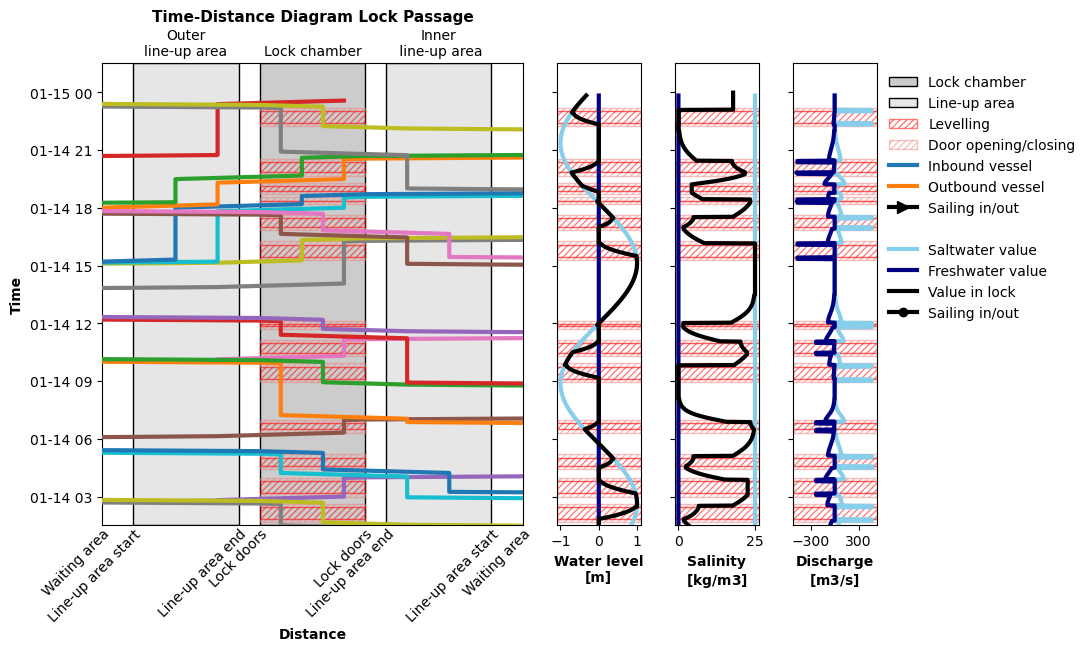

In [23]:
delays = False
entering_leaving = False

distance_to_lock_edge_start = lock_1.env.vessel_traffic_service.provide_sailing_distance_over_route(vessels[0],nx.dijkstra_path(FG,'Node_1','Node_49'))['Distance'].sum()
distance_to_lock_edge_end = lock_1.env.vessel_traffic_service.provide_sailing_distance_over_route(vessels[0],nx.dijkstra_path(FG,'Node_1','Node_50'))['Distance'].sum()
lock_outer_doors = distance_to_lock_edge_start+lock_1.distance_doors1_from_first_waiting_area
lock_inner_doors = distance_to_lock_edge_end-lock_1.distance_doors1_from_first_waiting_area
lineup_1_start = lock_outer_doors - lineup_area_1.distance_to_lock_doors - lineup_area_1.lineup_length
lineup_1_end = lock_outer_doors - lineup_area_1.distance_to_lock_doors
lineup_2_start = lock_inner_doors + lineup_area_2.distance_to_lock_doors + lineup_area_2.lineup_length
lineup_2_end = lock_inner_doors + lineup_area_2.distance_to_lock_doors

fig,axes = plt.subplots(1,4,figsize=[10,6],gridspec_kw = {'width_ratios':[5,1,1,1]})
ax = axes[0]
for time,distance in zip(times,distances):
    ax.plot(distance,time,linewidth=3,zorder=3)
vessel1, = ax.plot([-1,-1],color='C0',linewidth=3)
vessel2, = ax.plot([-1,-1],color='C1',linewidth=3)
for _vessel_ in vessels:
    vessel_df = pd.DataFrame(_vessel_.log)
    if len(vessel_df) < 120:
        continue
    arrival_time = datetime.datetime.fromtimestamp(_vessel_.arrival_time)
    if _vessel_.route[0] == 'Node_98':
        sail_in_time_vessel_2 = pd.DataFrame(_vessel_.log).loc[_vessel_.log['Action'].index('Sailing to first set of lock doors stop')].Time
        sail_out_time_vessel_2 = pd.DataFrame(_vessel_.log).loc[_vessel_.log['Action'].index('Sailing to second set of lock doors stop')].Time
        if entering_leaving:
            ax.plot(lock_inner_doors-40,sail_in_time_vessel_2+pd.Timedelta(40/4,'s'),'C1',marker='<',markersize=8)
            ax.plot(lock_outer_doors-40,sail_out_time_vessel_2+pd.Timedelta(40/4,'s'),'C1',marker='<',markersize=8)
        if delays:
            ax.plot([final_geometry.length,0],[arrival_time,arrival_time+pd.Timedelta(int(final_geometry.length/4),'s')],color='C1',linestyle='--',linewidth=2)
            passage_lineup_start = vessel_df.loc[_vessel_.log['Action'].index('Sailing to line-up area start')].Time
            passage_lineup_stop = vessel_df.loc[_vessel_.log['Action'].index('Sailing to line-up area stop')].Time
            delayed_arrival = 0.8*(passage_lineup_stop-passage_lineup_start)+passage_lineup_start
            normal_arrival = pd.Timedelta((distance_to_lock_edge_start+2000*0.8)/4,'s')+datetime.datetime.fromtimestamp(_vessel_.arrival_time)
            annotate_location = 0.8*(lineup_1_start-lineup_1_end)+lineup_1_end
            ax.annotate('', xy=(annotate_location, delayed_arrival), xycoords='data',
                        xytext=(annotate_location, normal_arrival), textcoords='data',
                        arrowprops={'arrowstyle': '<->'})
            waiting_time = pd.Timedelta(int((delayed_arrival-normal_arrival).total_seconds()/60),'min')
            hours,remainder = divmod(waiting_time.seconds, 3600)
            minutes,_ = divmod(remainder, 60)
            annotate_text_location = 0.5*(delayed_arrival-normal_arrival)+normal_arrival
            ax.annotate(r'$\mathbf{Delay\ time}$'+':\n'+'{:02} hrs {:02} mins'.format(int(hours), int(minutes)), xy=(50+annotate_location,annotate_text_location),
                        xycoords='data',xytext=(5, 0), textcoords='offset points', rotation=90,verticalalignment='center',horizontalalignment='center',color='C1')        

    else:
        sail_in_time_vessel_1 = pd.DataFrame(_vessel_.log).loc[_vessel_.log['Action'].index('Sailing to first set of lock doors stop')].Time
        sail_out_time_vessel_1 = pd.DataFrame(_vessel_.log).loc[_vessel_.log['Action'].index('Sailing to second set of lock doors stop')].Time
        if entering_leaving:
            ax.plot(lock_outer_doors+40,sail_in_time_vessel_1+pd.Timedelta(40/4,'s'),'C0',marker='>',markersize=8)
            ax.plot(lock_inner_doors+40,sail_out_time_vessel_1+pd.Timedelta(40/4,'s'),'C0',marker='>',markersize=8)
        if delays:
            ax.plot([0,final_geometry.length],[arrival_time,arrival_time+pd.Timedelta(int(final_geometry.length/4),'s')],color='C0',linestyle='--',linewidth=2)
            passage_lineup_start = vessel_df.loc[_vessel_.log['Action'].index('Sailing to line-up area start')].Time
            passage_lineup_stop = vessel_df.loc[_vessel_.log['Action'].index('Sailing to line-up area stop')].Time
            delayed_arrival = 0.8*(passage_lineup_stop-passage_lineup_start)+passage_lineup_start
            normal_arrival = pd.Timedelta((distance_to_lock_edge_start+2000*0.8)/4,'s')+datetime.datetime.fromtimestamp(_vessel_.arrival_time)
            annotate_location = 0.8*(lineup_2_start-lineup_2_end)+lineup_2_end
            ax.annotate('', xy=(annotate_location, delayed_arrival), xycoords='data',
                        xytext=(annotate_location, normal_arrival), textcoords='data',
                        arrowprops={'arrowstyle': '<->'})
            waiting_time = pd.Timedelta(int((delayed_arrival-normal_arrival).total_seconds()/60),'min')
            hours,remainder = divmod(waiting_time.seconds, 3600)
            minutes,_ = divmod(remainder, 60)
            annotate_text_location = 0.5*(delayed_arrival-normal_arrival)+normal_arrival
            ax.annotate(r'$\mathbf{Delay\ time}$'+':\n'+'{:02} hrs {:02} mins'.format(int(hours), int(minutes)), xy=(annotate_location-120,annotate_text_location),
                        xycoords='data',xytext=(5, 0), textcoords='offset points', rotation=270,verticalalignment='center',horizontalalignment='center',color='C0')        
        
lock_df = pd.DataFrame(lock_1.log)
for loc,info in lock_df.iterrows():
    if info.Action == 'Lock chamber converting stop':
        door_opening_time = lock_df.loc[loc].Time
        door_closing_time = lock_df.loc[loc-1].Time
        levelling, = ax.fill([lock_outer_doors,lock_outer_doors,lock_inner_doors,lock_inner_doors],
                [door_opening_time,door_closing_time,door_closing_time,door_opening_time],
                hatch='/////',zorder=2,color='none',edgecolor='red',alpha=0.5)
    if info.Action == 'Lock doors closing stop':
        door_opening_time = lock_df.loc[loc].Time
        door_closing_time = lock_df.loc[loc-1].Time
        door_opening_closing, = ax.fill([lock_outer_doors,lock_outer_doors,lock_inner_doors,lock_inner_doors],
                [door_opening_time,door_closing_time,door_closing_time,door_opening_time],
                hatch='/////',zorder=1,color='none',edgecolor='lightcoral',alpha=0.5)
    if info.Action == 'Lock doors opening stop':
        door_opening_time = lock_df.loc[loc].Time
        door_closing_time = lock_df.loc[loc-1].Time
        ax.fill([lock_outer_doors,lock_outer_doors,lock_inner_doors,lock_inner_doors],
                [door_opening_time,door_closing_time,door_closing_time,door_opening_time],
                hatch='/////',zorder=1,color='none',edgecolor='lightcoral',alpha=0.5)
    
ylim_min = lock_df.loc[0].Time-pd.Timedelta(1,'h')
ylim_max = lock_df.iloc[-7].Time+pd.Timedelta(5,'h')
ylim_min = ylim_max - pd.Timedelta(24,'h')
#ylim_max = ylim_min + pd.Timedelta(5,'h')
#ylim_min += pd.Timedelta(12,'h')
#ylim_max = ylim_min + pd.Timedelta(12,'h')

ax.set_ylim(ylim_min,ylim_max)
ylim = ax.get_ylim()
lineup_area_fill, = ax.fill([lineup_1_start,lineup_1_start,lineup_1_end,lineup_1_end],
        [ylim[0],ylim[1],ylim[1],ylim[0]],zorder=0,color=[0.9,0.9,0.9],edgecolor='k')
ax.fill([lineup_2_start,lineup_2_start,lineup_2_end,lineup_2_end],
        [ylim[0],ylim[1],ylim[1],ylim[0]],
        zorder=0,color=[0.9,0.9,0.9],edgecolor='k')
lock_chamber_fill, = ax.fill([lock_outer_doors,lock_outer_doors,lock_inner_doors,lock_inner_doors],
        [ylim[0],ylim[1],ylim[1],ylim[0]],
        zorder=0,color=[0.8,0.8,0.8],edgecolor='k')
ax.set_xlim([distance_to_lock_edge_start,distance_to_lock_edge_end])
ax.set_ylim(ylim)
ax.set_xticks([])

ax.text(50/2000, -0.025, 'Waiting area',verticalalignment='bottom',horizontalalignment='right',
        rotation_mode='anchor',rotation=45,
        transform=ax.transAxes)
ax.text(200/2000, -0.025, 'Line-up area start',verticalalignment='bottom',horizontalalignment='right',
        rotation_mode='anchor',rotation=45,
        transform=ax.transAxes)
ax.text(700/2000, -0.025, 'Line-up area end',verticalalignment='bottom',horizontalalignment='right',
        rotation_mode='anchor',rotation=45,
        transform=ax.transAxes)
ax.text(800/2000, -0.025, 'Lock doors',verticalalignment='bottom',horizontalalignment='right',
        rotation_mode='anchor',rotation=45,
        transform=ax.transAxes)
ax.text(1300/2000, -0.025, 'Lock doors',verticalalignment='bottom',horizontalalignment='right',
        rotation_mode='anchor',rotation=45,
        transform=ax.transAxes)
ax.text(1400/2000, -0.025, 'Line-up area end',verticalalignment='bottom',horizontalalignment='right',
        rotation_mode='anchor',rotation=45,
        transform=ax.transAxes)
ax.text(1900/2000, -0.025, 'Line-up area start',verticalalignment='bottom',horizontalalignment='right',
        rotation_mode='anchor',rotation=45,
        transform=ax.transAxes)
ax.text(2050/2000, -0.025, 'Waiting area',verticalalignment='bottom',horizontalalignment='right',
        rotation_mode='anchor',rotation=45,
        transform=ax.transAxes)
ax.text(400/2000,1.075,'Outer\nline-up area',verticalalignment='top',horizontalalignment='center',transform=ax.transAxes)
ax.text(1000/2000,1.075,'\nLock chamber',verticalalignment='top',horizontalalignment='center',transform=ax.transAxes)
ax.text(1600/2000,1.075,'Inner\n line-up area',verticalalignment='top',horizontalalignment='center',transform=ax.transAxes)
ax.set_xlabel('Distance',labelpad=70,fontweight='bold')
ax.set_ylabel('Time',fontweight='bold')
ax.set_title('Time-Distance Diagram Lock Passage',fontsize=11,fontweight='bold',pad=30)

ax = axes[1]
ax.set_facecolor('white')
ax.plot(hydrodynamic_data.sel(STATIONS=48)['Water level'].values,
        hydrodynamic_data.sel(STATIONS=48)['Water level'].TIME.values,
        color='skyblue',zorder=3,linewidth=3)
ax.plot(hydrodynamic_data.sel(STATIONS=49)['Water level'].values,
        hydrodynamic_data.sel(STATIONS=49)['Water level'].TIME.values,
        color='navy',zorder=3,linewidth=3)
lock_level, = ax.plot(lock_1.water_level.values,lock_1.water_level.TIME.values,zorder=4,linewidth=3,color='k')
ax.set_ylim(ylim)
ax.set_yticklabels([])
xlim_min,xlim_max = ax.get_xlim()
for loc,info in lock_df.iterrows():
    if info.Action == 'Lock chamber converting stop':
        door_opening_time = lock_df.loc[loc].Time
        door_closing_time = lock_df.loc[loc-1].Time
        ax.fill([xlim_min,xlim_min,xlim_max,xlim_max],
                [door_opening_time,door_closing_time,door_closing_time,door_opening_time],
                hatch='/////',zorder=2,color='none',edgecolor='red',alpha=0.5)
    if info.Action == 'Lock doors closing stop':
        door_opening_time = lock_df.loc[loc].Time
        door_closing_time = lock_df.loc[loc-1].Time
        ax.fill([xlim_min,xlim_min,xlim_max,xlim_max],
                [door_opening_time,door_closing_time,door_closing_time,door_opening_time],
                hatch='/////',zorder=1,color='none',edgecolor='lightcoral',alpha=0.5)
    if info.Action == 'Lock doors opening stop':
        door_opening_time = lock_df.loc[loc].Time
        door_closing_time = lock_df.loc[loc-1].Time
        ax.fill([xlim_min,xlim_min,xlim_max,xlim_max],
                [door_opening_time,door_closing_time,door_closing_time,door_opening_time],
                hatch='/////',zorder=1,color='none',edgecolor='lightcoral',alpha=0.5)
ax.set_xlim(xlim_min,xlim_max)
#ax.set_title('Lock\nChamber\nWater level',fontsize=11,fontweight='bold')
ax.set_xticks([-1,0,1])
ax.set_xlabel('Water level\n[m]',fontweight='bold')

ax = axes[2]
ax.set_facecolor('white')
ax.plot(hydrodynamic_data.sel(STATIONS=48)['Salinity'].values,
        hydrodynamic_data.sel(STATIONS=48)['Salinity'].TIME.values,
        color='skyblue',zorder=3,linewidth=3)
ax.plot(hydrodynamic_data.sel(STATIONS=49)['Salinity'].values,
        hydrodynamic_data.sel(STATIONS=49)['Salinity'].TIME.values,
        color='navy',zorder=3,linewidth=3)
ax.plot(lock_1.salinity.values,lock_1.salinity.TIME.values,zorder=4,linewidth=3,color='k')
ax.set_ylim(ylim)
ax.set_yticklabels([])
xlim_min,xlim_max = ax.get_xlim()
for loc,info in lock_df.iterrows():
    if info.Action == 'Lock chamber converting stop':
        door_opening_time = lock_df.loc[loc].Time
        door_closing_time = lock_df.loc[loc-1].Time
        ax.fill([xlim_min,xlim_min,xlim_max,xlim_max],
                [door_opening_time,door_closing_time,door_closing_time,door_opening_time],
                hatch='/////',zorder=2,color='none',edgecolor='red',alpha=0.5)
    if info.Action == 'Lock doors closing stop':
        door_opening_time = lock_df.loc[loc].Time
        door_closing_time = lock_df.loc[loc-1].Time
        ax.fill([xlim_min,xlim_min,xlim_max,xlim_max],
                [door_opening_time,door_closing_time,door_closing_time,door_opening_time],
                hatch='/////',zorder=1,color='none',edgecolor='lightcoral',alpha=0.5)
    if info.Action == 'Lock doors opening stop':
        door_opening_time = lock_df.loc[loc].Time
        door_closing_time = lock_df.loc[loc-1].Time
        ax.fill([xlim_min,xlim_min,xlim_max,xlim_max],
                [door_opening_time,door_closing_time,door_closing_time,door_opening_time],
                hatch='/////',zorder=1,color='none',edgecolor='lightcoral',alpha=0.5)
ax.set_xlim(xlim_min,xlim_max)
#ax.set_title('Lock\nChamber\nSalinity',fontsize=11,fontweight='bold')
ax.set_xticks([0,25])
ax.set_xlabel('Salinity\n'+r'[kg/m$\mathregular{3}$]',fontweight='bold')

ax = axes[3]
ax.set_facecolor('white')
freshwater, = ax.plot(lock_1.discharge_fresh.values,lock_1.discharge_fresh.TIME.values,color='navy',linewidth=3,zorder=4)
if entering_leaving:
    ax.plot(lock_1.discharge_fresh.interp(TIME=sail_in_time_vessel_1).values,sail_in_time_vessel_1,marker='o',color='navy',markersize=6)
    ax.plot(lock_1.discharge_fresh.interp(TIME=sail_out_time_vessel_1).values,sail_out_time_vessel_1,marker='o',color='navy',markersize=6)
saltwater, = ax.plot(lock_1.discharge_saline.values,lock_1.discharge_saline.TIME.values,color='skyblue',linewidth=3,zorder=3)
if entering_leaving:
    ax.plot(lock_1.discharge_saline.interp(TIME=sail_in_time_vessel_2).values,sail_in_time_vessel_2,marker='o',color='skyblue',markersize=6)
    ax.plot(lock_1.discharge_saline.interp(TIME=sail_out_time_vessel_2).values,sail_out_time_vessel_2,marker='o',color='skyblue',markersize=6)
sail_in_out_arrow, = ax.plot([0,0],color='k',marker='>',markersize=8,linewidth=3)
sail_in_out_point, = ax.plot([0,0],color='k',marker='o',markersize=6,linewidth=3)

ax.set_ylim(ylim)
ax.set_yticklabels([])
xlim_min,xlim_max = ax.get_xlim()
for loc,info in lock_df.iterrows():
    if info.Action == 'Lock chamber converting stop':
        door_opening_time = lock_df.loc[loc].Time
        door_closing_time = lock_df.loc[loc-1].Time
        ax.fill([xlim_min,xlim_min,xlim_max,xlim_max],
                [door_opening_time,door_closing_time,door_closing_time,door_opening_time],
                hatch='/////',zorder=2,color='none',edgecolor='red',alpha=0.5)
    if info.Action == 'Lock doors closing stop':
        door_opening_time = lock_df.loc[loc].Time
        door_closing_time = lock_df.loc[loc-1].Time
        ax.fill([xlim_min,xlim_min,xlim_max,xlim_max],
                [door_opening_time,door_closing_time,door_closing_time,door_opening_time],
                hatch='/////',zorder=1,color='none',edgecolor='lightcoral',alpha=0.5)
    if info.Action == 'Lock doors opening stop':
        door_opening_time = lock_df.loc[loc].Time
        door_closing_time = lock_df.loc[loc-1].Time
        ax.fill([xlim_min,xlim_min,xlim_max,xlim_max],
                [door_opening_time,door_closing_time,door_closing_time,door_opening_time],
                hatch='/////',zorder=1,color='none',edgecolor='lightcoral',alpha=0.5)
ax.set_xlim(xlim_min,xlim_max)
#ax.set_title('Lock\nChamber\nDischarge',fontsize=11,fontweight='bold')
ax.legend([lock_chamber_fill,lineup_area_fill,levelling,door_opening_closing,vessel1,vessel2,sail_in_out_arrow,mpl.patches.Patch(color='none'),
           saltwater,freshwater,lock_level,sail_in_out_point],
          ['Lock chamber','Line-up area','Levelling','Door opening/closing','Inbound vessel','Outbound vessel','Sailing in/out','',
           'Saltwater value','Freshwater value','Value in lock','Sailing in/out'],
          bbox_to_anchor=[1,1],frameon=False,prop={'size':10})
ax.set_xticks([-300,300])
ax.set_xlabel('Discharge\n'+r'[m$\mathregular{3}$/s]',fontweight='bold');
#fig.savefig('Basic_lock_passage.svg',dpi=500,format='svg',bbox_inches='tight');

In [24]:
for loc,info in lock_df.iterrows():
    if info.Action == 'Lock chamber converting start':
        if lock_df.loc[loc-1,'Action'] != 'Lock doors closing stop':
            print(loc)
        if lock_df.loc[loc+1,'Action'] != 'Lock chamber converting stop':
            print(loc)

In [25]:
lock_df = pd.DataFrame(lock_1.log)
lock_df.tail(n=200)[0:50]

,Time,Location,Action,Status
970,2019-01-12 11:02:46.562938,Node_50,Lock doors opening start,{}
971,2019-01-12 11:12:46.562938,Node_50,Lock doors opening stop,{}
972,2019-01-12 11:26:08.700749,Node_50,Lock doors closing start,{}
973,2019-01-12 11:36:08.700749,Node_50,Lock doors closing stop,{}
974,2019-01-12 11:36:08.700749,Node_50,Lock chamber converting start,{}
975,2019-01-12 12:08:08.700749,Node_49,Lock chamber converting stop,{}
976,2019-01-12 12:08:08.700749,Node_49,Lock doors opening start,{}
977,2019-01-12 12:18:08.700749,Node_49,Lock doors opening stop,{}
978,2019-01-12 12:29:15.367416,Node_49,Lock doors closing start,{}
979,2019-01-12 12:39:15.367416,Node_49,Lock doors closing stop,{}


In [26]:
salt_transport_df = pd.DataFrame(columns=['Side','Levelling start','Levelling stop','Door Open','Door Closed',
                                          'Water level start levelling','Water level stop levelling',
                                          'Ship Volume Left','Ship Volume Entered'])
for loc,info in lock_df.iterrows():
    if info.Action == 'Lock doors closing stop' and loc > 2:
        levelling_start = lock_df.loc[loc-5].Time
        levelling_stop = lock_df.loc[loc-4].Time
        index_levelling_start = np.absolute(lock_1.water_level.TIME.values-np.datetime64(levelling_start)).argmin()
        index_levelling_stop = np.absolute(lock_1.water_level.TIME.values-np.datetime64(levelling_stop)).argmin()
        water_level_start_levelling = lock_1.water_level[index_levelling_start].values
        water_level_stop_levelling = lock_1.water_level[index_levelling_stop].values
        door_open = (lock_df.loc[loc-2].Time-lock_df.loc[loc-3].Time)/2+lock_df.loc[loc-3].Time
        door_closed = (info.Time-lock_df.loc[loc-1].Time)/2+lock_df.loc[loc-1].Time
        volume_loss = 0
        volume_transported = 0
        for _vessel_ in vessels:
            vessel_df = pd.DataFrame(_vessel_.log)
            if vessel_df.empty:
                continue
            vessel_df_door_open_time = vessel_df[(vessel_df.Time > door_open - datetime.timedelta(seconds=lock_1.doors_open)) & 
                                                 (vessel_df.Time < door_closed + datetime.timedelta(seconds=lock_1.doors_close))]
            if not vessel_df_door_open_time.empty and vessel_df_door_open_time.iloc[0].Action == 'Passing lock stop':
                volume_loss += _vessel_.L*_vessel_.B*_vessel_.T
            if not vessel_df_door_open_time.empty and vessel_df_door_open_time.iloc[-1].Action == 'Passing lock start':
                volume_transported += _vessel_.L*_vessel_.B*_vessel_.T
        salt_transport_df.loc[len(salt_transport_df),:] = [info.Location,levelling_start,levelling_stop,door_open,door_closed,
                                                           water_level_start_levelling,water_level_stop_levelling,
                                                           volume_loss,volume_transported]

In [27]:
salt_transport_df['Salt Exchange [kg]'] = 0.0
salt_transport_df['Salt Transported [kg]'] = 0.0
salt_transport_df['Freshwater Exchange [m3]'] = 0.0
salt_transport_df['Freshwater Transported [m3]'] = 0.0
salt_transport_df['Freshwater Levelled [m3]'] = 0.0

for loc,info in salt_transport_df.iterrows():
    if info.Side == 'Node_50':
        salinity_difference = lock_1.salinity.interp(TIME=info['Door Open']).values-np.nanmax([0,lock_1.salinity.interp(TIME=info['Door Closed']).values])
        salt_transport_df.loc[loc,'Salt Exchange [kg]'] = salinity_difference*lock_1.lock_length*lock_1.lock_width*lock_1.lock_depth
        salt_transport_df.loc[loc,'Salt Transported [kg]'] = np.nanmax([0,lock_1.salinity.interp(TIME=info['Door Closed']).values])*info['Ship Volume Entered']
        salt_transport_df.loc[loc,'Freshwater Exchange [m3]'] = lock_1.lock_length*lock_1.lock_width*lock_1.lock_depth*np.tanh((info['Door Closed']-info['Door Open']).total_seconds()/(2*lock_1.lock_length/(0.5*np.sqrt(9.81*0.8*salinity_difference*lock_1.lock_depth/(1000+0.8*25/2)))))
        salt_transport_df.loc[loc,'Freshwater Transported [m3]'] = info['Ship Volume Left']
        water_levelling_difference = info['Water level stop levelling']-info['Water level start levelling']
        if water_levelling_difference > 0:
            salt_transport_df['Freshwater Levelled [m3]'] = water_levelling_difference

In [28]:
(salt_transport_df['Salt Transported [kg]'].sum()+salt_transport_df['Salt Exchange [kg]'].sum())/(25*lock_1.lock_length*lock_1.lock_width*lock_1.lock_depth)

41.53949582818664

In [29]:
delay_df = pd.DataFrame(columns=['Delay'])
for _vessel_ in vessels:
    vessel_df = pd.DataFrame(_vessel_.log)
    start_df = vessel_df[vessel_df.Action == 'Sailing from node Node_49 to node Node_50 start']
    stop_df = vessel_df[vessel_df.Action == 'Sailing from node Node_49 to node Node_50 stop']
    if stop_df.empty or start_df.empty:
        continue
    start_time = start_df.Time.iloc[0]
    stop_time = stop_df.Time.iloc[0]
    delay = stop_time-start_time-pd.Timedelta(FG.edges['Node_49','Node_50',0]['Info']['length']/vessels[0].v,'s')
    delay_df.loc[_vessel_.name,'Delay'] = delay

In [30]:
average_vessel_delay = delay_df.Delay.sum()/len(delay_df)

In [31]:
average_vessel_delay

Timedelta('0 days 02:37:08.613596777')

In [32]:
len(lock_df)/6

195.0

In [33]:
len(vessels)*6/2

984.0

In [34]:
14*24/2

168.0

In [35]:
(len(vessels)*6/2/(14*24/2)-5)*60

51.4285714285714